In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import logging
import os

from data_prep import Password as P
from model import Generator, Discriminator
from training_helper import *
from config import *

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
# custom weights initialization called on G and D
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0, 0.001)

In [3]:
g = Generator(GEN_HIDDEN_SIZE, GEN_NEURON_SIZE).to(device)
d = Discriminator(DISC_HIDDEN_SIZE, DISC_NEURON_SIZE).to(device)

In [4]:
#opt_g = torch.optim.Adam(g.parameters(), lr=0.0002, betas=(0.5, 0.999))
#opt_d = torch.optim.Adam(d.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_g = torch.optim.RMSprop(g.parameters(), lr=0.0002)
opt_d = torch.optim.RMSprop(d.parameters(), lr=0.0002)

In [5]:
p = P()
batch_gen = p.string_gen

INFO:root:Initializing passwords...
DEBUG:root:Loading from existing json file...
INFO:root:Done initializing passwords.


In [ ]:
g.pre_train(p)

In [42]:
logger.setLevel(logging.DEBUG)

TRAIN_FROM_CKPT = True

if os.path.isfile(DEFAULT_CHECKPOINT_PATH) and TRAIN_FROM_CKPT:
    checkpoint = torch.load(DEFAULT_CHECKPOINT_PATH, map_location = device)
    g.load_state_dict(checkpoint['gen_state_dict'])
    d.load_state_dict(checkpoint['disc_state_dict'])
    g = g.to(device)
    d = d.to(device)
    opt_g.load_state_dict(checkpoint['gen_optimizer_state_dict'])
    opt_d.load_state_dict(checkpoint['disc_optimizer_state_dict'])
    start_len = checkpoint['seq_len']
    start_iter = checkpoint['iter']
    disc_loss = checkpoint['disc_loss']
    gen_loss = checkpoint['gen_loss']
    real_loss = checkpoint['real_loss']
else:
    start_len = 1
    start_iter = 1
    disc_loss = []
    gen_loss = []
    real_loss = []

for seq_len in range(start_len, MAX_LEN + 1):
    logging.info("---------- Adversarial Training with Seq Len %d, Batch Size %d ----------\n" 
                 % (seq_len, BATCH_SIZE))
    
    for i in range(start_iter, ITERS_PER_SEQ_LEN + 1):
                
        if i % SAVE_CHECKPOINTS_EVERY == 0:
            torch.save({
                'seq_len': seq_len,
                'gen_state_dict': g.state_dict(),
                'disc_state_dict': d.state_dict(),
                'gen_optimizer_state_dict': opt_g.state_dict(),
                'disc_optimizer_state_dict': opt_d.state_dict(),
                'iter': i,
                'gen_loss': gen_loss,
                'disc_loss': disc_loss,
                'real_loss': real_loss
                }, DEFAULT_CHECKPOINT_PATH)
            logging.info("  *** Model Saved ***\n")
        
        logging.debug("----------------- %d / %d -----------------\n" % (i, ITERS_PER_SEQ_LEN))

        logging.debug("Training discriminator...\n")
        
        d.requiresGrad()
        d.zero_grad()
        g.zero_grad()
        for j in range(CRITIC_ITERS):
            with torch.backends.cudnn.flags(enabled=False):
                L = 0
                
                data = next(batch_gen)
                pred = g(data, seq_len)
                real, fake = get_train_dis(data, pred, seq_len)
                interpolate = get_interpolate(real, fake)

                # Genuine
                disc_real = d(real, seq_len)
                loss_real = -disc_real.mean()
                logging.debug("real loss: "+str(loss_real.item()))
                L += loss_real

                # Fake
                disc_fake = d(fake, seq_len)
                loss_fake = disc_fake.mean()
                logging.debug("fake loss: "+str(loss_fake.item()))
                L += loss_fake

                # Gradient penalty
                interpolate = torch.autograd.Variable(interpolate, requires_grad=True)
                disc_interpolate = d(interpolate, seq_len)
                grad = torch.ones_like(disc_interpolate).to(device)
                gradients = torch.autograd.grad(
                        outputs=disc_interpolate,
                        inputs=interpolate,
                        grad_outputs=grad,
                        create_graph=True,
                        retain_graph=True,
                        only_inputs=True,
                    )[0]
                loss_gp = ((gradients.norm(2, dim=2) - 1) ** 2).mean() * LAMBDA
                logging.debug("grad loss: "+str(loss_gp.item()))
                L += loss_gp

                L.backward(retain_graph=False)
                opt_d.step()
                
                logging.debug("Critic Iter " + str(j+1) + " Loss: " + str(L.item()) + "\n")


        logging.debug("Done training discriminator.\n")    

        logging.debug("Training generator...")

        d.requiresNoGrad()

        for j in range(GEN_ITERS):
            data = next(batch_gen)
            pred = g(data, seq_len)
            fake = get_train_gen(data, pred, seq_len)
            loss_gen = -d(fake, seq_len).mean()
            logging.debug("Gen Iter " + str(j+1) + " Loss: "+str(loss_gen.item()))
            loss_gen.backward(retain_graph=False)
            opt_g.step()

        logging.debug("Done training generator.\n")

        if i % SAVE_CHECKPOINTS_EVERY == 0:
            real_loss.append(loss_real)
            disc_loss.append(L)
            gen_loss.append(loss_gen)
    
    start_iter = 1
    

INFO:root:---------- Adversarial Training with Seq Len 11, Batch Size 16 ----------

INFO:root:  *** Model Saved ***

DEBUG:root:----------------- 2000 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.0257322788238525
DEBUG:root:fake loss: 2.6295526027679443
DEBUG:root:grad loss: 0.05576641112565994
DEBUG:root:Critic Iter 1 Loss: -0.34041327238082886

DEBUG:root:real loss: -3.0260753631591797
DEBUG:root:fake loss: 2.6597774028778076
DEBUG:root:grad loss: 0.05403689295053482
DEBUG:root:Critic Iter 2 Loss: -0.31226107478141785

DEBUG:root:real loss: -2.993134021759033
DEBUG:root:fake loss: 2.591688394546509
DEBUG:root:grad loss: 0.06092333793640137
DEBUG:root:Critic Iter 3 Loss: -0.34052228927612305

DEBUG:root:real loss: -3.0271155834198
DEBUG:root:fake loss: 2.7429680824279785
DEBUG:root:grad loss: 0.05950707942247391
DEBUG:root:Critic Iter 4 Loss: -0.22464042901992798

DEBUG:root:real loss: -3.13659405708313
DEBUG:root:fake loss: 2.7746212482452

DEBUG:root:Gen Iter 3 Loss: -2.839722156524658
DEBUG:root:Gen Iter 4 Loss: -2.865510940551758
DEBUG:root:Gen Iter 5 Loss: -2.777243137359619
DEBUG:root:Gen Iter 6 Loss: -2.7787280082702637
DEBUG:root:Gen Iter 7 Loss: -2.8087525367736816
DEBUG:root:Gen Iter 8 Loss: -2.7835049629211426
DEBUG:root:Gen Iter 9 Loss: -2.78684139251709
DEBUG:root:Gen Iter 10 Loss: -2.8992927074432373
DEBUG:root:Gen Iter 11 Loss: -2.770493268966675
DEBUG:root:Gen Iter 12 Loss: -2.804439067840576
DEBUG:root:Gen Iter 13 Loss: -2.7219016551971436
DEBUG:root:Gen Iter 14 Loss: -2.8326926231384277
DEBUG:root:Gen Iter 15 Loss: -2.7570292949676514
DEBUG:root:Gen Iter 16 Loss: -2.7422614097595215
DEBUG:root:Gen Iter 17 Loss: -2.8048713207244873
DEBUG:root:Gen Iter 18 Loss: -2.825862407684326
DEBUG:root:Gen Iter 19 Loss: -2.8012263774871826
DEBUG:root:Gen Iter 20 Loss: -2.9026076793670654
DEBUG:root:Gen Iter 21 Loss: -2.7982242107391357
DEBUG:root:Gen Iter 22 Loss: -2.7964396476745605
DEBUG:root:Gen Iter 23 Loss: -2.851

DEBUG:root:grad loss: 0.05363691225647926
DEBUG:root:Critic Iter 1 Loss: -0.23462927341461182

DEBUG:root:real loss: -3.1341300010681152
DEBUG:root:fake loss: 2.795032262802124
DEBUG:root:grad loss: 0.0650145560503006
DEBUG:root:Critic Iter 2 Loss: -0.2740831971168518

DEBUG:root:real loss: -3.0746703147888184
DEBUG:root:fake loss: 2.7836079597473145
DEBUG:root:grad loss: 0.06439831852912903
DEBUG:root:Critic Iter 3 Loss: -0.22666403651237488

DEBUG:root:real loss: -3.0842928886413574
DEBUG:root:fake loss: 2.8340795040130615
DEBUG:root:grad loss: 0.049412213265895844
DEBUG:root:Critic Iter 4 Loss: -0.20080116391181946

DEBUG:root:real loss: -3.1094017028808594
DEBUG:root:fake loss: 2.7000529766082764
DEBUG:root:grad loss: 0.06074654310941696
DEBUG:root:Critic Iter 5 Loss: -0.34860217571258545

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.719637632369995
DEBUG:root:Gen Iter 2 Loss: -2.826066732406616
DEBUG:root:Gen Iter 3 Loss:

DEBUG:root:Gen Iter 10 Loss: -2.77082896232605
DEBUG:root:Gen Iter 11 Loss: -2.7197206020355225
DEBUG:root:Gen Iter 12 Loss: -2.7736804485321045
DEBUG:root:Gen Iter 13 Loss: -2.764572858810425
DEBUG:root:Gen Iter 14 Loss: -2.7932753562927246
DEBUG:root:Gen Iter 15 Loss: -2.6974596977233887
DEBUG:root:Gen Iter 16 Loss: -2.77189040184021
DEBUG:root:Gen Iter 17 Loss: -2.8226470947265625
DEBUG:root:Gen Iter 18 Loss: -2.7153897285461426
DEBUG:root:Gen Iter 19 Loss: -2.795865535736084
DEBUG:root:Gen Iter 20 Loss: -2.8061957359313965
DEBUG:root:Gen Iter 21 Loss: -2.7586841583251953
DEBUG:root:Gen Iter 22 Loss: -2.7490172386169434
DEBUG:root:Gen Iter 23 Loss: -2.657930850982666
DEBUG:root:Gen Iter 24 Loss: -2.7481343746185303
DEBUG:root:Gen Iter 25 Loss: -2.8316731452941895
DEBUG:root:Done training generator.

DEBUG:root:----------------- 11 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.0401198863983154
DEBUG:root:fake loss: 2.7520549297332764
DEBUG:r

DEBUG:root:fake loss: 2.7828750610351562
DEBUG:root:grad loss: 0.07740955054759979
DEBUG:root:Critic Iter 3 Loss: -0.24407954514026642

DEBUG:root:real loss: -3.106304883956909
DEBUG:root:fake loss: 2.791579008102417
DEBUG:root:grad loss: 0.05072527006268501
DEBUG:root:Critic Iter 4 Loss: -0.2640005946159363

DEBUG:root:real loss: -3.079911708831787
DEBUG:root:fake loss: 2.786210775375366
DEBUG:root:grad loss: 0.05575006827712059
DEBUG:root:Critic Iter 5 Loss: -0.23795086145401

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.8028361797332764
DEBUG:root:Gen Iter 2 Loss: -2.7646052837371826
DEBUG:root:Gen Iter 3 Loss: -2.7281532287597656
DEBUG:root:Gen Iter 4 Loss: -2.637842893600464
DEBUG:root:Gen Iter 5 Loss: -2.859463691711426
DEBUG:root:Gen Iter 6 Loss: -2.7671165466308594
DEBUG:root:Gen Iter 7 Loss: -2.724735975265503
DEBUG:root:Gen Iter 8 Loss: -2.789254665374756
DEBUG:root:Gen Iter 9 Loss: -2.7746009826660156
DEBUG:root:Gen

DEBUG:root:Gen Iter 17 Loss: -2.9182004928588867
DEBUG:root:Gen Iter 18 Loss: -2.86558198928833
DEBUG:root:Gen Iter 19 Loss: -2.8040530681610107
DEBUG:root:Gen Iter 20 Loss: -2.8264880180358887
DEBUG:root:Gen Iter 21 Loss: -2.8644509315490723
DEBUG:root:Gen Iter 22 Loss: -2.868957996368408
DEBUG:root:Gen Iter 23 Loss: -2.898090124130249
DEBUG:root:Gen Iter 24 Loss: -2.809035062789917
DEBUG:root:Gen Iter 25 Loss: -2.7611589431762695
DEBUG:root:Done training generator.

DEBUG:root:----------------- 18 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.133852005004883
DEBUG:root:fake loss: 2.788839817047119
DEBUG:root:grad loss: 0.07436325401067734
DEBUG:root:Critic Iter 1 Loss: -0.27064892649650574

DEBUG:root:real loss: -3.0622687339782715
DEBUG:root:fake loss: 2.6933140754699707
DEBUG:root:grad loss: 0.07105512917041779
DEBUG:root:Critic Iter 2 Loss: -0.2978995442390442

DEBUG:root:real loss: -3.1854000091552734
DEBUG:root:fake loss: 2.764945983886

DEBUG:root:fake loss: 2.7982826232910156
DEBUG:root:grad loss: 0.05681414529681206
DEBUG:root:Critic Iter 5 Loss: -0.33843308687210083

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.9581305980682373
DEBUG:root:Gen Iter 2 Loss: -2.8454322814941406
DEBUG:root:Gen Iter 3 Loss: -2.815518379211426
DEBUG:root:Gen Iter 4 Loss: -2.8459575176239014
DEBUG:root:Gen Iter 5 Loss: -2.885223388671875
DEBUG:root:Gen Iter 6 Loss: -2.793797254562378
DEBUG:root:Gen Iter 7 Loss: -2.829554319381714
DEBUG:root:Gen Iter 8 Loss: -2.8381381034851074
DEBUG:root:Gen Iter 9 Loss: -2.7640762329101562
DEBUG:root:Gen Iter 10 Loss: -2.8090462684631348
DEBUG:root:Gen Iter 11 Loss: -2.787571907043457
DEBUG:root:Gen Iter 12 Loss: -2.8424487113952637
DEBUG:root:Gen Iter 13 Loss: -2.8033804893493652
DEBUG:root:Gen Iter 14 Loss: -2.9117238521575928
DEBUG:root:Gen Iter 15 Loss: -2.7963104248046875
DEBUG:root:Gen Iter 16 Loss: -2.9293055534362793
DEBUG:root:Gen Iter 

DEBUG:root:Gen Iter 24 Loss: -2.750988006591797
DEBUG:root:Gen Iter 25 Loss: -2.7312371730804443
DEBUG:root:Done training generator.

DEBUG:root:----------------- 25 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.113981246948242
DEBUG:root:fake loss: 2.7260093688964844
DEBUG:root:grad loss: 0.06001218780875206
DEBUG:root:Critic Iter 1 Loss: -0.32795968651771545

DEBUG:root:real loss: -3.154207229614258
DEBUG:root:fake loss: 2.862051486968994
DEBUG:root:grad loss: 0.05575353652238846
DEBUG:root:Critic Iter 2 Loss: -0.2364022135734558

DEBUG:root:real loss: -3.166229248046875
DEBUG:root:fake loss: 2.828376293182373
DEBUG:root:grad loss: 0.06415239721536636
DEBUG:root:Critic Iter 3 Loss: -0.2737005650997162

DEBUG:root:real loss: -3.1478729248046875
DEBUG:root:fake loss: 2.8163249492645264
DEBUG:root:grad loss: 0.04468753933906555
DEBUG:root:Critic Iter 4 Loss: -0.2868604362010956

DEBUG:root:real loss: -3.179415702819824
DEBUG:root:fake loss: 2.7

DEBUG:root:Gen Iter 4 Loss: -2.6665496826171875
DEBUG:root:Gen Iter 5 Loss: -2.7321174144744873
DEBUG:root:Gen Iter 6 Loss: -2.7162885665893555
DEBUG:root:Gen Iter 7 Loss: -2.684967041015625
DEBUG:root:Gen Iter 8 Loss: -2.581272840499878
DEBUG:root:Gen Iter 9 Loss: -2.734877347946167
DEBUG:root:Gen Iter 10 Loss: -2.754340648651123
DEBUG:root:Gen Iter 11 Loss: -2.7357661724090576
DEBUG:root:Gen Iter 12 Loss: -2.7132797241210938
DEBUG:root:Gen Iter 13 Loss: -2.7327585220336914
DEBUG:root:Gen Iter 14 Loss: -2.738652229309082
DEBUG:root:Gen Iter 15 Loss: -2.722266674041748
DEBUG:root:Gen Iter 16 Loss: -2.6804301738739014
DEBUG:root:Gen Iter 17 Loss: -2.7393569946289062
DEBUG:root:Gen Iter 18 Loss: -2.64245343208313
DEBUG:root:Gen Iter 19 Loss: -2.6506500244140625
DEBUG:root:Gen Iter 20 Loss: -2.6439247131347656
DEBUG:root:Gen Iter 21 Loss: -2.762399673461914
DEBUG:root:Gen Iter 22 Loss: -2.7262723445892334
DEBUG:root:Gen Iter 23 Loss: -2.6861419677734375
DEBUG:root:Gen Iter 24 Loss: -2.736

DEBUG:root:Critic Iter 1 Loss: -0.22163057327270508

DEBUG:root:real loss: -3.059413433074951
DEBUG:root:fake loss: 2.7329041957855225
DEBUG:root:grad loss: 0.07555968314409256
DEBUG:root:Critic Iter 2 Loss: -0.25094956159591675

DEBUG:root:real loss: -3.073596477508545
DEBUG:root:fake loss: 2.6408333778381348
DEBUG:root:grad loss: 0.07024595141410828
DEBUG:root:Critic Iter 3 Loss: -0.3625171482563019

DEBUG:root:real loss: -3.0310797691345215
DEBUG:root:fake loss: 2.7058017253875732
DEBUG:root:grad loss: 0.03947267308831215
DEBUG:root:Critic Iter 4 Loss: -0.2858053743839264

DEBUG:root:real loss: -3.0673813819885254
DEBUG:root:fake loss: 2.7478976249694824
DEBUG:root:grad loss: 0.04456310719251633
DEBUG:root:Critic Iter 5 Loss: -0.27492064237594604

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.735335111618042
DEBUG:root:Gen Iter 2 Loss: -2.6936874389648438
DEBUG:root:Gen Iter 3 Loss: -2.689605474472046
DEBUG:root:Gen Iter 4 L

DEBUG:root:Gen Iter 12 Loss: -2.748147487640381
DEBUG:root:Gen Iter 13 Loss: -2.7095675468444824
DEBUG:root:Gen Iter 14 Loss: -2.6997857093811035
DEBUG:root:Gen Iter 15 Loss: -2.6769375801086426
DEBUG:root:Gen Iter 16 Loss: -2.7403876781463623
DEBUG:root:Gen Iter 17 Loss: -2.7718863487243652
DEBUG:root:Gen Iter 18 Loss: -2.7608871459960938
DEBUG:root:Gen Iter 19 Loss: -2.8233838081359863
DEBUG:root:Gen Iter 20 Loss: -2.750044584274292
DEBUG:root:Gen Iter 21 Loss: -2.72479248046875
DEBUG:root:Gen Iter 22 Loss: -2.6765334606170654
DEBUG:root:Gen Iter 23 Loss: -2.746694564819336
DEBUG:root:Gen Iter 24 Loss: -2.6886746883392334
DEBUG:root:Gen Iter 25 Loss: -2.735330104827881
DEBUG:root:Done training generator.

DEBUG:root:----------------- 36 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.0053699016571045
DEBUG:root:fake loss: 2.6577043533325195
DEBUG:root:grad loss: 0.06391812115907669
DEBUG:root:Critic Iter 1 Loss: -0.28374743461608887

DEBUG:roo

DEBUG:root:real loss: -3.01617431640625
DEBUG:root:fake loss: 2.712677478790283
DEBUG:root:grad loss: 0.064242884516716
DEBUG:root:Critic Iter 4 Loss: -0.2392539530992508

DEBUG:root:real loss: -3.068108320236206
DEBUG:root:fake loss: 2.774160861968994
DEBUG:root:grad loss: 0.05505535751581192
DEBUG:root:Critic Iter 5 Loss: -0.2388921082019806

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.6992297172546387
DEBUG:root:Gen Iter 2 Loss: -2.6941981315612793
DEBUG:root:Gen Iter 3 Loss: -2.717240810394287
DEBUG:root:Gen Iter 4 Loss: -2.593931198120117
DEBUG:root:Gen Iter 5 Loss: -2.7057368755340576
DEBUG:root:Gen Iter 6 Loss: -2.7151618003845215
DEBUG:root:Gen Iter 7 Loss: -2.6767406463623047
DEBUG:root:Gen Iter 8 Loss: -2.6891565322875977
DEBUG:root:Gen Iter 9 Loss: -2.7184195518493652
DEBUG:root:Gen Iter 10 Loss: -2.742293357849121
DEBUG:root:Gen Iter 11 Loss: -2.7256019115448
DEBUG:root:Gen Iter 12 Loss: -2.6990809440612793
DEBUG:

DEBUG:root:Gen Iter 20 Loss: -2.7350566387176514
DEBUG:root:Gen Iter 21 Loss: -2.7575106620788574
DEBUG:root:Gen Iter 22 Loss: -2.7819037437438965
DEBUG:root:Gen Iter 23 Loss: -2.7903504371643066
DEBUG:root:Gen Iter 24 Loss: -2.745089054107666
DEBUG:root:Gen Iter 25 Loss: -2.745692729949951
DEBUG:root:Done training generator.

DEBUG:root:----------------- 43 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.1390814781188965
DEBUG:root:fake loss: 2.802616834640503
DEBUG:root:grad loss: 0.06903716921806335
DEBUG:root:Critic Iter 1 Loss: -0.2674274742603302

DEBUG:root:real loss: -3.1007080078125
DEBUG:root:fake loss: 2.7453715801239014
DEBUG:root:grad loss: 0.06812500953674316
DEBUG:root:Critic Iter 2 Loss: -0.28721141815185547

DEBUG:root:real loss: -3.0800604820251465
DEBUG:root:fake loss: 2.736560344696045
DEBUG:root:grad loss: 0.057270582765340805
DEBUG:root:Critic Iter 3 Loss: -0.28622955083847046

DEBUG:root:real loss: -3.0369720458984375
DEBU

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.7019100189208984
DEBUG:root:Gen Iter 2 Loss: -2.6515467166900635
DEBUG:root:Gen Iter 3 Loss: -2.5486817359924316
DEBUG:root:Gen Iter 4 Loss: -2.582650661468506
DEBUG:root:Gen Iter 5 Loss: -2.6505799293518066
DEBUG:root:Gen Iter 6 Loss: -2.6684298515319824
DEBUG:root:Gen Iter 7 Loss: -2.638411283493042
DEBUG:root:Gen Iter 8 Loss: -2.720858573913574
DEBUG:root:Gen Iter 9 Loss: -2.651672840118408
DEBUG:root:Gen Iter 10 Loss: -2.591451644897461
DEBUG:root:Gen Iter 11 Loss: -2.692772626876831
DEBUG:root:Gen Iter 12 Loss: -2.6555893421173096
DEBUG:root:Gen Iter 13 Loss: -2.705465793609619
DEBUG:root:Gen Iter 14 Loss: -2.6096606254577637
DEBUG:root:Gen Iter 15 Loss: -2.6365041732788086
DEBUG:root:Gen Iter 16 Loss: -2.6778922080993652
DEBUG:root:Gen Iter 17 Loss: -2.7378337383270264
DEBUG:root:Gen Iter 18 Loss: -2.608241081237793
DEBUG:root:Gen Iter 19 Loss: -2.594787359237671
DEBUG:root:Gen Iter 20 Loss: -2.640275478363037
DEBUG:

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.063028335571289
DEBUG:root:fake loss: 2.704188823699951
DEBUG:root:grad loss: 0.06795036792755127
DEBUG:root:Critic Iter 1 Loss: -0.2908891439437866

DEBUG:root:real loss: -3.013090133666992
DEBUG:root:fake loss: 2.7442355155944824
DEBUG:root:grad loss: 0.06712517887353897
DEBUG:root:Critic Iter 2 Loss: -0.2017294466495514

DEBUG:root:real loss: -3.049694061279297
DEBUG:root:fake loss: 2.7230212688446045
DEBUG:root:grad loss: 0.058638643473386765
DEBUG:root:Critic Iter 3 Loss: -0.2680341601371765

DEBUG:root:real loss: -3.0308990478515625
DEBUG:root:fake loss: 2.634723663330078
DEBUG:root:grad loss: 0.05096995085477829
DEBUG:root:Critic Iter 4 Loss: -0.3452054262161255

DEBUG:root:real loss: -3.110630989074707
DEBUG:root:fake loss: 2.6876773834228516
DEBUG:root:grad loss: 0.06207989156246185
DEBUG:root:Critic Iter 5 Loss: -0.3608736991882324

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:ro

DEBUG:root:Gen Iter 8 Loss: -2.6601340770721436
DEBUG:root:Gen Iter 9 Loss: -2.6648988723754883
DEBUG:root:Gen Iter 10 Loss: -2.6100845336914062
DEBUG:root:Gen Iter 11 Loss: -2.668102979660034
DEBUG:root:Gen Iter 12 Loss: -2.6157567501068115
DEBUG:root:Gen Iter 13 Loss: -2.6748037338256836
DEBUG:root:Gen Iter 14 Loss: -2.6470754146575928
DEBUG:root:Gen Iter 15 Loss: -2.6598567962646484
DEBUG:root:Gen Iter 16 Loss: -2.6067585945129395
DEBUG:root:Gen Iter 17 Loss: -2.6279091835021973
DEBUG:root:Gen Iter 18 Loss: -2.5836689472198486
DEBUG:root:Gen Iter 19 Loss: -2.6812796592712402
DEBUG:root:Gen Iter 20 Loss: -2.626681089401245
DEBUG:root:Gen Iter 21 Loss: -2.70131254196167
DEBUG:root:Gen Iter 22 Loss: -2.6650872230529785
DEBUG:root:Gen Iter 23 Loss: -2.642770767211914
DEBUG:root:Gen Iter 24 Loss: -2.529597520828247
DEBUG:root:Gen Iter 25 Loss: -2.6575164794921875
DEBUG:root:Done training generator.

DEBUG:root:----------------- 54 / 2000 -----------------

DEBUG:root:Training discriminat

DEBUG:root:Critic Iter 2 Loss: -0.2044442743062973

DEBUG:root:real loss: -2.9695992469787598
DEBUG:root:fake loss: 2.6073920726776123
DEBUG:root:grad loss: 0.06507352739572525
DEBUG:root:Critic Iter 3 Loss: -0.2971336543560028

DEBUG:root:real loss: -2.9907805919647217
DEBUG:root:fake loss: 2.6864259243011475
DEBUG:root:grad loss: 0.056253742426633835
DEBUG:root:Critic Iter 4 Loss: -0.24810092151165009

DEBUG:root:real loss: -3.0853724479675293
DEBUG:root:fake loss: 2.712620496749878
DEBUG:root:grad loss: 0.056276772171258926
DEBUG:root:Critic Iter 5 Loss: -0.31647518277168274

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.707186698913574
DEBUG:root:Gen Iter 2 Loss: -2.6725499629974365
DEBUG:root:Gen Iter 3 Loss: -2.790433406829834
DEBUG:root:Gen Iter 4 Loss: -2.7230727672576904
DEBUG:root:Gen Iter 5 Loss: -2.6898913383483887
DEBUG:root:Gen Iter 6 Loss: -2.667356014251709
DEBUG:root:Gen Iter 7 Loss: -2.6788859367370605
DEBUG:r

DEBUG:root:Gen Iter 15 Loss: -2.732889175415039
DEBUG:root:Gen Iter 16 Loss: -2.6882505416870117
DEBUG:root:Gen Iter 17 Loss: -2.760289192199707
DEBUG:root:Gen Iter 18 Loss: -2.6932618618011475
DEBUG:root:Gen Iter 19 Loss: -2.7156410217285156
DEBUG:root:Gen Iter 20 Loss: -2.7290287017822266
DEBUG:root:Gen Iter 21 Loss: -2.7168407440185547
DEBUG:root:Gen Iter 22 Loss: -2.698948383331299
DEBUG:root:Gen Iter 23 Loss: -2.665846824645996
DEBUG:root:Gen Iter 24 Loss: -2.690201759338379
DEBUG:root:Gen Iter 25 Loss: -2.656421661376953
DEBUG:root:Done training generator.

DEBUG:root:----------------- 61 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.131862163543701
DEBUG:root:fake loss: 2.776026487350464
DEBUG:root:grad loss: 0.0646476149559021
DEBUG:root:Critic Iter 1 Loss: -0.2911880612373352

DEBUG:root:real loss: -3.081413984298706
DEBUG:root:fake loss: 2.7423648834228516
DEBUG:root:grad loss: 0.07405582070350647
DEBUG:root:Critic Iter 2 Loss: -0.26

DEBUG:root:Critic Iter 4 Loss: -0.2864910364151001

DEBUG:root:real loss: -3.033355712890625
DEBUG:root:fake loss: 2.6514666080474854
DEBUG:root:grad loss: 0.06352713704109192
DEBUG:root:Critic Iter 5 Loss: -0.31836196780204773

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.768234968185425
DEBUG:root:Gen Iter 2 Loss: -2.7854199409484863
DEBUG:root:Gen Iter 3 Loss: -2.8294742107391357
DEBUG:root:Gen Iter 4 Loss: -2.8080101013183594
DEBUG:root:Gen Iter 5 Loss: -2.7451303005218506
DEBUG:root:Gen Iter 6 Loss: -2.771899938583374
DEBUG:root:Gen Iter 7 Loss: -2.7144088745117188
DEBUG:root:Gen Iter 8 Loss: -2.729896068572998
DEBUG:root:Gen Iter 9 Loss: -2.7534618377685547
DEBUG:root:Gen Iter 10 Loss: -2.7017695903778076
DEBUG:root:Gen Iter 11 Loss: -2.729112148284912
DEBUG:root:Gen Iter 12 Loss: -2.6583783626556396
DEBUG:root:Gen Iter 13 Loss: -2.6699814796447754
DEBUG:root:Gen Iter 14 Loss: -2.7709426879882812
DEBUG:root:Gen Iter 15 L

DEBUG:root:Gen Iter 22 Loss: -2.7676591873168945
DEBUG:root:Gen Iter 23 Loss: -2.748626232147217
DEBUG:root:Gen Iter 24 Loss: -2.7497384548187256
DEBUG:root:Gen Iter 25 Loss: -2.6910243034362793
DEBUG:root:Done training generator.

DEBUG:root:----------------- 68 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.1012399196624756
DEBUG:root:fake loss: 2.780172348022461
DEBUG:root:grad loss: 0.09565121680498123
DEBUG:root:Critic Iter 1 Loss: -0.225416362285614

DEBUG:root:real loss: -3.1467273235321045
DEBUG:root:fake loss: 2.7885727882385254
DEBUG:root:grad loss: 0.08700408041477203
DEBUG:root:Critic Iter 2 Loss: -0.27115046977996826

DEBUG:root:real loss: -3.030926465988159
DEBUG:root:fake loss: 2.771623134613037
DEBUG:root:grad loss: 0.043243229389190674
DEBUG:root:Critic Iter 3 Loss: -0.2160601019859314

DEBUG:root:real loss: -3.077197551727295
DEBUG:root:fake loss: 2.755063533782959
DEBUG:root:grad loss: 0.04740158095955849
DEBUG:root:Critic It

DEBUG:root:Gen Iter 2 Loss: -2.790975570678711
DEBUG:root:Gen Iter 3 Loss: -2.751936435699463
DEBUG:root:Gen Iter 4 Loss: -2.774353504180908
DEBUG:root:Gen Iter 5 Loss: -2.8059146404266357
DEBUG:root:Gen Iter 6 Loss: -2.714111328125
DEBUG:root:Gen Iter 7 Loss: -2.8366363048553467
DEBUG:root:Gen Iter 8 Loss: -2.8008713722229004
DEBUG:root:Gen Iter 9 Loss: -2.830305814743042
DEBUG:root:Gen Iter 10 Loss: -2.7291274070739746
DEBUG:root:Gen Iter 11 Loss: -2.8920247554779053
DEBUG:root:Gen Iter 12 Loss: -2.8639209270477295
DEBUG:root:Gen Iter 13 Loss: -2.793640613555908
DEBUG:root:Gen Iter 14 Loss: -2.6975860595703125
DEBUG:root:Gen Iter 15 Loss: -2.801175594329834
DEBUG:root:Gen Iter 16 Loss: -2.7553842067718506
DEBUG:root:Gen Iter 17 Loss: -2.7402138710021973
DEBUG:root:Gen Iter 18 Loss: -2.8015451431274414
DEBUG:root:Gen Iter 19 Loss: -2.7903785705566406
DEBUG:root:Gen Iter 20 Loss: -2.734555244445801
DEBUG:root:Gen Iter 21 Loss: -2.8358511924743652
DEBUG:root:Gen Iter 22 Loss: -2.7402265

DEBUG:root:fake loss: 2.734186887741089
DEBUG:root:grad loss: 0.07809151709079742
DEBUG:root:Critic Iter 1 Loss: -0.2999914884567261

DEBUG:root:real loss: -3.1072826385498047
DEBUG:root:fake loss: 2.846384048461914
DEBUG:root:grad loss: 0.06995852291584015
DEBUG:root:Critic Iter 2 Loss: -0.19094006717205048

DEBUG:root:real loss: -3.1052985191345215
DEBUG:root:fake loss: 2.767347812652588
DEBUG:root:grad loss: 0.06766930967569351
DEBUG:root:Critic Iter 3 Loss: -0.2702814042568207

DEBUG:root:real loss: -3.19053053855896
DEBUG:root:fake loss: 2.735260009765625
DEBUG:root:grad loss: 0.06090976670384407
DEBUG:root:Critic Iter 4 Loss: -0.39436075091362

DEBUG:root:real loss: -3.182980537414551
DEBUG:root:fake loss: 2.8162245750427246
DEBUG:root:grad loss: 0.06258958578109741
DEBUG:root:Critic Iter 5 Loss: -0.30416637659072876

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.8985049724578857
DEBUG:root:Gen Iter 2 Loss: -2.73060750961

DEBUG:root:Gen Iter 10 Loss: -2.7674312591552734
DEBUG:root:Gen Iter 11 Loss: -2.7849090099334717
DEBUG:root:Gen Iter 12 Loss: -2.7877395153045654
DEBUG:root:Gen Iter 13 Loss: -2.8388514518737793
DEBUG:root:Gen Iter 14 Loss: -2.7724733352661133
DEBUG:root:Gen Iter 15 Loss: -2.9096899032592773
DEBUG:root:Gen Iter 16 Loss: -2.855543613433838
DEBUG:root:Gen Iter 17 Loss: -2.821596145629883
DEBUG:root:Gen Iter 18 Loss: -2.750264883041382
DEBUG:root:Gen Iter 19 Loss: -2.831784963607788
DEBUG:root:Gen Iter 20 Loss: -2.8404784202575684
DEBUG:root:Gen Iter 21 Loss: -2.8480224609375
DEBUG:root:Gen Iter 22 Loss: -2.760287046432495
DEBUG:root:Gen Iter 23 Loss: -2.8750033378601074
DEBUG:root:Gen Iter 24 Loss: -2.8637349605560303
DEBUG:root:Gen Iter 25 Loss: -2.8834121227264404
DEBUG:root:Done training generator.

DEBUG:root:----------------- 79 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.1363399028778076
DEBUG:root:fake loss: 2.865710735321045
DEBUG:roo

DEBUG:root:grad loss: 0.0627036765217781
DEBUG:root:Critic Iter 3 Loss: -0.26701468229293823

DEBUG:root:real loss: -3.0396175384521484
DEBUG:root:fake loss: 2.7160067558288574
DEBUG:root:grad loss: 0.0514814555644989
DEBUG:root:Critic Iter 4 Loss: -0.2721293270587921

DEBUG:root:real loss: -3.0726981163024902
DEBUG:root:fake loss: 2.773190975189209
DEBUG:root:grad loss: 0.05951061099767685
DEBUG:root:Critic Iter 5 Loss: -0.2399965226650238

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.781529188156128
DEBUG:root:Gen Iter 2 Loss: -2.772495985031128
DEBUG:root:Gen Iter 3 Loss: -2.734522819519043
DEBUG:root:Gen Iter 4 Loss: -2.7222023010253906
DEBUG:root:Gen Iter 5 Loss: -2.810830593109131
DEBUG:root:Gen Iter 6 Loss: -2.6853244304656982
DEBUG:root:Gen Iter 7 Loss: -2.7130649089813232
DEBUG:root:Gen Iter 8 Loss: -2.7646193504333496
DEBUG:root:Gen Iter 9 Loss: -2.6902987957000732
DEBUG:root:Gen Iter 10 Loss: -2.8303208351135254
DEB

DEBUG:root:Gen Iter 18 Loss: -2.7290873527526855
DEBUG:root:Gen Iter 19 Loss: -2.725792646408081
DEBUG:root:Gen Iter 20 Loss: -2.774259090423584
DEBUG:root:Gen Iter 21 Loss: -2.852271556854248
DEBUG:root:Gen Iter 22 Loss: -2.7675445079803467
DEBUG:root:Gen Iter 23 Loss: -2.672574043273926
DEBUG:root:Gen Iter 24 Loss: -2.781470775604248
DEBUG:root:Gen Iter 25 Loss: -2.8184821605682373
DEBUG:root:Done training generator.

DEBUG:root:----------------- 86 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.082254409790039
DEBUG:root:fake loss: 2.770663022994995
DEBUG:root:grad loss: 0.059491947293281555
DEBUG:root:Critic Iter 1 Loss: -0.2520994544029236

DEBUG:root:real loss: -3.0870361328125
DEBUG:root:fake loss: 2.7964015007019043
DEBUG:root:grad loss: 0.04859578609466553
DEBUG:root:Critic Iter 2 Loss: -0.24203884601593018

DEBUG:root:real loss: -3.08015775680542
DEBUG:root:fake loss: 2.7607522010803223
DEBUG:root:grad loss: 0.0492829792201519
DEBUG:r

DEBUG:root:Critic Iter 5 Loss: -0.21288645267486572

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.7959494590759277
DEBUG:root:Gen Iter 2 Loss: -2.8547191619873047
DEBUG:root:Gen Iter 3 Loss: -2.8277735710144043
DEBUG:root:Gen Iter 4 Loss: -2.841846466064453
DEBUG:root:Gen Iter 5 Loss: -2.7745256423950195
DEBUG:root:Gen Iter 6 Loss: -2.8271539211273193
DEBUG:root:Gen Iter 7 Loss: -2.8313815593719482
DEBUG:root:Gen Iter 8 Loss: -2.6883482933044434
DEBUG:root:Gen Iter 9 Loss: -2.7952756881713867
DEBUG:root:Gen Iter 10 Loss: -2.747715711593628
DEBUG:root:Gen Iter 11 Loss: -2.8184659481048584
DEBUG:root:Gen Iter 12 Loss: -2.865684986114502
DEBUG:root:Gen Iter 13 Loss: -2.734452247619629
DEBUG:root:Gen Iter 14 Loss: -2.7960078716278076
DEBUG:root:Gen Iter 15 Loss: -2.8534762859344482
DEBUG:root:Gen Iter 16 Loss: -2.8151822090148926
DEBUG:root:Gen Iter 17 Loss: -2.802243947982788
DEBUG:root:Gen Iter 18 Loss: -2.8280692100524902
DEBUG

DEBUG:root:Done training generator.

DEBUG:root:----------------- 93 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.1504838466644287
DEBUG:root:fake loss: 2.7944047451019287
DEBUG:root:grad loss: 0.0568854883313179
DEBUG:root:Critic Iter 1 Loss: -0.2991936206817627

DEBUG:root:real loss: -3.141822576522827
DEBUG:root:fake loss: 2.7521233558654785
DEBUG:root:grad loss: 0.06614628434181213
DEBUG:root:Critic Iter 2 Loss: -0.3235529363155365

DEBUG:root:real loss: -3.083648681640625
DEBUG:root:fake loss: 2.7893435955047607
DEBUG:root:grad loss: 0.062350936233997345
DEBUG:root:Critic Iter 3 Loss: -0.2319541573524475

DEBUG:root:real loss: -3.1283230781555176
DEBUG:root:fake loss: 2.7525596618652344
DEBUG:root:grad loss: 0.07005636394023895
DEBUG:root:Critic Iter 4 Loss: -0.30570703744888306

DEBUG:root:real loss: -3.07965087890625
DEBUG:root:fake loss: 2.761618137359619
DEBUG:root:grad loss: 0.05846818909049034
DEBUG:root:Critic Iter 5 Loss: -0.2595

DEBUG:root:Gen Iter 6 Loss: -2.7454240322113037
DEBUG:root:Gen Iter 7 Loss: -2.7950313091278076
DEBUG:root:Gen Iter 8 Loss: -2.713322639465332
DEBUG:root:Gen Iter 9 Loss: -2.860872268676758
DEBUG:root:Gen Iter 10 Loss: -2.802602529525757
DEBUG:root:Gen Iter 11 Loss: -2.791917324066162
DEBUG:root:Gen Iter 12 Loss: -2.707440137863159
DEBUG:root:Gen Iter 13 Loss: -2.781370162963867
DEBUG:root:Gen Iter 14 Loss: -2.8146064281463623
DEBUG:root:Gen Iter 15 Loss: -2.772221326828003
DEBUG:root:Gen Iter 16 Loss: -2.7801759243011475
DEBUG:root:Gen Iter 17 Loss: -2.76413893699646
DEBUG:root:Gen Iter 18 Loss: -2.7245612144470215
DEBUG:root:Gen Iter 19 Loss: -2.8373594284057617
DEBUG:root:Gen Iter 20 Loss: -2.78656005859375
DEBUG:root:Gen Iter 21 Loss: -2.812195301055908
DEBUG:root:Gen Iter 22 Loss: -2.815000057220459
DEBUG:root:Gen Iter 23 Loss: -2.7740821838378906
DEBUG:root:Gen Iter 24 Loss: -2.7803683280944824
DEBUG:root:Gen Iter 25 Loss: -2.8660101890563965
DEBUG:root:Done training generator.



DEBUG:root:fake loss: 2.7273616790771484
DEBUG:root:grad loss: 0.05912642553448677
DEBUG:root:Critic Iter 2 Loss: -0.24211521446704865

DEBUG:root:real loss: -3.1355884075164795
DEBUG:root:fake loss: 2.825329542160034
DEBUG:root:grad loss: 0.0518135167658329
DEBUG:root:Critic Iter 3 Loss: -0.2584453523159027

DEBUG:root:real loss: -3.060032367706299
DEBUG:root:fake loss: 2.7415339946746826
DEBUG:root:grad loss: 0.06082788482308388
DEBUG:root:Critic Iter 4 Loss: -0.25767049193382263

DEBUG:root:real loss: -3.1253910064697266
DEBUG:root:fake loss: 2.7167506217956543
DEBUG:root:grad loss: 0.0552748367190361
DEBUG:root:Critic Iter 5 Loss: -0.35336554050445557

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.7229862213134766
DEBUG:root:Gen Iter 2 Loss: -2.740360975265503
DEBUG:root:Gen Iter 3 Loss: -2.7745540142059326
DEBUG:root:Gen Iter 4 Loss: -2.7364463806152344
DEBUG:root:Gen Iter 5 Loss: -2.8322505950927734
DEBUG:root:Gen Iter 6 

DEBUG:root:Gen Iter 13 Loss: -2.7795801162719727
DEBUG:root:Gen Iter 14 Loss: -2.7905712127685547
DEBUG:root:Gen Iter 15 Loss: -2.7980048656463623
DEBUG:root:Gen Iter 16 Loss: -2.7998275756835938
DEBUG:root:Gen Iter 17 Loss: -2.7647433280944824
DEBUG:root:Gen Iter 18 Loss: -2.717296600341797
DEBUG:root:Gen Iter 19 Loss: -2.688288688659668
DEBUG:root:Gen Iter 20 Loss: -2.736257314682007
DEBUG:root:Gen Iter 21 Loss: -2.833455801010132
DEBUG:root:Gen Iter 22 Loss: -2.7816989421844482
DEBUG:root:Gen Iter 23 Loss: -2.7397656440734863
DEBUG:root:Gen Iter 24 Loss: -2.8004558086395264
DEBUG:root:Gen Iter 25 Loss: -2.8225326538085938
DEBUG:root:Done training generator.

DEBUG:root:----------------- 104 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.0714211463928223
DEBUG:root:fake loss: 2.732917308807373
DEBUG:root:grad loss: 0.06917937099933624
DEBUG:root:Critic Iter 1 Loss: -0.26932448148727417

DEBUG:root:real loss: -3.0827178955078125
DEBUG:root:fak

DEBUG:root:fake loss: 2.887009382247925
DEBUG:root:grad loss: 0.07028886675834656
DEBUG:root:Critic Iter 4 Loss: -0.22686150670051575

DEBUG:root:real loss: -3.1023643016815186
DEBUG:root:fake loss: 2.7018637657165527
DEBUG:root:grad loss: 0.07557233422994614
DEBUG:root:Critic Iter 5 Loss: -0.3249281942844391

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.807130813598633
DEBUG:root:Gen Iter 2 Loss: -2.761842727661133
DEBUG:root:Gen Iter 3 Loss: -2.708556652069092
DEBUG:root:Gen Iter 4 Loss: -2.793097972869873
DEBUG:root:Gen Iter 5 Loss: -2.7710719108581543
DEBUG:root:Gen Iter 6 Loss: -2.7862391471862793
DEBUG:root:Gen Iter 7 Loss: -2.820683002471924
DEBUG:root:Gen Iter 8 Loss: -2.7946667671203613
DEBUG:root:Gen Iter 9 Loss: -2.750239372253418
DEBUG:root:Gen Iter 10 Loss: -2.6788930892944336
DEBUG:root:Gen Iter 11 Loss: -2.847959518432617
DEBUG:root:Gen Iter 12 Loss: -2.8375816345214844
DEBUG:root:Gen Iter 13 Loss: -2.7472801208

DEBUG:root:Gen Iter 21 Loss: -2.8868560791015625
DEBUG:root:Gen Iter 22 Loss: -2.8909289836883545
DEBUG:root:Gen Iter 23 Loss: -2.8189685344696045
DEBUG:root:Gen Iter 24 Loss: -2.876098155975342
DEBUG:root:Gen Iter 25 Loss: -2.8198904991149902
DEBUG:root:Done training generator.

DEBUG:root:----------------- 111 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.2164876461029053
DEBUG:root:fake loss: 2.839782476425171
DEBUG:root:grad loss: 0.06544141471385956
DEBUG:root:Critic Iter 1 Loss: -0.3112637400627136

DEBUG:root:real loss: -3.1340854167938232
DEBUG:root:fake loss: 2.7770652770996094
DEBUG:root:grad loss: 0.07714881747961044
DEBUG:root:Critic Iter 2 Loss: -0.2798713147640228

DEBUG:root:real loss: -3.0775392055511475
DEBUG:root:fake loss: 2.747098922729492
DEBUG:root:grad loss: 0.06850966811180115
DEBUG:root:Critic Iter 3 Loss: -0.2619306147098541

DEBUG:root:real loss: -3.096895694732666
DEBUG:root:fake loss: 2.758833408355713
DEBUG:root:g

DEBUG:root:Gen Iter 1 Loss: -2.7292113304138184
DEBUG:root:Gen Iter 2 Loss: -2.775231122970581
DEBUG:root:Gen Iter 3 Loss: -2.6662349700927734
DEBUG:root:Gen Iter 4 Loss: -2.7755141258239746
DEBUG:root:Gen Iter 5 Loss: -2.7164313793182373
DEBUG:root:Gen Iter 6 Loss: -2.6879119873046875
DEBUG:root:Gen Iter 7 Loss: -2.823479413986206
DEBUG:root:Gen Iter 8 Loss: -2.7867960929870605
DEBUG:root:Gen Iter 9 Loss: -2.7559783458709717
DEBUG:root:Gen Iter 10 Loss: -2.7143497467041016
DEBUG:root:Gen Iter 11 Loss: -2.7306137084960938
DEBUG:root:Gen Iter 12 Loss: -2.7193503379821777
DEBUG:root:Gen Iter 13 Loss: -2.7381973266601562
DEBUG:root:Gen Iter 14 Loss: -2.764164447784424
DEBUG:root:Gen Iter 15 Loss: -2.8263206481933594
DEBUG:root:Gen Iter 16 Loss: -2.752725601196289
DEBUG:root:Gen Iter 17 Loss: -2.8107306957244873
DEBUG:root:Gen Iter 18 Loss: -2.7015140056610107
DEBUG:root:Gen Iter 19 Loss: -2.648221731185913
DEBUG:root:Gen Iter 20 Loss: -2.754300594329834
DEBUG:root:Gen Iter 21 Loss: -2.695

DEBUG:root:real loss: -3.251563549041748
DEBUG:root:fake loss: 2.8922038078308105
DEBUG:root:grad loss: 0.08915788680315018
DEBUG:root:Critic Iter 1 Loss: -0.2702018618583679

DEBUG:root:real loss: -3.1821067333221436
DEBUG:root:fake loss: 2.8526110649108887
DEBUG:root:grad loss: 0.06833543628454208
DEBUG:root:Critic Iter 2 Loss: -0.2611602246761322

DEBUG:root:real loss: -3.1392650604248047
DEBUG:root:fake loss: 2.8033270835876465
DEBUG:root:grad loss: 0.06890026479959488
DEBUG:root:Critic Iter 3 Loss: -0.2670377194881439

DEBUG:root:real loss: -3.124337673187256
DEBUG:root:fake loss: 2.7813968658447266
DEBUG:root:grad loss: 0.0563383549451828
DEBUG:root:Critic Iter 4 Loss: -0.2866024374961853

DEBUG:root:real loss: -3.166935920715332
DEBUG:root:fake loss: 2.8420000076293945
DEBUG:root:grad loss: 0.05666686221957207
DEBUG:root:Critic Iter 5 Loss: -0.26826906204223633

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.7542388439178

DEBUG:root:Gen Iter 9 Loss: -2.8105084896087646
DEBUG:root:Gen Iter 10 Loss: -2.729853630065918
DEBUG:root:Gen Iter 11 Loss: -2.72455096244812
DEBUG:root:Gen Iter 12 Loss: -2.739243984222412
DEBUG:root:Gen Iter 13 Loss: -2.8095669746398926
DEBUG:root:Gen Iter 14 Loss: -2.89035964012146
DEBUG:root:Gen Iter 15 Loss: -2.708508014678955
DEBUG:root:Gen Iter 16 Loss: -2.8132266998291016
DEBUG:root:Gen Iter 17 Loss: -2.7362213134765625
DEBUG:root:Gen Iter 18 Loss: -2.734743118286133
DEBUG:root:Gen Iter 19 Loss: -2.712653160095215
DEBUG:root:Gen Iter 20 Loss: -2.7757441997528076
DEBUG:root:Gen Iter 21 Loss: -2.7540061473846436
DEBUG:root:Gen Iter 22 Loss: -2.8461451530456543
DEBUG:root:Gen Iter 23 Loss: -2.7707698345184326
DEBUG:root:Gen Iter 24 Loss: -2.804072380065918
DEBUG:root:Gen Iter 25 Loss: -2.75972056388855
DEBUG:root:Done training generator.

DEBUG:root:----------------- 122 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.1785926818847656
DEBU

DEBUG:root:fake loss: 2.770206928253174
DEBUG:root:grad loss: 0.06966423988342285
DEBUG:root:Critic Iter 3 Loss: -0.32874488830566406

DEBUG:root:real loss: -3.177366018295288
DEBUG:root:fake loss: 2.8056163787841797
DEBUG:root:grad loss: 0.053993768990039825
DEBUG:root:Critic Iter 4 Loss: -0.31775587797164917

DEBUG:root:real loss: -3.161405563354492
DEBUG:root:fake loss: 2.8579213619232178
DEBUG:root:grad loss: 0.05880424380302429
DEBUG:root:Critic Iter 5 Loss: -0.24467995762825012

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.7729673385620117
DEBUG:root:Gen Iter 2 Loss: -2.864655017852783
DEBUG:root:Gen Iter 3 Loss: -2.749727249145508
DEBUG:root:Gen Iter 4 Loss: -2.826871395111084
DEBUG:root:Gen Iter 5 Loss: -2.7783374786376953
DEBUG:root:Gen Iter 6 Loss: -2.7060189247131348
DEBUG:root:Gen Iter 7 Loss: -2.8596408367156982
DEBUG:root:Gen Iter 8 Loss: -2.812704563140869
DEBUG:root:Gen Iter 9 Loss: -2.8160998821258545
DEBUG:ro

DEBUG:root:Gen Iter 17 Loss: -2.7931952476501465
DEBUG:root:Gen Iter 18 Loss: -2.7718939781188965
DEBUG:root:Gen Iter 19 Loss: -2.8221487998962402
DEBUG:root:Gen Iter 20 Loss: -2.752511978149414
DEBUG:root:Gen Iter 21 Loss: -2.742506504058838
DEBUG:root:Gen Iter 22 Loss: -2.844705581665039
DEBUG:root:Gen Iter 23 Loss: -2.817720890045166
DEBUG:root:Gen Iter 24 Loss: -2.7822422981262207
DEBUG:root:Gen Iter 25 Loss: -2.683063507080078
DEBUG:root:Done training generator.

DEBUG:root:----------------- 129 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.0928497314453125
DEBUG:root:fake loss: 2.8014755249023438
DEBUG:root:grad loss: 0.05491560697555542
DEBUG:root:Critic Iter 1 Loss: -0.23645859956741333

DEBUG:root:real loss: -3.1586813926696777
DEBUG:root:fake loss: 2.76165771484375
DEBUG:root:grad loss: 0.06785278022289276
DEBUG:root:Critic Iter 2 Loss: -0.3291708827018738

DEBUG:root:real loss: -3.1684842109680176
DEBUG:root:fake loss: 2.80101084709

DEBUG:root:fake loss: 2.7667148113250732
DEBUG:root:grad loss: 0.08981400728225708
DEBUG:root:Critic Iter 5 Loss: -0.3093711733818054

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.91505765914917
DEBUG:root:Gen Iter 2 Loss: -2.7573840618133545
DEBUG:root:Gen Iter 3 Loss: -2.7810914516448975
DEBUG:root:Gen Iter 4 Loss: -2.846393585205078
DEBUG:root:Gen Iter 5 Loss: -2.8155746459960938
DEBUG:root:Gen Iter 6 Loss: -2.7865519523620605
DEBUG:root:Gen Iter 7 Loss: -2.823612689971924
DEBUG:root:Gen Iter 8 Loss: -2.850706100463867
DEBUG:root:Gen Iter 9 Loss: -2.8822388648986816
DEBUG:root:Gen Iter 10 Loss: -2.8006458282470703
DEBUG:root:Gen Iter 11 Loss: -2.807069778442383
DEBUG:root:Gen Iter 12 Loss: -2.820321559906006
DEBUG:root:Gen Iter 13 Loss: -2.780219078063965
DEBUG:root:Gen Iter 14 Loss: -2.813159942626953
DEBUG:root:Gen Iter 15 Loss: -2.7860639095306396
DEBUG:root:Gen Iter 16 Loss: -2.7454190254211426
DEBUG:root:Gen Iter 17 Lo

DEBUG:root:Gen Iter 24 Loss: -2.8250796794891357
DEBUG:root:Gen Iter 25 Loss: -2.8401856422424316
DEBUG:root:Done training generator.

DEBUG:root:----------------- 136 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.133467435836792
DEBUG:root:fake loss: 2.795375347137451
DEBUG:root:grad loss: 0.07885604351758957
DEBUG:root:Critic Iter 1 Loss: -0.25923603773117065

DEBUG:root:real loss: -3.1600399017333984
DEBUG:root:fake loss: 2.905795097351074
DEBUG:root:grad loss: 0.04081767424941063
DEBUG:root:Critic Iter 2 Loss: -0.2134271264076233

DEBUG:root:real loss: -3.122013807296753
DEBUG:root:fake loss: 2.794288396835327
DEBUG:root:grad loss: 0.060124680399894714
DEBUG:root:Critic Iter 3 Loss: -0.2676007151603699

DEBUG:root:real loss: -3.1774098873138428
DEBUG:root:fake loss: 2.8855080604553223
DEBUG:root:grad loss: 0.038366589695215225
DEBUG:root:Critic Iter 4 Loss: -0.2535352408885956

DEBUG:root:real loss: -3.166266918182373
DEBUG:root:fake loss:

DEBUG:root:Gen Iter 4 Loss: -2.858295202255249
DEBUG:root:Gen Iter 5 Loss: -2.749074697494507
DEBUG:root:Gen Iter 6 Loss: -2.8632354736328125
DEBUG:root:Gen Iter 7 Loss: -2.814490795135498
DEBUG:root:Gen Iter 8 Loss: -2.767306089401245
DEBUG:root:Gen Iter 9 Loss: -2.826279401779175
DEBUG:root:Gen Iter 10 Loss: -2.859426975250244
DEBUG:root:Gen Iter 11 Loss: -2.825172185897827
DEBUG:root:Gen Iter 12 Loss: -2.815788984298706
DEBUG:root:Gen Iter 13 Loss: -2.802990674972534
DEBUG:root:Gen Iter 14 Loss: -2.759091854095459
DEBUG:root:Gen Iter 15 Loss: -2.8131237030029297
DEBUG:root:Gen Iter 16 Loss: -2.8391008377075195
DEBUG:root:Gen Iter 17 Loss: -2.890035629272461
DEBUG:root:Gen Iter 18 Loss: -2.798424243927002
DEBUG:root:Gen Iter 19 Loss: -2.804006576538086
DEBUG:root:Gen Iter 20 Loss: -2.841583013534546
DEBUG:root:Gen Iter 21 Loss: -2.77485990524292
DEBUG:root:Gen Iter 22 Loss: -2.798917770385742
DEBUG:root:Gen Iter 23 Loss: -2.781304121017456
DEBUG:root:Gen Iter 24 Loss: -2.772339344024

DEBUG:root:Critic Iter 1 Loss: -0.3229486048221588

DEBUG:root:real loss: -3.139000654220581
DEBUG:root:fake loss: 2.7947616577148438
DEBUG:root:grad loss: 0.06744260340929031
DEBUG:root:Critic Iter 2 Loss: -0.2767964005470276

DEBUG:root:real loss: -3.2221477031707764
DEBUG:root:fake loss: 2.8119449615478516
DEBUG:root:grad loss: 0.058642853051424026
DEBUG:root:Critic Iter 3 Loss: -0.3515598773956299

DEBUG:root:real loss: -3.1577110290527344
DEBUG:root:fake loss: 2.8342628479003906
DEBUG:root:grad loss: 0.05659550055861473
DEBUG:root:Critic Iter 4 Loss: -0.2668526768684387

DEBUG:root:real loss: -3.2819552421569824
DEBUG:root:fake loss: 2.9388043880462646
DEBUG:root:grad loss: 0.08013740181922913
DEBUG:root:Critic Iter 5 Loss: -0.26301345229148865

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.8719873428344727
DEBUG:root:Gen Iter 2 Loss: -2.933528423309326
DEBUG:root:Gen Iter 3 Loss: -2.78857421875
DEBUG:root:Gen Iter 4 Loss:

DEBUG:root:Gen Iter 11 Loss: -2.5767011642456055
DEBUG:root:Gen Iter 12 Loss: -2.6266331672668457
DEBUG:root:Gen Iter 13 Loss: -2.5994555950164795
DEBUG:root:Gen Iter 14 Loss: -2.53324031829834
DEBUG:root:Gen Iter 15 Loss: -2.6131935119628906
DEBUG:root:Gen Iter 16 Loss: -2.5634076595306396
DEBUG:root:Gen Iter 17 Loss: -2.494419574737549
DEBUG:root:Gen Iter 18 Loss: -2.51465106010437
DEBUG:root:Gen Iter 19 Loss: -2.5792765617370605
DEBUG:root:Gen Iter 20 Loss: -2.5957939624786377
DEBUG:root:Gen Iter 21 Loss: -2.6426751613616943
DEBUG:root:Gen Iter 22 Loss: -2.6496458053588867
DEBUG:root:Gen Iter 23 Loss: -2.578183174133301
DEBUG:root:Gen Iter 24 Loss: -2.650444269180298
DEBUG:root:Gen Iter 25 Loss: -2.5131335258483887
DEBUG:root:Done training generator.

DEBUG:root:----------------- 147 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -2.8303451538085938
DEBUG:root:fake loss: 2.5796244144439697
DEBUG:root:grad loss: 0.08846220374107361
DEBUG:root:Cr

DEBUG:root:Critic Iter 3 Loss: -0.2793464660644531

DEBUG:root:real loss: -3.1449599266052246
DEBUG:root:fake loss: 2.7766308784484863
DEBUG:root:grad loss: 0.05160490423440933
DEBUG:root:Critic Iter 4 Loss: -0.31672415137290955

DEBUG:root:real loss: -3.1673104763031006
DEBUG:root:fake loss: 2.8591880798339844
DEBUG:root:grad loss: 0.044853970408439636
DEBUG:root:Critic Iter 5 Loss: -0.2632684111595154

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.860433578491211
DEBUG:root:Gen Iter 2 Loss: -2.8266406059265137
DEBUG:root:Gen Iter 3 Loss: -2.8796355724334717
DEBUG:root:Gen Iter 4 Loss: -2.775087356567383
DEBUG:root:Gen Iter 5 Loss: -2.803670883178711
DEBUG:root:Gen Iter 6 Loss: -2.8331782817840576
DEBUG:root:Gen Iter 7 Loss: -2.769002914428711
DEBUG:root:Gen Iter 8 Loss: -2.789219617843628
DEBUG:root:Gen Iter 9 Loss: -2.819234609603882
DEBUG:root:Gen Iter 10 Loss: -2.8593387603759766
DEBUG:root:Gen Iter 11 Loss: -2.77102613449

DEBUG:root:Gen Iter 19 Loss: -2.7531752586364746
DEBUG:root:Gen Iter 20 Loss: -2.764739990234375
DEBUG:root:Gen Iter 21 Loss: -2.738658905029297
DEBUG:root:Gen Iter 22 Loss: -2.881032705307007
DEBUG:root:Gen Iter 23 Loss: -2.811000347137451
DEBUG:root:Gen Iter 24 Loss: -2.7405383586883545
DEBUG:root:Gen Iter 25 Loss: -2.8275763988494873
DEBUG:root:Done training generator.

DEBUG:root:----------------- 154 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.161128520965576
DEBUG:root:fake loss: 2.7874069213867188
DEBUG:root:grad loss: 0.05518855154514313
DEBUG:root:Critic Iter 1 Loss: -0.3185330629348755

DEBUG:root:real loss: -3.076046943664551
DEBUG:root:fake loss: 2.6856508255004883
DEBUG:root:grad loss: 0.071991927921772
DEBUG:root:Critic Iter 2 Loss: -0.3184041976928711

DEBUG:root:real loss: -3.1998097896575928
DEBUG:root:fake loss: 2.7747631072998047
DEBUG:root:grad loss: 0.08833332359790802
DEBUG:root:Critic Iter 3 Loss: -0.33671337366104126


DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.74182391166687
DEBUG:root:Gen Iter 2 Loss: -2.780282974243164
DEBUG:root:Gen Iter 3 Loss: -2.842833995819092
DEBUG:root:Gen Iter 4 Loss: -2.693161725997925
DEBUG:root:Gen Iter 5 Loss: -2.7959890365600586
DEBUG:root:Gen Iter 6 Loss: -2.7955329418182373
DEBUG:root:Gen Iter 7 Loss: -2.8230838775634766
DEBUG:root:Gen Iter 8 Loss: -2.7627646923065186
DEBUG:root:Gen Iter 9 Loss: -2.752303123474121
DEBUG:root:Gen Iter 10 Loss: -2.777310371398926
DEBUG:root:Gen Iter 11 Loss: -2.802785873413086
DEBUG:root:Gen Iter 12 Loss: -2.802041530609131
DEBUG:root:Gen Iter 13 Loss: -2.769646406173706
DEBUG:root:Gen Iter 14 Loss: -2.748575210571289
DEBUG:root:Gen Iter 15 Loss: -2.7631406784057617
DEBUG:root:Gen Iter 16 Loss: -2.8157317638397217
DEBUG:root:Gen Iter 17 Loss: -2.733320951461792
DEBUG:root:Gen Iter 18 Loss: -2.788048505783081
DEBUG:root:Gen Iter 19 Loss: -2.759977340698242
DEBUG:root:Gen Ite

DEBUG:root:----------------- 161 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.1547436714172363
DEBUG:root:fake loss: 2.7939414978027344
DEBUG:root:grad loss: 0.0751393735408783
DEBUG:root:Critic Iter 1 Loss: -0.28566280007362366

DEBUG:root:real loss: -3.2160632610321045
DEBUG:root:fake loss: 2.862393856048584
DEBUG:root:grad loss: 0.06195120885968208
DEBUG:root:Critic Iter 2 Loss: -0.29171818494796753

DEBUG:root:real loss: -3.184025526046753
DEBUG:root:fake loss: 2.8730390071868896
DEBUG:root:grad loss: 0.0626157596707344
DEBUG:root:Critic Iter 3 Loss: -0.24837076663970947

DEBUG:root:real loss: -3.1528372764587402
DEBUG:root:fake loss: 2.862699508666992
DEBUG:root:grad loss: 0.04665214195847511
DEBUG:root:Critic Iter 4 Loss: -0.24348562955856323

DEBUG:root:real loss: -3.0657577514648438
DEBUG:root:fake loss: 2.7876229286193848
DEBUG:root:grad loss: 0.060783181339502335
DEBUG:root:Critic Iter 5 Loss: -0.21735164523124695

DEBUG:root:Done t

DEBUG:root:Gen Iter 7 Loss: -2.6973557472229004
DEBUG:root:Gen Iter 8 Loss: -2.859360456466675
DEBUG:root:Gen Iter 9 Loss: -2.756175994873047
DEBUG:root:Gen Iter 10 Loss: -2.811967372894287
DEBUG:root:Gen Iter 11 Loss: -2.7023887634277344
DEBUG:root:Gen Iter 12 Loss: -2.7632205486297607
DEBUG:root:Gen Iter 13 Loss: -2.7276761531829834
DEBUG:root:Gen Iter 14 Loss: -2.679190158843994
DEBUG:root:Gen Iter 15 Loss: -2.664161205291748
DEBUG:root:Gen Iter 16 Loss: -2.6589136123657227
DEBUG:root:Gen Iter 17 Loss: -2.7508018016815186
DEBUG:root:Gen Iter 18 Loss: -2.61149263381958
DEBUG:root:Gen Iter 19 Loss: -2.734952688217163
DEBUG:root:Gen Iter 20 Loss: -2.7392280101776123
DEBUG:root:Gen Iter 21 Loss: -2.729593276977539
DEBUG:root:Gen Iter 22 Loss: -2.678712844848633
DEBUG:root:Gen Iter 23 Loss: -2.7010936737060547
DEBUG:root:Gen Iter 24 Loss: -2.710714340209961
DEBUG:root:Gen Iter 25 Loss: -2.693668842315674
DEBUG:root:Done training generator.

DEBUG:root:----------------- 165 / 2000 -------

DEBUG:root:grad loss: 0.04682386666536331
DEBUG:root:Critic Iter 2 Loss: -0.2322021722793579

DEBUG:root:real loss: -3.093183994293213
DEBUG:root:fake loss: 2.7137932777404785
DEBUG:root:grad loss: 0.061547961086034775
DEBUG:root:Critic Iter 3 Loss: -0.3178427517414093

DEBUG:root:real loss: -3.110293388366699
DEBUG:root:fake loss: 2.789060115814209
DEBUG:root:grad loss: 0.06873894482851028
DEBUG:root:Critic Iter 4 Loss: -0.25249433517456055

DEBUG:root:real loss: -3.0869736671447754
DEBUG:root:fake loss: 2.7979438304901123
DEBUG:root:grad loss: 0.05360253527760506
DEBUG:root:Critic Iter 5 Loss: -0.23542730510234833

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.7035739421844482
DEBUG:root:Gen Iter 2 Loss: -2.760845184326172
DEBUG:root:Gen Iter 3 Loss: -2.687335968017578
DEBUG:root:Gen Iter 4 Loss: -2.775670051574707
DEBUG:root:Gen Iter 5 Loss: -2.6955103874206543
DEBUG:root:Gen Iter 6 Loss: -2.7051568031311035
DEBUG:root:Gen I

DEBUG:root:Gen Iter 14 Loss: -2.7416369915008545
DEBUG:root:Gen Iter 15 Loss: -2.6958189010620117
DEBUG:root:Gen Iter 16 Loss: -2.756077527999878
DEBUG:root:Gen Iter 17 Loss: -2.7835726737976074
DEBUG:root:Gen Iter 18 Loss: -2.7580723762512207
DEBUG:root:Gen Iter 19 Loss: -2.744687795639038
DEBUG:root:Gen Iter 20 Loss: -2.691385269165039
DEBUG:root:Gen Iter 21 Loss: -2.649972915649414
DEBUG:root:Gen Iter 22 Loss: -2.7911906242370605
DEBUG:root:Gen Iter 23 Loss: -2.7450408935546875
DEBUG:root:Gen Iter 24 Loss: -2.71264910697937
DEBUG:root:Gen Iter 25 Loss: -2.738610029220581
DEBUG:root:Done training generator.

DEBUG:root:----------------- 172 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.0515410900115967
DEBUG:root:fake loss: 2.748513698577881
DEBUG:root:grad loss: 0.04854060709476471
DEBUG:root:Critic Iter 1 Loss: -0.2544867992401123

DEBUG:root:real loss: -3.105686664581299
DEBUG:root:fake loss: 2.6347827911376953
DEBUG:root:grad loss: 0.077

DEBUG:root:grad loss: 0.07304118573665619
DEBUG:root:Critic Iter 4 Loss: -0.27191853523254395

DEBUG:root:real loss: -3.1403987407684326
DEBUG:root:fake loss: 2.7824816703796387
DEBUG:root:grad loss: 0.08156251162290573
DEBUG:root:Critic Iter 5 Loss: -0.2763545513153076

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.7195613384246826
DEBUG:root:Gen Iter 2 Loss: -2.7372941970825195
DEBUG:root:Gen Iter 3 Loss: -2.7035844326019287
DEBUG:root:Gen Iter 4 Loss: -2.676868438720703
DEBUG:root:Gen Iter 5 Loss: -2.7972371578216553
DEBUG:root:Gen Iter 6 Loss: -2.6976962089538574
DEBUG:root:Gen Iter 7 Loss: -2.690551280975342
DEBUG:root:Gen Iter 8 Loss: -2.796250820159912
DEBUG:root:Gen Iter 9 Loss: -2.6832995414733887
DEBUG:root:Gen Iter 10 Loss: -2.7561779022216797
DEBUG:root:Gen Iter 11 Loss: -2.7905688285827637
DEBUG:root:Gen Iter 12 Loss: -2.829702377319336
DEBUG:root:Gen Iter 13 Loss: -2.8069710731506348
DEBUG:root:Gen Iter 14 Loss: -

DEBUG:root:Gen Iter 22 Loss: -2.6988675594329834
DEBUG:root:Gen Iter 23 Loss: -2.636803150177002
DEBUG:root:Gen Iter 24 Loss: -2.7841668128967285
DEBUG:root:Gen Iter 25 Loss: -2.7956807613372803
DEBUG:root:Done training generator.

DEBUG:root:----------------- 179 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.108715057373047
DEBUG:root:fake loss: 2.7472872734069824
DEBUG:root:grad loss: 0.05796676501631737
DEBUG:root:Critic Iter 1 Loss: -0.3034610152244568

DEBUG:root:real loss: -3.016319751739502
DEBUG:root:fake loss: 2.677191734313965
DEBUG:root:grad loss: 0.05793703719973564
DEBUG:root:Critic Iter 2 Loss: -0.28119099140167236

DEBUG:root:real loss: -3.0550589561462402
DEBUG:root:fake loss: 2.770242691040039
DEBUG:root:grad loss: 0.06482987850904465
DEBUG:root:Critic Iter 3 Loss: -0.21998637914657593

DEBUG:root:real loss: -3.1233534812927246
DEBUG:root:fake loss: 2.7227227687835693
DEBUG:root:grad loss: 0.08484148979187012
DEBUG:root:Critic

DEBUG:root:Gen Iter 2 Loss: -2.7374589443206787
DEBUG:root:Gen Iter 3 Loss: -2.7120635509490967
DEBUG:root:Gen Iter 4 Loss: -2.708674907684326
DEBUG:root:Gen Iter 5 Loss: -2.6390957832336426
DEBUG:root:Gen Iter 6 Loss: -2.609438419342041
DEBUG:root:Gen Iter 7 Loss: -2.6857688426971436
DEBUG:root:Gen Iter 8 Loss: -2.7237517833709717
DEBUG:root:Gen Iter 9 Loss: -2.712608814239502
DEBUG:root:Gen Iter 10 Loss: -2.718935489654541
DEBUG:root:Gen Iter 11 Loss: -2.650761604309082
DEBUG:root:Gen Iter 12 Loss: -2.7387912273406982
DEBUG:root:Gen Iter 13 Loss: -2.7303848266601562
DEBUG:root:Gen Iter 14 Loss: -2.712491989135742
DEBUG:root:Gen Iter 15 Loss: -2.698544979095459
DEBUG:root:Gen Iter 16 Loss: -2.7302405834198
DEBUG:root:Gen Iter 17 Loss: -2.7154529094696045
DEBUG:root:Gen Iter 18 Loss: -2.6830623149871826
DEBUG:root:Gen Iter 19 Loss: -2.660067558288574
DEBUG:root:Gen Iter 20 Loss: -2.7417659759521484
DEBUG:root:Gen Iter 21 Loss: -2.7735819816589355
DEBUG:root:Gen Iter 22 Loss: -2.7501616

DEBUG:root:fake loss: 2.774341106414795
DEBUG:root:grad loss: 0.06299707293510437
DEBUG:root:Critic Iter 1 Loss: -0.29045751690864563

DEBUG:root:real loss: -3.0913684368133545
DEBUG:root:fake loss: 2.767958402633667
DEBUG:root:grad loss: 0.06812280416488647
DEBUG:root:Critic Iter 2 Loss: -0.255287230014801

DEBUG:root:real loss: -3.0689735412597656
DEBUG:root:fake loss: 2.7434630393981934
DEBUG:root:grad loss: 0.0723046287894249
DEBUG:root:Critic Iter 3 Loss: -0.2532058656215668

DEBUG:root:real loss: -3.0699057579040527
DEBUG:root:fake loss: 2.6916675567626953
DEBUG:root:grad loss: 0.07724174857139587
DEBUG:root:Critic Iter 4 Loss: -0.30099645256996155

DEBUG:root:real loss: -3.1427040100097656
DEBUG:root:fake loss: 2.7656078338623047
DEBUG:root:grad loss: 0.07468309253454208
DEBUG:root:Critic Iter 5 Loss: -0.30241307616233826

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.6280224323272705
DEBUG:root:Gen Iter 2 Loss: -2.72758

DEBUG:root:Gen Iter 10 Loss: -2.773193359375
DEBUG:root:Gen Iter 11 Loss: -2.7986068725585938
DEBUG:root:Gen Iter 12 Loss: -2.761704206466675
DEBUG:root:Gen Iter 13 Loss: -2.695646286010742
DEBUG:root:Gen Iter 14 Loss: -2.730126142501831
DEBUG:root:Gen Iter 15 Loss: -2.6662063598632812
DEBUG:root:Gen Iter 16 Loss: -2.7445011138916016
DEBUG:root:Gen Iter 17 Loss: -2.723477840423584
DEBUG:root:Gen Iter 18 Loss: -2.73157000541687
DEBUG:root:Gen Iter 19 Loss: -2.791782855987549
DEBUG:root:Gen Iter 20 Loss: -2.779250144958496
DEBUG:root:Gen Iter 21 Loss: -2.688754081726074
DEBUG:root:Gen Iter 22 Loss: -2.8084464073181152
DEBUG:root:Gen Iter 23 Loss: -2.7869982719421387
DEBUG:root:Gen Iter 24 Loss: -2.757589101791382
DEBUG:root:Gen Iter 25 Loss: -2.7631473541259766
DEBUG:root:Done training generator.

DEBUG:root:----------------- 190 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.1020021438598633
DEBUG:root:fake loss: 2.8271939754486084
DEBUG:root:gr

DEBUG:root:grad loss: 0.05978626012802124
DEBUG:root:Critic Iter 3 Loss: -0.26058846712112427

DEBUG:root:real loss: -3.079108953475952
DEBUG:root:fake loss: 2.754347324371338
DEBUG:root:grad loss: 0.04833650588989258
DEBUG:root:Critic Iter 4 Loss: -0.2764251232147217

DEBUG:root:real loss: -3.1541926860809326
DEBUG:root:fake loss: 2.800567626953125
DEBUG:root:grad loss: 0.05907321721315384
DEBUG:root:Critic Iter 5 Loss: -0.2945518493652344

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.688420295715332
DEBUG:root:Gen Iter 2 Loss: -2.6997251510620117
DEBUG:root:Gen Iter 3 Loss: -2.7600369453430176
DEBUG:root:Gen Iter 4 Loss: -2.745908260345459
DEBUG:root:Gen Iter 5 Loss: -2.727003812789917
DEBUG:root:Gen Iter 6 Loss: -2.794471263885498
DEBUG:root:Gen Iter 7 Loss: -2.6631007194519043
DEBUG:root:Gen Iter 8 Loss: -2.768831253051758
DEBUG:root:Gen Iter 9 Loss: -2.744617462158203
DEBUG:root:Gen Iter 10 Loss: -2.781005620956421
DEBUG:

DEBUG:root:Gen Iter 18 Loss: -2.6044468879699707
DEBUG:root:Gen Iter 19 Loss: -2.664008140563965
DEBUG:root:Gen Iter 20 Loss: -2.633721351623535
DEBUG:root:Gen Iter 21 Loss: -2.649240016937256
DEBUG:root:Gen Iter 22 Loss: -2.7326180934906006
DEBUG:root:Gen Iter 23 Loss: -2.6282424926757812
DEBUG:root:Gen Iter 24 Loss: -2.598189115524292
DEBUG:root:Gen Iter 25 Loss: -2.733372449874878
DEBUG:root:Done training generator.

DEBUG:root:----------------- 197 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -2.959702253341675
DEBUG:root:fake loss: 2.6773173809051514
DEBUG:root:grad loss: 0.07461554557085037
DEBUG:root:Critic Iter 1 Loss: -0.20776933431625366

DEBUG:root:real loss: -3.0012354850769043
DEBUG:root:fake loss: 2.6518383026123047
DEBUG:root:grad loss: 0.07517169415950775
DEBUG:root:Critic Iter 2 Loss: -0.27422547340393066

DEBUG:root:real loss: -3.041877269744873
DEBUG:root:fake loss: 2.6258318424224854
DEBUG:root:grad loss: 0.0701041892170906
D

DEBUG:root:grad loss: 0.05726611614227295
DEBUG:root:Critic Iter 5 Loss: -0.2781463861465454

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.7689929008483887
DEBUG:root:Gen Iter 2 Loss: -2.7571144104003906
DEBUG:root:Gen Iter 3 Loss: -2.7193336486816406
DEBUG:root:Gen Iter 4 Loss: -2.779111385345459
DEBUG:root:Gen Iter 5 Loss: -2.78298282623291
DEBUG:root:Gen Iter 6 Loss: -2.6848483085632324
DEBUG:root:Gen Iter 7 Loss: -2.7252650260925293
DEBUG:root:Gen Iter 8 Loss: -2.787353515625
DEBUG:root:Gen Iter 9 Loss: -2.794961452484131
DEBUG:root:Gen Iter 10 Loss: -2.723245620727539
DEBUG:root:Gen Iter 11 Loss: -2.876399517059326
DEBUG:root:Gen Iter 12 Loss: -2.7472262382507324
DEBUG:root:Gen Iter 13 Loss: -2.8154754638671875
DEBUG:root:Gen Iter 14 Loss: -2.760375499725342
DEBUG:root:Gen Iter 15 Loss: -2.6947569847106934
DEBUG:root:Gen Iter 16 Loss: -2.762068271636963
DEBUG:root:Gen Iter 17 Loss: -2.715372085571289
DEBUG:root:Gen Iter 1

DEBUG:root:Gen Iter 25 Loss: -2.761293411254883
DEBUG:root:Done training generator.

DEBUG:root:----------------- 204 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.1062140464782715
DEBUG:root:fake loss: 2.884988307952881
DEBUG:root:grad loss: 0.06635759025812149
DEBUG:root:Critic Iter 1 Loss: -0.15486815571784973

DEBUG:root:real loss: -3.1039867401123047
DEBUG:root:fake loss: 2.74971079826355
DEBUG:root:grad loss: 0.06852449476718903
DEBUG:root:Critic Iter 2 Loss: -0.28575146198272705

DEBUG:root:real loss: -3.0966973304748535
DEBUG:root:fake loss: 2.769631862640381
DEBUG:root:grad loss: 0.06756146252155304
DEBUG:root:Critic Iter 3 Loss: -0.2595040202140808

DEBUG:root:real loss: -3.047020673751831
DEBUG:root:fake loss: 2.6791598796844482
DEBUG:root:grad loss: 0.04959370940923691
DEBUG:root:Critic Iter 4 Loss: -0.3182670772075653

DEBUG:root:real loss: -3.1087231636047363
DEBUG:root:fake loss: 2.8201262950897217
DEBUG:root:grad loss: 0.057335

DEBUG:root:Gen Iter 5 Loss: -2.7723898887634277
DEBUG:root:Gen Iter 6 Loss: -2.7046566009521484
DEBUG:root:Gen Iter 7 Loss: -2.6897521018981934
DEBUG:root:Gen Iter 8 Loss: -2.7384161949157715
DEBUG:root:Gen Iter 9 Loss: -2.678154945373535
DEBUG:root:Gen Iter 10 Loss: -2.7947230339050293
DEBUG:root:Gen Iter 11 Loss: -2.746020793914795
DEBUG:root:Gen Iter 12 Loss: -2.7191905975341797
DEBUG:root:Gen Iter 13 Loss: -2.673619031906128
DEBUG:root:Gen Iter 14 Loss: -2.641993522644043
DEBUG:root:Gen Iter 15 Loss: -2.7352817058563232
DEBUG:root:Gen Iter 16 Loss: -2.6802802085876465
DEBUG:root:Gen Iter 17 Loss: -2.707946300506592
DEBUG:root:Gen Iter 18 Loss: -2.7637157440185547
DEBUG:root:Gen Iter 19 Loss: -2.7416417598724365
DEBUG:root:Gen Iter 20 Loss: -2.7052152156829834
DEBUG:root:Gen Iter 21 Loss: -2.7912521362304688
DEBUG:root:Gen Iter 22 Loss: -2.668212413787842
DEBUG:root:Gen Iter 23 Loss: -2.789302349090576
DEBUG:root:Gen Iter 24 Loss: -2.7769229412078857
DEBUG:root:Gen Iter 25 Loss: -2.

DEBUG:root:real loss: -3.1394660472869873
DEBUG:root:fake loss: 2.803398847579956
DEBUG:root:grad loss: 0.05886661261320114
DEBUG:root:Critic Iter 2 Loss: -0.2772005796432495

DEBUG:root:real loss: -3.13338041305542
DEBUG:root:fake loss: 2.7722911834716797
DEBUG:root:grad loss: 0.060729242861270905
DEBUG:root:Critic Iter 3 Loss: -0.3003599941730499

DEBUG:root:real loss: -3.042940855026245
DEBUG:root:fake loss: 2.736672878265381
DEBUG:root:grad loss: 0.06476327031850815
DEBUG:root:Critic Iter 4 Loss: -0.2415046989917755

DEBUG:root:real loss: -3.01045560836792
DEBUG:root:fake loss: 2.702287435531616
DEBUG:root:grad loss: 0.052263714373111725
DEBUG:root:Critic Iter 5 Loss: -0.2559044659137726

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.7661404609680176
DEBUG:root:Gen Iter 2 Loss: -2.7615041732788086
DEBUG:root:Gen Iter 3 Loss: -2.7820091247558594
DEBUG:root:Gen Iter 4 Loss: -2.6860721111297607
DEBUG:root:Gen Iter 5 Loss: -2.6

DEBUG:root:Gen Iter 13 Loss: -2.7486677169799805
DEBUG:root:Gen Iter 14 Loss: -2.751126766204834
DEBUG:root:Gen Iter 15 Loss: -2.774710178375244
DEBUG:root:Gen Iter 16 Loss: -2.8457515239715576
DEBUG:root:Gen Iter 17 Loss: -2.7936787605285645
DEBUG:root:Gen Iter 18 Loss: -2.8490474224090576
DEBUG:root:Gen Iter 19 Loss: -2.769068717956543
DEBUG:root:Gen Iter 20 Loss: -2.7982184886932373
DEBUG:root:Gen Iter 21 Loss: -2.767230987548828
DEBUG:root:Gen Iter 22 Loss: -2.8794093132019043
DEBUG:root:Gen Iter 23 Loss: -2.7729709148406982
DEBUG:root:Gen Iter 24 Loss: -2.7606348991394043
DEBUG:root:Gen Iter 25 Loss: -2.800675868988037
DEBUG:root:Done training generator.

DEBUG:root:----------------- 215 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.1092803478240967
DEBUG:root:fake loss: 2.725733518600464
DEBUG:root:grad loss: 0.06950043886899948
DEBUG:root:Critic Iter 1 Loss: -0.31404638290405273

DEBUG:root:real loss: -3.0961978435516357
DEBUG:root:fake

DEBUG:root:fake loss: 2.707294464111328
DEBUG:root:grad loss: 0.07825899124145508
DEBUG:root:Critic Iter 4 Loss: -0.32741594314575195

DEBUG:root:real loss: -3.16288423538208
DEBUG:root:fake loss: 2.8051400184631348
DEBUG:root:grad loss: 0.07197503000497818
DEBUG:root:Critic Iter 5 Loss: -0.28576919436454773

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.7909488677978516
DEBUG:root:Gen Iter 2 Loss: -2.6834464073181152
DEBUG:root:Gen Iter 3 Loss: -2.794640064239502
DEBUG:root:Gen Iter 4 Loss: -2.7467875480651855
DEBUG:root:Gen Iter 5 Loss: -2.702718734741211
DEBUG:root:Gen Iter 6 Loss: -2.6685523986816406
DEBUG:root:Gen Iter 7 Loss: -2.7439327239990234
DEBUG:root:Gen Iter 8 Loss: -2.75054931640625
DEBUG:root:Gen Iter 9 Loss: -2.659560441970825
DEBUG:root:Gen Iter 10 Loss: -2.779958724975586
DEBUG:root:Gen Iter 11 Loss: -2.7098426818847656
DEBUG:root:Gen Iter 12 Loss: -2.7234654426574707
DEBUG:root:Gen Iter 13 Loss: -2.7091288566

DEBUG:root:Gen Iter 21 Loss: -2.769202709197998
DEBUG:root:Gen Iter 22 Loss: -2.7770285606384277
DEBUG:root:Gen Iter 23 Loss: -2.777146816253662
DEBUG:root:Gen Iter 24 Loss: -2.7071692943573
DEBUG:root:Gen Iter 25 Loss: -2.751727819442749
DEBUG:root:Done training generator.

DEBUG:root:----------------- 222 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -2.996438503265381
DEBUG:root:fake loss: 2.732203483581543
DEBUG:root:grad loss: 0.06991131603717804
DEBUG:root:Critic Iter 1 Loss: -0.19432370364665985

DEBUG:root:real loss: -3.1872315406799316
DEBUG:root:fake loss: 2.8211112022399902
DEBUG:root:grad loss: 0.06287149339914322
DEBUG:root:Critic Iter 2 Loss: -0.3032488524913788

DEBUG:root:real loss: -3.127473831176758
DEBUG:root:fake loss: 2.7694804668426514
DEBUG:root:grad loss: 0.06141315773129463
DEBUG:root:Critic Iter 3 Loss: -0.2965801954269409

DEBUG:root:real loss: -3.2050693035125732
DEBUG:root:fake loss: 2.798126220703125
DEBUG:root:grad 

DEBUG:root:Gen Iter 1 Loss: -2.7398719787597656
DEBUG:root:Gen Iter 2 Loss: -2.6619138717651367
DEBUG:root:Gen Iter 3 Loss: -2.745915174484253
DEBUG:root:Gen Iter 4 Loss: -2.7330684661865234
DEBUG:root:Gen Iter 5 Loss: -2.772139549255371
DEBUG:root:Gen Iter 6 Loss: -2.6565799713134766
DEBUG:root:Gen Iter 7 Loss: -2.704014539718628
DEBUG:root:Gen Iter 8 Loss: -2.7343204021453857
DEBUG:root:Gen Iter 9 Loss: -2.6518807411193848
DEBUG:root:Gen Iter 10 Loss: -2.7294509410858154
DEBUG:root:Gen Iter 11 Loss: -2.7131476402282715
DEBUG:root:Gen Iter 12 Loss: -2.640410900115967
DEBUG:root:Gen Iter 13 Loss: -2.7540950775146484
DEBUG:root:Gen Iter 14 Loss: -2.7147083282470703
DEBUG:root:Gen Iter 15 Loss: -2.6323118209838867
DEBUG:root:Gen Iter 16 Loss: -2.663463592529297
DEBUG:root:Gen Iter 17 Loss: -2.7253692150115967
DEBUG:root:Gen Iter 18 Loss: -2.7356467247009277
DEBUG:root:Gen Iter 19 Loss: -2.70548152923584
DEBUG:root:Gen Iter 20 Loss: -2.7009530067443848
DEBUG:root:Gen Iter 21 Loss: -2.7694

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.088909864425659
DEBUG:root:fake loss: 2.788304090499878
DEBUG:root:grad loss: 0.054014045745134354
DEBUG:root:Critic Iter 1 Loss: -0.2465917319059372

DEBUG:root:real loss: -3.0881195068359375
DEBUG:root:fake loss: 2.8237547874450684
DEBUG:root:grad loss: 0.05288265645503998
DEBUG:root:Critic Iter 2 Loss: -0.21148206293582916

DEBUG:root:real loss: -3.1340842247009277
DEBUG:root:fake loss: 2.8359885215759277
DEBUG:root:grad loss: 0.051665738224983215
DEBUG:root:Critic Iter 3 Loss: -0.24642996490001678

DEBUG:root:real loss: -3.0901713371276855
DEBUG:root:fake loss: 2.7235589027404785
DEBUG:root:grad loss: 0.060275740921497345
DEBUG:root:Critic Iter 4 Loss: -0.3063367009162903

DEBUG:root:real loss: -3.0838894844055176
DEBUG:root:fake loss: 2.765547513961792
DEBUG:root:grad loss: 0.07230690866708755
DEBUG:root:Critic Iter 5 Loss: -0.24603506922721863

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...


DEBUG:root:Gen Iter 8 Loss: -2.7100911140441895
DEBUG:root:Gen Iter 9 Loss: -2.7807576656341553
DEBUG:root:Gen Iter 10 Loss: -2.7600598335266113
DEBUG:root:Gen Iter 11 Loss: -2.753445625305176
DEBUG:root:Gen Iter 12 Loss: -2.8051466941833496
DEBUG:root:Gen Iter 13 Loss: -2.8323163986206055
DEBUG:root:Gen Iter 14 Loss: -2.866637706756592
DEBUG:root:Gen Iter 15 Loss: -2.715632915496826
DEBUG:root:Gen Iter 16 Loss: -2.7378344535827637
DEBUG:root:Gen Iter 17 Loss: -2.7258143424987793
DEBUG:root:Gen Iter 18 Loss: -2.744035243988037
DEBUG:root:Gen Iter 19 Loss: -2.878817081451416
DEBUG:root:Gen Iter 20 Loss: -2.7496161460876465
DEBUG:root:Gen Iter 21 Loss: -2.766204833984375
DEBUG:root:Gen Iter 22 Loss: -2.7929763793945312
DEBUG:root:Gen Iter 23 Loss: -2.85199236869812
DEBUG:root:Gen Iter 24 Loss: -2.7343928813934326
DEBUG:root:Gen Iter 25 Loss: -2.801135540008545
DEBUG:root:Done training generator.

DEBUG:root:----------------- 233 / 2000 -----------------

DEBUG:root:Training discriminator

DEBUG:root:Critic Iter 2 Loss: -0.28643617033958435

DEBUG:root:real loss: -2.98299503326416
DEBUG:root:fake loss: 2.701068878173828
DEBUG:root:grad loss: 0.04476546496152878
DEBUG:root:Critic Iter 3 Loss: -0.23716068267822266

DEBUG:root:real loss: -2.9436843395233154
DEBUG:root:fake loss: 2.6224822998046875
DEBUG:root:grad loss: 0.057184673845767975
DEBUG:root:Critic Iter 4 Loss: -0.26401737332344055

DEBUG:root:real loss: -3.069902181625366
DEBUG:root:fake loss: 2.7055461406707764
DEBUG:root:grad loss: 0.060279589146375656
DEBUG:root:Critic Iter 5 Loss: -0.3040764629840851

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.7491421699523926
DEBUG:root:Gen Iter 2 Loss: -2.800466537475586
DEBUG:root:Gen Iter 3 Loss: -2.802197217941284
DEBUG:root:Gen Iter 4 Loss: -2.745058536529541
DEBUG:root:Gen Iter 5 Loss: -2.7269163131713867
DEBUG:root:Gen Iter 6 Loss: -2.7446541786193848
DEBUG:root:Gen Iter 7 Loss: -2.756626844406128
DEBUG:root

DEBUG:root:Gen Iter 15 Loss: -2.7531278133392334
DEBUG:root:Gen Iter 16 Loss: -2.7749221324920654
DEBUG:root:Gen Iter 17 Loss: -2.833974599838257
DEBUG:root:Gen Iter 18 Loss: -2.787834644317627
DEBUG:root:Gen Iter 19 Loss: -2.7507379055023193
DEBUG:root:Gen Iter 20 Loss: -2.729785919189453
DEBUG:root:Gen Iter 21 Loss: -2.8254141807556152
DEBUG:root:Gen Iter 22 Loss: -2.8620965480804443
DEBUG:root:Gen Iter 23 Loss: -2.839529514312744
DEBUG:root:Gen Iter 24 Loss: -2.763711452484131
DEBUG:root:Gen Iter 25 Loss: -2.8154380321502686
DEBUG:root:Done training generator.

DEBUG:root:----------------- 240 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.1266746520996094
DEBUG:root:fake loss: 2.8509774208068848
DEBUG:root:grad loss: 0.05562441051006317
DEBUG:root:Critic Iter 1 Loss: -0.22007282078266144

DEBUG:root:real loss: -3.151888608932495
DEBUG:root:fake loss: 2.8457908630371094
DEBUG:root:grad loss: 0.054088566452264786
DEBUG:root:Critic Iter 2 Loss

DEBUG:root:Critic Iter 4 Loss: -0.1881781369447708

DEBUG:root:real loss: -3.048614025115967
DEBUG:root:fake loss: 2.734037399291992
DEBUG:root:grad loss: 0.04988750070333481
DEBUG:root:Critic Iter 5 Loss: -0.2646891176700592

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.659224271774292
DEBUG:root:Gen Iter 2 Loss: -2.736567258834839
DEBUG:root:Gen Iter 3 Loss: -2.81223201751709
DEBUG:root:Gen Iter 4 Loss: -2.7446250915527344
DEBUG:root:Gen Iter 5 Loss: -2.767972469329834
DEBUG:root:Gen Iter 6 Loss: -2.7588043212890625
DEBUG:root:Gen Iter 7 Loss: -2.799567699432373
DEBUG:root:Gen Iter 8 Loss: -2.7993083000183105
DEBUG:root:Gen Iter 9 Loss: -2.737071990966797
DEBUG:root:Gen Iter 10 Loss: -2.753030300140381
DEBUG:root:Gen Iter 11 Loss: -2.774637222290039
DEBUG:root:Gen Iter 12 Loss: -2.664093494415283
DEBUG:root:Gen Iter 13 Loss: -2.705199956893921
DEBUG:root:Gen Iter 14 Loss: -2.835188627243042
DEBUG:root:Gen Iter 15 Loss: -2.78

DEBUG:root:Gen Iter 22 Loss: -2.8048675060272217
DEBUG:root:Gen Iter 23 Loss: -2.8295021057128906
DEBUG:root:Gen Iter 24 Loss: -2.7745585441589355
DEBUG:root:Gen Iter 25 Loss: -2.8018345832824707
DEBUG:root:Done training generator.

DEBUG:root:----------------- 247 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.1045093536376953
DEBUG:root:fake loss: 2.7399158477783203
DEBUG:root:grad loss: 0.05903264507651329
DEBUG:root:Critic Iter 1 Loss: -0.3055608570575714

DEBUG:root:real loss: -3.1041715145111084
DEBUG:root:fake loss: 2.772311210632324
DEBUG:root:grad loss: 0.07128441333770752
DEBUG:root:Critic Iter 2 Loss: -0.26057589054107666

DEBUG:root:real loss: -3.1459197998046875
DEBUG:root:fake loss: 2.8009984493255615
DEBUG:root:grad loss: 0.0733250081539154
DEBUG:root:Critic Iter 3 Loss: -0.27159634232521057

DEBUG:root:real loss: -3.1769766807556152
DEBUG:root:fake loss: 2.7923028469085693
DEBUG:root:grad loss: 0.06875035166740417
DEBUG:root:Cri

DEBUG:root:Gen Iter 2 Loss: -2.6918163299560547
DEBUG:root:Gen Iter 3 Loss: -2.779292583465576
DEBUG:root:Gen Iter 4 Loss: -2.798903226852417
DEBUG:root:Gen Iter 5 Loss: -2.7557730674743652
DEBUG:root:Gen Iter 6 Loss: -2.803471565246582
DEBUG:root:Gen Iter 7 Loss: -2.733034133911133
DEBUG:root:Gen Iter 8 Loss: -2.742189407348633
DEBUG:root:Gen Iter 9 Loss: -2.6690611839294434
DEBUG:root:Gen Iter 10 Loss: -2.828447103500366
DEBUG:root:Gen Iter 11 Loss: -2.7054476737976074
DEBUG:root:Gen Iter 12 Loss: -2.781567335128784
DEBUG:root:Gen Iter 13 Loss: -2.6988542079925537
DEBUG:root:Gen Iter 14 Loss: -2.696042537689209
DEBUG:root:Gen Iter 15 Loss: -2.6930389404296875
DEBUG:root:Gen Iter 16 Loss: -2.7850890159606934
DEBUG:root:Gen Iter 17 Loss: -2.8335647583007812
DEBUG:root:Gen Iter 18 Loss: -2.768395185470581
DEBUG:root:Gen Iter 19 Loss: -2.8042240142822266
DEBUG:root:Gen Iter 20 Loss: -2.820608139038086
DEBUG:root:Gen Iter 21 Loss: -2.7115707397460938
DEBUG:root:Gen Iter 22 Loss: -2.703760

DEBUG:root:fake loss: 2.7486684322357178
DEBUG:root:grad loss: 0.07443327456712723
DEBUG:root:Critic Iter 1 Loss: -0.2267351746559143

DEBUG:root:real loss: -2.9854419231414795
DEBUG:root:fake loss: 2.633646011352539
DEBUG:root:grad loss: 0.07499906420707703
DEBUG:root:Critic Iter 2 Loss: -0.2767968475818634

DEBUG:root:real loss: -3.0519442558288574
DEBUG:root:fake loss: 2.756387233734131
DEBUG:root:grad loss: 0.05156192183494568
DEBUG:root:Critic Iter 3 Loss: -0.24399510025978088

DEBUG:root:real loss: -3.0329089164733887
DEBUG:root:fake loss: 2.6952857971191406
DEBUG:root:grad loss: 0.04892810806632042
DEBUG:root:Critic Iter 4 Loss: -0.28869500756263733

DEBUG:root:real loss: -3.134075880050659
DEBUG:root:fake loss: 2.783923864364624
DEBUG:root:grad loss: 0.053363360464572906
DEBUG:root:Critic Iter 5 Loss: -0.29678866267204285

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.8023953437805176
DEBUG:root:Gen Iter 2 Loss: -2.8692

DEBUG:root:Gen Iter 10 Loss: -2.8121230602264404
DEBUG:root:Gen Iter 11 Loss: -2.865403890609741
DEBUG:root:Gen Iter 12 Loss: -2.7972636222839355
DEBUG:root:Gen Iter 13 Loss: -2.785046100616455
DEBUG:root:Gen Iter 14 Loss: -2.7919082641601562
DEBUG:root:Gen Iter 15 Loss: -2.8062191009521484
DEBUG:root:Gen Iter 16 Loss: -2.808809995651245
DEBUG:root:Gen Iter 17 Loss: -2.7533607482910156
DEBUG:root:Gen Iter 18 Loss: -2.770883083343506
DEBUG:root:Gen Iter 19 Loss: -2.7739791870117188
DEBUG:root:Gen Iter 20 Loss: -2.8028225898742676
DEBUG:root:Gen Iter 21 Loss: -2.8204803466796875
DEBUG:root:Gen Iter 22 Loss: -2.7776103019714355
DEBUG:root:Gen Iter 23 Loss: -2.737151622772217
DEBUG:root:Gen Iter 24 Loss: -2.824136257171631
DEBUG:root:Gen Iter 25 Loss: -2.7999653816223145
DEBUG:root:Done training generator.

DEBUG:root:----------------- 258 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.2058444023132324
DEBUG:root:fake loss: 2.8628292083740234
DEBUG

DEBUG:root:grad loss: 0.06482468545436859
DEBUG:root:Critic Iter 3 Loss: -0.2642596960067749

DEBUG:root:real loss: -3.1231069564819336
DEBUG:root:fake loss: 2.81964111328125
DEBUG:root:grad loss: 0.06269245594739914
DEBUG:root:Critic Iter 4 Loss: -0.24077337980270386

DEBUG:root:real loss: -3.1600356101989746
DEBUG:root:fake loss: 2.7368197441101074
DEBUG:root:grad loss: 0.07381688058376312
DEBUG:root:Critic Iter 5 Loss: -0.34939897060394287

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.8244853019714355
DEBUG:root:Gen Iter 2 Loss: -2.8048481941223145
DEBUG:root:Gen Iter 3 Loss: -2.7725472450256348
DEBUG:root:Gen Iter 4 Loss: -2.8190057277679443
DEBUG:root:Gen Iter 5 Loss: -2.860771894454956
DEBUG:root:Gen Iter 6 Loss: -2.7163314819335938
DEBUG:root:Gen Iter 7 Loss: -2.7273969650268555
DEBUG:root:Gen Iter 8 Loss: -2.7249550819396973
DEBUG:root:Gen Iter 9 Loss: -2.7220206260681152
DEBUG:root:Gen Iter 10 Loss: -2.791625499725342

DEBUG:root:Gen Iter 18 Loss: -2.823944568634033
DEBUG:root:Gen Iter 19 Loss: -2.783054828643799
DEBUG:root:Gen Iter 20 Loss: -2.7473082542419434
DEBUG:root:Gen Iter 21 Loss: -2.8899550437927246
DEBUG:root:Gen Iter 22 Loss: -2.7924609184265137
DEBUG:root:Gen Iter 23 Loss: -2.7683253288269043
DEBUG:root:Gen Iter 24 Loss: -2.805779218673706
DEBUG:root:Gen Iter 25 Loss: -2.848756790161133
DEBUG:root:Done training generator.

DEBUG:root:----------------- 265 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.1272170543670654
DEBUG:root:fake loss: 2.749523162841797
DEBUG:root:grad loss: 0.09496760368347168
DEBUG:root:Critic Iter 1 Loss: -0.2827262878417969

DEBUG:root:real loss: -3.125534772872925
DEBUG:root:fake loss: 2.890970230102539
DEBUG:root:grad loss: 0.05212479829788208
DEBUG:root:Critic Iter 2 Loss: -0.18243974447250366

DEBUG:root:real loss: -3.1306397914886475
DEBUG:root:fake loss: 2.7818427085876465
DEBUG:root:grad loss: 0.06002772971987724
D

DEBUG:root:grad loss: 0.0576411709189415
DEBUG:root:Critic Iter 5 Loss: -0.26809677481651306

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.7519736289978027
DEBUG:root:Gen Iter 2 Loss: -2.8097891807556152
DEBUG:root:Gen Iter 3 Loss: -2.745234966278076
DEBUG:root:Gen Iter 4 Loss: -2.7499794960021973
DEBUG:root:Gen Iter 5 Loss: -2.724470615386963
DEBUG:root:Gen Iter 6 Loss: -2.777268886566162
DEBUG:root:Gen Iter 7 Loss: -2.8131797313690186
DEBUG:root:Gen Iter 8 Loss: -2.751619815826416
DEBUG:root:Gen Iter 9 Loss: -2.796250343322754
DEBUG:root:Gen Iter 10 Loss: -2.7513790130615234
DEBUG:root:Gen Iter 11 Loss: -2.804629325866699
DEBUG:root:Gen Iter 12 Loss: -2.73645281791687
DEBUG:root:Gen Iter 13 Loss: -2.7422308921813965
DEBUG:root:Gen Iter 14 Loss: -2.819258213043213
DEBUG:root:Gen Iter 15 Loss: -2.8477940559387207
DEBUG:root:Gen Iter 16 Loss: -2.73926043510437
DEBUG:root:Gen Iter 17 Loss: -2.7537829875946045
DEBUG:root:Gen Iter

DEBUG:root:Gen Iter 25 Loss: -2.792147397994995
DEBUG:root:Done training generator.

DEBUG:root:----------------- 272 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.085148334503174
DEBUG:root:fake loss: 2.779463768005371
DEBUG:root:grad loss: 0.051896143704652786
DEBUG:root:Critic Iter 1 Loss: -0.25378841161727905

DEBUG:root:real loss: -3.143820285797119
DEBUG:root:fake loss: 2.800104856491089
DEBUG:root:grad loss: 0.05642646923661232
DEBUG:root:Critic Iter 2 Loss: -0.28728896379470825

DEBUG:root:real loss: -3.13222074508667
DEBUG:root:fake loss: 2.7799766063690186
DEBUG:root:grad loss: 0.06936383247375488
DEBUG:root:Critic Iter 3 Loss: -0.2828803062438965

DEBUG:root:real loss: -3.1251044273376465
DEBUG:root:fake loss: 2.786087989807129
DEBUG:root:grad loss: 0.08138637989759445
DEBUG:root:Critic Iter 4 Loss: -0.25763005018234253

DEBUG:root:real loss: -3.1280784606933594
DEBUG:root:fake loss: 2.8202028274536133
DEBUG:root:grad loss: 0.060928

DEBUG:root:Gen Iter 5 Loss: -2.8975672721862793
DEBUG:root:Gen Iter 6 Loss: -2.8534457683563232
DEBUG:root:Gen Iter 7 Loss: -2.7891135215759277
DEBUG:root:Gen Iter 8 Loss: -2.774643659591675
DEBUG:root:Gen Iter 9 Loss: -2.8429527282714844
DEBUG:root:Gen Iter 10 Loss: -2.842489242553711
DEBUG:root:Gen Iter 11 Loss: -2.8324217796325684
DEBUG:root:Gen Iter 12 Loss: -2.921205520629883
DEBUG:root:Gen Iter 13 Loss: -2.810474157333374
DEBUG:root:Gen Iter 14 Loss: -2.874875783920288
DEBUG:root:Gen Iter 15 Loss: -2.8599002361297607
DEBUG:root:Gen Iter 16 Loss: -2.826805830001831
DEBUG:root:Gen Iter 17 Loss: -2.8498129844665527
DEBUG:root:Gen Iter 18 Loss: -2.788231611251831
DEBUG:root:Gen Iter 19 Loss: -2.8258438110351562
DEBUG:root:Gen Iter 20 Loss: -2.847257137298584
DEBUG:root:Gen Iter 21 Loss: -2.7515292167663574
DEBUG:root:Gen Iter 22 Loss: -2.8002383708953857
DEBUG:root:Gen Iter 23 Loss: -2.886061668395996
DEBUG:root:Gen Iter 24 Loss: -2.9071764945983887
DEBUG:root:Gen Iter 25 Loss: -2.81

DEBUG:root:real loss: -3.0808534622192383
DEBUG:root:fake loss: 2.853895664215088
DEBUG:root:grad loss: 0.05679996311664581
DEBUG:root:Critic Iter 2 Loss: -0.17015783488750458

DEBUG:root:real loss: -3.0718002319335938
DEBUG:root:fake loss: 2.7254836559295654
DEBUG:root:grad loss: 0.06221423298120499
DEBUG:root:Critic Iter 3 Loss: -0.28410235047340393

DEBUG:root:real loss: -3.130223274230957
DEBUG:root:fake loss: 2.8128066062927246
DEBUG:root:grad loss: 0.04863445460796356
DEBUG:root:Critic Iter 4 Loss: -0.26878219842910767

DEBUG:root:real loss: -3.110787868499756
DEBUG:root:fake loss: 2.7860279083251953
DEBUG:root:grad loss: 0.06903760135173798
DEBUG:root:Critic Iter 5 Loss: -0.2557223439216614

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.720623016357422
DEBUG:root:Gen Iter 2 Loss: -2.7218997478485107
DEBUG:root:Gen Iter 3 Loss: -2.7134413719177246
DEBUG:root:Gen Iter 4 Loss: -2.72959303855896
DEBUG:root:Gen Iter 5 Loss: -

DEBUG:root:Gen Iter 13 Loss: -2.8633859157562256
DEBUG:root:Gen Iter 14 Loss: -2.9085893630981445
DEBUG:root:Gen Iter 15 Loss: -2.932644844055176
DEBUG:root:Gen Iter 16 Loss: -2.852416515350342
DEBUG:root:Gen Iter 17 Loss: -2.791562557220459
DEBUG:root:Gen Iter 18 Loss: -2.9172799587249756
DEBUG:root:Gen Iter 19 Loss: -2.9435842037200928
DEBUG:root:Gen Iter 20 Loss: -2.8844258785247803
DEBUG:root:Gen Iter 21 Loss: -2.9049339294433594
DEBUG:root:Gen Iter 22 Loss: -2.867460250854492
DEBUG:root:Gen Iter 23 Loss: -2.918785572052002
DEBUG:root:Gen Iter 24 Loss: -2.8763914108276367
DEBUG:root:Gen Iter 25 Loss: -2.875121593475342
DEBUG:root:Done training generator.

DEBUG:root:----------------- 283 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.3144242763519287
DEBUG:root:fake loss: 3.0396554470062256
DEBUG:root:grad loss: 0.05163583904504776
DEBUG:root:Critic Iter 1 Loss: -0.22313299775123596

DEBUG:root:real loss: -3.188107490539551
DEBUG:root:fake 

DEBUG:root:fake loss: 2.858001708984375
DEBUG:root:grad loss: 0.07255970686674118
DEBUG:root:Critic Iter 4 Loss: -0.3489757776260376

DEBUG:root:real loss: -3.179126739501953
DEBUG:root:fake loss: 2.8288216590881348
DEBUG:root:grad loss: 0.0644967183470726
DEBUG:root:Critic Iter 5 Loss: -0.28580835461616516

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.872150182723999
DEBUG:root:Gen Iter 2 Loss: -2.837660551071167
DEBUG:root:Gen Iter 3 Loss: -2.829329252243042
DEBUG:root:Gen Iter 4 Loss: -2.8936266899108887
DEBUG:root:Gen Iter 5 Loss: -2.882214307785034
DEBUG:root:Gen Iter 6 Loss: -2.7838754653930664
DEBUG:root:Gen Iter 7 Loss: -2.8171424865722656
DEBUG:root:Gen Iter 8 Loss: -2.8240761756896973
DEBUG:root:Gen Iter 9 Loss: -2.758960723876953
DEBUG:root:Gen Iter 10 Loss: -2.889861583709717
DEBUG:root:Gen Iter 11 Loss: -2.7810208797454834
DEBUG:root:Gen Iter 12 Loss: -2.796532392501831
DEBUG:root:Gen Iter 13 Loss: -2.786143064498

DEBUG:root:Gen Iter 21 Loss: -2.8814542293548584
DEBUG:root:Gen Iter 22 Loss: -2.884850263595581
DEBUG:root:Gen Iter 23 Loss: -2.909738540649414
DEBUG:root:Gen Iter 24 Loss: -2.899219512939453
DEBUG:root:Gen Iter 25 Loss: -2.8837623596191406
DEBUG:root:Done training generator.

DEBUG:root:----------------- 290 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.229120969772339
DEBUG:root:fake loss: 2.827294111251831
DEBUG:root:grad loss: 0.0817146748304367
DEBUG:root:Critic Iter 1 Loss: -0.3201121687889099

DEBUG:root:real loss: -3.169973373413086
DEBUG:root:fake loss: 2.8666810989379883
DEBUG:root:grad loss: 0.07486218959093094
DEBUG:root:Critic Iter 2 Loss: -0.22843009233474731

DEBUG:root:real loss: -3.205085277557373
DEBUG:root:fake loss: 2.909992218017578
DEBUG:root:grad loss: 0.05011463165283203
DEBUG:root:Critic Iter 3 Loss: -0.2449784278869629

DEBUG:root:real loss: -3.242867946624756
DEBUG:root:fake loss: 2.812852621078491
DEBUG:root:grad l

DEBUG:root:Gen Iter 1 Loss: -2.751420021057129
DEBUG:root:Gen Iter 2 Loss: -2.807039260864258
DEBUG:root:Gen Iter 3 Loss: -2.8172106742858887
DEBUG:root:Gen Iter 4 Loss: -2.763871908187866
DEBUG:root:Gen Iter 5 Loss: -2.8410563468933105
DEBUG:root:Gen Iter 6 Loss: -2.7811620235443115
DEBUG:root:Gen Iter 7 Loss: -2.751979351043701
DEBUG:root:Gen Iter 8 Loss: -2.7855594158172607
DEBUG:root:Gen Iter 9 Loss: -2.790853977203369
DEBUG:root:Gen Iter 10 Loss: -2.7654454708099365
DEBUG:root:Gen Iter 11 Loss: -2.8093948364257812
DEBUG:root:Gen Iter 12 Loss: -2.790771484375
DEBUG:root:Gen Iter 13 Loss: -2.7217063903808594
DEBUG:root:Gen Iter 14 Loss: -2.7339768409729004
DEBUG:root:Gen Iter 15 Loss: -2.87271785736084
DEBUG:root:Gen Iter 16 Loss: -2.781158208847046
DEBUG:root:Gen Iter 17 Loss: -2.778177261352539
DEBUG:root:Gen Iter 18 Loss: -2.812397003173828
DEBUG:root:Gen Iter 19 Loss: -2.8080482482910156
DEBUG:root:Gen Iter 20 Loss: -2.7808241844177246
DEBUG:root:Gen Iter 21 Loss: -2.67577743530

DEBUG:root:real loss: -3.084958076477051
DEBUG:root:fake loss: 2.7583508491516113
DEBUG:root:grad loss: 0.06495014578104019
DEBUG:root:Critic Iter 1 Loss: -0.26165708899497986

DEBUG:root:real loss: -3.13034987449646
DEBUG:root:fake loss: 2.8713035583496094
DEBUG:root:grad loss: 0.04749879613518715
DEBUG:root:Critic Iter 2 Loss: -0.21154752373695374

DEBUG:root:real loss: -3.1316208839416504
DEBUG:root:fake loss: 2.712437391281128
DEBUG:root:grad loss: 0.06496167927980423
DEBUG:root:Critic Iter 3 Loss: -0.35422182083129883

DEBUG:root:real loss: -3.186216115951538
DEBUG:root:fake loss: 2.8344902992248535
DEBUG:root:grad loss: 0.05942856892943382
DEBUG:root:Critic Iter 4 Loss: -0.29229724407196045

DEBUG:root:real loss: -3.1294193267822266
DEBUG:root:fake loss: 2.7883448600769043
DEBUG:root:grad loss: 0.05058234557509422
DEBUG:root:Critic Iter 5 Loss: -0.29049211740493774

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.8708124160

DEBUG:root:Gen Iter 9 Loss: -2.82318377494812
DEBUG:root:Gen Iter 10 Loss: -2.839215040206909
DEBUG:root:Gen Iter 11 Loss: -2.7620580196380615
DEBUG:root:Gen Iter 12 Loss: -2.849827527999878
DEBUG:root:Gen Iter 13 Loss: -2.847609519958496
DEBUG:root:Gen Iter 14 Loss: -2.8229968547821045
DEBUG:root:Gen Iter 15 Loss: -2.810148239135742
DEBUG:root:Gen Iter 16 Loss: -2.882481336593628
DEBUG:root:Gen Iter 17 Loss: -2.7733168601989746
DEBUG:root:Gen Iter 18 Loss: -2.705099582672119
DEBUG:root:Gen Iter 19 Loss: -2.8985815048217773
DEBUG:root:Gen Iter 20 Loss: -2.7976651191711426
DEBUG:root:Gen Iter 21 Loss: -2.9281530380249023
DEBUG:root:Gen Iter 22 Loss: -2.841022491455078
DEBUG:root:Gen Iter 23 Loss: -2.7537550926208496
DEBUG:root:Gen Iter 24 Loss: -2.826869487762451
DEBUG:root:Gen Iter 25 Loss: -2.8554744720458984
DEBUG:root:Done training generator.

DEBUG:root:----------------- 301 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.200782537460327
DEB

DEBUG:root:real loss: -3.0946426391601562
DEBUG:root:fake loss: 2.722954750061035
DEBUG:root:grad loss: 0.07710741460323334
DEBUG:root:Critic Iter 3 Loss: -0.29458045959472656

DEBUG:root:real loss: -3.136986494064331
DEBUG:root:fake loss: 2.842806816101074
DEBUG:root:grad loss: 0.05960214510560036
DEBUG:root:Critic Iter 4 Loss: -0.23457753658294678

DEBUG:root:real loss: -3.1296334266662598
DEBUG:root:fake loss: 2.863253116607666
DEBUG:root:grad loss: 0.040232572704553604
DEBUG:root:Critic Iter 5 Loss: -0.22614774107933044

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.873554229736328
DEBUG:root:Gen Iter 2 Loss: -2.8635711669921875
DEBUG:root:Gen Iter 3 Loss: -2.8075900077819824
DEBUG:root:Gen Iter 4 Loss: -2.798368453979492
DEBUG:root:Gen Iter 5 Loss: -2.7718944549560547
DEBUG:root:Gen Iter 6 Loss: -2.7353742122650146
DEBUG:root:Gen Iter 7 Loss: -2.839794158935547
DEBUG:root:Gen Iter 8 Loss: -2.7415263652801514
DEBUG:root:Gen

DEBUG:root:Gen Iter 16 Loss: -2.7475171089172363
DEBUG:root:Gen Iter 17 Loss: -2.8101534843444824
DEBUG:root:Gen Iter 18 Loss: -2.7864348888397217
DEBUG:root:Gen Iter 19 Loss: -2.715841293334961
DEBUG:root:Gen Iter 20 Loss: -2.797072172164917
DEBUG:root:Gen Iter 21 Loss: -2.787499189376831
DEBUG:root:Gen Iter 22 Loss: -2.77786922454834
DEBUG:root:Gen Iter 23 Loss: -2.7757251262664795
DEBUG:root:Gen Iter 24 Loss: -2.7448248863220215
DEBUG:root:Gen Iter 25 Loss: -2.8482701778411865
DEBUG:root:Done training generator.

DEBUG:root:----------------- 308 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.088317394256592
DEBUG:root:fake loss: 2.8027398586273193
DEBUG:root:grad loss: 0.05009927600622177
DEBUG:root:Critic Iter 1 Loss: -0.2354782521724701

DEBUG:root:real loss: -3.181926727294922
DEBUG:root:fake loss: 2.8348755836486816
DEBUG:root:grad loss: 0.06761862337589264
DEBUG:root:Critic Iter 2 Loss: -0.2794325351715088

DEBUG:root:real loss: -3.1164

DEBUG:root:real loss: -2.95682692527771
DEBUG:root:fake loss: 2.642360210418701
DEBUG:root:grad loss: 0.053875625133514404
DEBUG:root:Critic Iter 5 Loss: -0.2605910897254944

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.6537342071533203
DEBUG:root:Gen Iter 2 Loss: -2.7413928508758545
DEBUG:root:Gen Iter 3 Loss: -2.7293765544891357
DEBUG:root:Gen Iter 4 Loss: -2.680685043334961
DEBUG:root:Gen Iter 5 Loss: -2.687307357788086
DEBUG:root:Gen Iter 6 Loss: -2.713832378387451
DEBUG:root:Gen Iter 7 Loss: -2.7017388343811035
DEBUG:root:Gen Iter 8 Loss: -2.683117628097534
DEBUG:root:Gen Iter 9 Loss: -2.6579647064208984
DEBUG:root:Gen Iter 10 Loss: -2.6657235622406006
DEBUG:root:Gen Iter 11 Loss: -2.728485584259033
DEBUG:root:Gen Iter 12 Loss: -2.695590019226074
DEBUG:root:Gen Iter 13 Loss: -2.661484956741333
DEBUG:root:Gen Iter 14 Loss: -2.6796927452087402
DEBUG:root:Gen Iter 15 Loss: -2.745434522628784
DEBUG:root:Gen Iter 16 Loss: -2.7

DEBUG:root:Gen Iter 24 Loss: -2.7095279693603516
DEBUG:root:Gen Iter 25 Loss: -2.722247838973999
DEBUG:root:Done training generator.

DEBUG:root:----------------- 315 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.1729178428649902
DEBUG:root:fake loss: 2.8303163051605225
DEBUG:root:grad loss: 0.07312765717506409
DEBUG:root:Critic Iter 1 Loss: -0.2694738805294037

DEBUG:root:real loss: -3.1340863704681396
DEBUG:root:fake loss: 2.7777256965637207
DEBUG:root:grad loss: 0.057952187955379486
DEBUG:root:Critic Iter 2 Loss: -0.29840847849845886

DEBUG:root:real loss: -3.0591611862182617
DEBUG:root:fake loss: 2.7174110412597656
DEBUG:root:grad loss: 0.06119374558329582
DEBUG:root:Critic Iter 3 Loss: -0.28055641055107117

DEBUG:root:real loss: -3.0920138359069824
DEBUG:root:fake loss: 2.7072391510009766
DEBUG:root:grad loss: 0.07490621507167816
DEBUG:root:Critic Iter 4 Loss: -0.3098684549331665

DEBUG:root:real loss: -3.097057342529297
DEBUG:root:fake l

DEBUG:root:Gen Iter 4 Loss: -2.7483651638031006
DEBUG:root:Gen Iter 5 Loss: -2.942348003387451
DEBUG:root:Gen Iter 6 Loss: -2.7680392265319824
DEBUG:root:Gen Iter 7 Loss: -2.842395305633545
DEBUG:root:Gen Iter 8 Loss: -2.818135976791382
DEBUG:root:Gen Iter 9 Loss: -2.868241786956787
DEBUG:root:Gen Iter 10 Loss: -2.860248565673828
DEBUG:root:Gen Iter 11 Loss: -2.777825117111206
DEBUG:root:Gen Iter 12 Loss: -2.79499888420105
DEBUG:root:Gen Iter 13 Loss: -2.8200907707214355
DEBUG:root:Gen Iter 14 Loss: -2.845364570617676
DEBUG:root:Gen Iter 15 Loss: -2.8080413341522217
DEBUG:root:Gen Iter 16 Loss: -2.853543281555176
DEBUG:root:Gen Iter 17 Loss: -2.8226752281188965
DEBUG:root:Gen Iter 18 Loss: -2.9201831817626953
DEBUG:root:Gen Iter 19 Loss: -2.786146879196167
DEBUG:root:Gen Iter 20 Loss: -2.7828822135925293
DEBUG:root:Gen Iter 21 Loss: -2.874209403991699
DEBUG:root:Gen Iter 22 Loss: -2.7771177291870117
DEBUG:root:Gen Iter 23 Loss: -2.8128085136413574
DEBUG:root:Gen Iter 24 Loss: -2.838926

DEBUG:root:Critic Iter 1 Loss: -0.2861689031124115

DEBUG:root:real loss: -3.08161997795105
DEBUG:root:fake loss: 2.733081340789795
DEBUG:root:grad loss: 0.06357620656490326
DEBUG:root:Critic Iter 2 Loss: -0.28496241569519043

DEBUG:root:real loss: -3.168321132659912
DEBUG:root:fake loss: 2.885913848876953
DEBUG:root:grad loss: 0.0558149628341198
DEBUG:root:Critic Iter 3 Loss: -0.2265923172235489

DEBUG:root:real loss: -3.098431348800659
DEBUG:root:fake loss: 2.8478171825408936
DEBUG:root:grad loss: 0.04684066027402878
DEBUG:root:Critic Iter 4 Loss: -0.20377349853515625

DEBUG:root:real loss: -3.179809331893921
DEBUG:root:fake loss: 2.8327627182006836
DEBUG:root:grad loss: 0.05285097286105156
DEBUG:root:Critic Iter 5 Loss: -0.29419565200805664

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.818570613861084
DEBUG:root:Gen Iter 2 Loss: -2.836183547973633
DEBUG:root:Gen Iter 3 Loss: -2.8857524394989014
DEBUG:root:Gen Iter 4 Loss: -

DEBUG:root:Gen Iter 12 Loss: -2.7381324768066406
DEBUG:root:Gen Iter 13 Loss: -2.8125457763671875
DEBUG:root:Gen Iter 14 Loss: -2.8239102363586426
DEBUG:root:Gen Iter 15 Loss: -2.6962103843688965
DEBUG:root:Gen Iter 16 Loss: -2.74595308303833
DEBUG:root:Gen Iter 17 Loss: -2.762990951538086
DEBUG:root:Gen Iter 18 Loss: -2.743115186691284
DEBUG:root:Gen Iter 19 Loss: -2.733048915863037
DEBUG:root:Gen Iter 20 Loss: -2.7168240547180176
DEBUG:root:Gen Iter 21 Loss: -2.7635247707366943
DEBUG:root:Gen Iter 22 Loss: -2.798095226287842
DEBUG:root:Gen Iter 23 Loss: -2.818073272705078
DEBUG:root:Gen Iter 24 Loss: -2.78668475151062
DEBUG:root:Gen Iter 25 Loss: -2.7779788970947266
DEBUG:root:Done training generator.

DEBUG:root:----------------- 326 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.0999867916107178
DEBUG:root:fake loss: 2.8626410961151123
DEBUG:root:grad loss: 0.06770012527704239
DEBUG:root:Critic Iter 1 Loss: -0.16964557766914368

DEBUG:root:

DEBUG:root:real loss: -3.1258296966552734
DEBUG:root:fake loss: 2.729750156402588
DEBUG:root:grad loss: 0.07771836221218109
DEBUG:root:Critic Iter 4 Loss: -0.31836116313934326

DEBUG:root:real loss: -3.0864710807800293
DEBUG:root:fake loss: 2.7434279918670654
DEBUG:root:grad loss: 0.07457508146762848
DEBUG:root:Critic Iter 5 Loss: -0.2684680223464966

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.8061037063598633
DEBUG:root:Gen Iter 2 Loss: -2.7575974464416504
DEBUG:root:Gen Iter 3 Loss: -2.8572468757629395
DEBUG:root:Gen Iter 4 Loss: -2.8369860649108887
DEBUG:root:Gen Iter 5 Loss: -2.791341781616211
DEBUG:root:Gen Iter 6 Loss: -2.8056082725524902
DEBUG:root:Gen Iter 7 Loss: -2.7454593181610107
DEBUG:root:Gen Iter 8 Loss: -2.7958645820617676
DEBUG:root:Gen Iter 9 Loss: -2.760640859603882
DEBUG:root:Gen Iter 10 Loss: -2.754911184310913
DEBUG:root:Gen Iter 11 Loss: -2.794707775115967
DEBUG:root:Gen Iter 12 Loss: -2.78708505630493

DEBUG:root:Gen Iter 20 Loss: -2.747344732284546
DEBUG:root:Gen Iter 21 Loss: -2.7412686347961426
DEBUG:root:Gen Iter 22 Loss: -2.8390040397644043
DEBUG:root:Gen Iter 23 Loss: -2.8417224884033203
DEBUG:root:Gen Iter 24 Loss: -2.8086142539978027
DEBUG:root:Gen Iter 25 Loss: -2.780885696411133
DEBUG:root:Done training generator.

DEBUG:root:----------------- 333 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.0331974029541016
DEBUG:root:fake loss: 2.7519233226776123
DEBUG:root:grad loss: 0.05127933621406555
DEBUG:root:Critic Iter 1 Loss: -0.2299947440624237

DEBUG:root:real loss: -3.065358877182007
DEBUG:root:fake loss: 2.7705819606781006
DEBUG:root:grad loss: 0.04253533482551575
DEBUG:root:Critic Iter 2 Loss: -0.2522415816783905

DEBUG:root:real loss: -3.0755538940429688
DEBUG:root:fake loss: 2.801085948944092
DEBUG:root:grad loss: 0.04963814467191696
DEBUG:root:Critic Iter 3 Loss: -0.2248297929763794

DEBUG:root:real loss: -3.1869170665740967
DEB

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.7032532691955566
DEBUG:root:Gen Iter 2 Loss: -2.901287794113159
DEBUG:root:Gen Iter 3 Loss: -2.7818713188171387
DEBUG:root:Gen Iter 4 Loss: -2.709362030029297
DEBUG:root:Gen Iter 5 Loss: -2.830021381378174
DEBUG:root:Gen Iter 6 Loss: -2.7853763103485107
DEBUG:root:Gen Iter 7 Loss: -2.729091167449951
DEBUG:root:Gen Iter 8 Loss: -2.7705583572387695
DEBUG:root:Gen Iter 9 Loss: -2.713366985321045
DEBUG:root:Gen Iter 10 Loss: -2.732174873352051
DEBUG:root:Gen Iter 11 Loss: -2.795464515686035
DEBUG:root:Gen Iter 12 Loss: -2.7970566749572754
DEBUG:root:Gen Iter 13 Loss: -2.6917495727539062
DEBUG:root:Gen Iter 14 Loss: -2.750216245651245
DEBUG:root:Gen Iter 15 Loss: -2.733785390853882
DEBUG:root:Gen Iter 16 Loss: -2.7695627212524414
DEBUG:root:Gen Iter 17 Loss: -2.732469320297241
DEBUG:root:Gen Iter 18 Loss: -2.804694652557373
DEBUG:root:Gen Iter 19 Loss: -2.6831367015838623
DEBUG:root:Gen 

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.151095390319824
DEBUG:root:fake loss: 2.781435489654541
DEBUG:root:grad loss: 0.07238001376390457
DEBUG:root:Critic Iter 1 Loss: -0.29727989435195923

DEBUG:root:real loss: -3.1294093132019043
DEBUG:root:fake loss: 2.764092206954956
DEBUG:root:grad loss: 0.07658753544092178
DEBUG:root:Critic Iter 2 Loss: -0.28872957825660706

DEBUG:root:real loss: -3.168024778366089
DEBUG:root:fake loss: 2.7762656211853027
DEBUG:root:grad loss: 0.08692893385887146
DEBUG:root:Critic Iter 3 Loss: -0.3048302233219147

DEBUG:root:real loss: -3.1668059825897217
DEBUG:root:fake loss: 2.7789697647094727
DEBUG:root:grad loss: 0.08096988499164581
DEBUG:root:Critic Iter 4 Loss: -0.3068663477897644

DEBUG:root:real loss: -3.093500852584839
DEBUG:root:fake loss: 2.803493022918701
DEBUG:root:grad loss: 0.06443636119365692
DEBUG:root:Critic Iter 5 Loss: -0.22557146847248077

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:

DEBUG:root:Gen Iter 8 Loss: -2.754500150680542
DEBUG:root:Gen Iter 9 Loss: -2.847930908203125
DEBUG:root:Gen Iter 10 Loss: -2.8466649055480957
DEBUG:root:Gen Iter 11 Loss: -2.704047679901123
DEBUG:root:Gen Iter 12 Loss: -2.772860527038574
DEBUG:root:Gen Iter 13 Loss: -2.808628797531128
DEBUG:root:Gen Iter 14 Loss: -2.742565155029297
DEBUG:root:Gen Iter 15 Loss: -2.7902584075927734
DEBUG:root:Gen Iter 16 Loss: -2.809398651123047
DEBUG:root:Gen Iter 17 Loss: -2.8002190589904785
DEBUG:root:Gen Iter 18 Loss: -2.8105554580688477
DEBUG:root:Gen Iter 19 Loss: -2.732966899871826
DEBUG:root:Gen Iter 20 Loss: -2.825451374053955
DEBUG:root:Gen Iter 21 Loss: -2.7732863426208496
DEBUG:root:Gen Iter 22 Loss: -2.8210036754608154
DEBUG:root:Gen Iter 23 Loss: -2.796332836151123
DEBUG:root:Gen Iter 24 Loss: -2.7971324920654297
DEBUG:root:Gen Iter 25 Loss: -2.7180697917938232
DEBUG:root:Done training generator.

DEBUG:root:----------------- 344 / 2000 -----------------

DEBUG:root:Training discriminator.

DEBUG:root:Critic Iter 2 Loss: -0.17296239733695984

DEBUG:root:real loss: -3.0809030532836914
DEBUG:root:fake loss: 2.776388645172119
DEBUG:root:grad loss: 0.05694258213043213
DEBUG:root:Critic Iter 3 Loss: -0.24757182598114014

DEBUG:root:real loss: -3.062598705291748
DEBUG:root:fake loss: 2.71850848197937
DEBUG:root:grad loss: 0.06566128879785538
DEBUG:root:Critic Iter 4 Loss: -0.27842894196510315

DEBUG:root:real loss: -3.037421226501465
DEBUG:root:fake loss: 2.7304725646972656
DEBUG:root:grad loss: 0.04978524148464203
DEBUG:root:Critic Iter 5 Loss: -0.257163405418396

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.7437644004821777
DEBUG:root:Gen Iter 2 Loss: -2.712691307067871
DEBUG:root:Gen Iter 3 Loss: -2.7011656761169434
DEBUG:root:Gen Iter 4 Loss: -2.751574993133545
DEBUG:root:Gen Iter 5 Loss: -2.752610683441162
DEBUG:root:Gen Iter 6 Loss: -2.748655319213867
DEBUG:root:Gen Iter 7 Loss: -2.7730417251586914
DEBUG:root:Gen

DEBUG:root:Gen Iter 15 Loss: -2.780526638031006
DEBUG:root:Gen Iter 16 Loss: -2.780028820037842
DEBUG:root:Gen Iter 17 Loss: -2.7187247276306152
DEBUG:root:Gen Iter 18 Loss: -2.69966197013855
DEBUG:root:Gen Iter 19 Loss: -2.71909236907959
DEBUG:root:Gen Iter 20 Loss: -2.7669637203216553
DEBUG:root:Gen Iter 21 Loss: -2.7703747749328613
DEBUG:root:Gen Iter 22 Loss: -2.6589365005493164
DEBUG:root:Gen Iter 23 Loss: -2.7567105293273926
DEBUG:root:Gen Iter 24 Loss: -2.754458427429199
DEBUG:root:Gen Iter 25 Loss: -2.7086703777313232
DEBUG:root:Done training generator.

DEBUG:root:----------------- 351 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.051433563232422
DEBUG:root:fake loss: 2.708157539367676
DEBUG:root:grad loss: 0.04894334077835083
DEBUG:root:Critic Iter 1 Loss: -0.29433268308639526

DEBUG:root:real loss: -3.0810389518737793
DEBUG:root:fake loss: 2.742400646209717
DEBUG:root:grad loss: 0.05903784930706024
DEBUG:root:Critic Iter 2 Loss: -0.

DEBUG:root:Critic Iter 4 Loss: -0.22025401890277863

DEBUG:root:real loss: -3.0698699951171875
DEBUG:root:fake loss: 2.776024341583252
DEBUG:root:grad loss: 0.06026877462863922
DEBUG:root:Critic Iter 5 Loss: -0.23357687890529633

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.729316234588623
DEBUG:root:Gen Iter 2 Loss: -2.68941593170166
DEBUG:root:Gen Iter 3 Loss: -2.7911574840545654
DEBUG:root:Gen Iter 4 Loss: -2.7402255535125732
DEBUG:root:Gen Iter 5 Loss: -2.6856696605682373
DEBUG:root:Gen Iter 6 Loss: -2.805598735809326
DEBUG:root:Gen Iter 7 Loss: -2.7206904888153076
DEBUG:root:Gen Iter 8 Loss: -2.7785468101501465
DEBUG:root:Gen Iter 9 Loss: -2.696561336517334
DEBUG:root:Gen Iter 10 Loss: -2.7021548748016357
DEBUG:root:Gen Iter 11 Loss: -2.7404532432556152
DEBUG:root:Gen Iter 12 Loss: -2.6882121562957764
DEBUG:root:Gen Iter 13 Loss: -2.7445735931396484
DEBUG:root:Gen Iter 14 Loss: -2.7473533153533936
DEBUG:root:Gen Iter 15 L

DEBUG:root:Gen Iter 23 Loss: -2.7228190898895264
DEBUG:root:Gen Iter 24 Loss: -2.7874298095703125
DEBUG:root:Gen Iter 25 Loss: -2.7073440551757812
DEBUG:root:Done training generator.

DEBUG:root:----------------- 358 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.0477371215820312
DEBUG:root:fake loss: 2.8226404190063477
DEBUG:root:grad loss: 0.04433409869670868
DEBUG:root:Critic Iter 1 Loss: -0.18076260387897491

DEBUG:root:real loss: -3.071265935897827
DEBUG:root:fake loss: 2.7259271144866943
DEBUG:root:grad loss: 0.049686677753925323
DEBUG:root:Critic Iter 2 Loss: -0.2956521511077881

DEBUG:root:real loss: -3.137551784515381
DEBUG:root:fake loss: 2.7669124603271484
DEBUG:root:grad loss: 0.06916644424200058
DEBUG:root:Critic Iter 3 Loss: -0.30147287249565125

DEBUG:root:real loss: -3.091477155685425
DEBUG:root:fake loss: 2.7663073539733887
DEBUG:root:grad loss: 0.04979165643453598
DEBUG:root:Critic Iter 4 Loss: -0.27537813782691956

DEBUG:root

DEBUG:root:Gen Iter 3 Loss: -2.827022075653076
DEBUG:root:Gen Iter 4 Loss: -2.8066039085388184
DEBUG:root:Gen Iter 5 Loss: -2.764333724975586
DEBUG:root:Gen Iter 6 Loss: -2.747220516204834
DEBUG:root:Gen Iter 7 Loss: -2.793788433074951
DEBUG:root:Gen Iter 8 Loss: -2.8388335704803467
DEBUG:root:Gen Iter 9 Loss: -2.834310531616211
DEBUG:root:Gen Iter 10 Loss: -2.7640035152435303
DEBUG:root:Gen Iter 11 Loss: -2.775721549987793
DEBUG:root:Gen Iter 12 Loss: -2.7229723930358887
DEBUG:root:Gen Iter 13 Loss: -2.791971206665039
DEBUG:root:Gen Iter 14 Loss: -2.812263011932373
DEBUG:root:Gen Iter 15 Loss: -2.8295400142669678
DEBUG:root:Gen Iter 16 Loss: -2.788515090942383
DEBUG:root:Gen Iter 17 Loss: -2.7654261589050293
DEBUG:root:Gen Iter 18 Loss: -2.798480749130249
DEBUG:root:Gen Iter 19 Loss: -2.7440333366394043
DEBUG:root:Gen Iter 20 Loss: -2.765127658843994
DEBUG:root:Gen Iter 21 Loss: -2.736428737640381
DEBUG:root:Gen Iter 22 Loss: -2.6839561462402344
DEBUG:root:Gen Iter 23 Loss: -2.8021903

DEBUG:root:grad loss: 0.06589297205209732
DEBUG:root:Critic Iter 1 Loss: -0.24626466631889343

DEBUG:root:real loss: -3.15266489982605
DEBUG:root:fake loss: 2.8663368225097656
DEBUG:root:grad loss: 0.06379002332687378
DEBUG:root:Critic Iter 2 Loss: -0.2225380539894104

DEBUG:root:real loss: -3.1842761039733887
DEBUG:root:fake loss: 2.8948564529418945
DEBUG:root:grad loss: 0.051329080015420914
DEBUG:root:Critic Iter 3 Loss: -0.23809057474136353

DEBUG:root:real loss: -3.0917441844940186
DEBUG:root:fake loss: 2.741147994995117
DEBUG:root:grad loss: 0.053372573107481
DEBUG:root:Critic Iter 4 Loss: -0.29722362756729126

DEBUG:root:real loss: -3.0813050270080566
DEBUG:root:fake loss: 2.7937331199645996
DEBUG:root:grad loss: 0.05312878638505936
DEBUG:root:Critic Iter 5 Loss: -0.23444312810897827

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.7188851833343506
DEBUG:root:Gen Iter 2 Loss: -2.6526260375976562
DEBUG:root:Gen Iter 3 Loss: 

DEBUG:root:Gen Iter 11 Loss: -2.7632784843444824
DEBUG:root:Gen Iter 12 Loss: -2.7213363647460938
DEBUG:root:Gen Iter 13 Loss: -2.7707552909851074
DEBUG:root:Gen Iter 14 Loss: -2.8183417320251465
DEBUG:root:Gen Iter 15 Loss: -2.7897231578826904
DEBUG:root:Gen Iter 16 Loss: -2.8263697624206543
DEBUG:root:Gen Iter 17 Loss: -2.687976837158203
DEBUG:root:Gen Iter 18 Loss: -2.7604079246520996
DEBUG:root:Gen Iter 19 Loss: -2.7044596672058105
DEBUG:root:Gen Iter 20 Loss: -2.7853164672851562
DEBUG:root:Gen Iter 21 Loss: -2.795816421508789
DEBUG:root:Gen Iter 22 Loss: -2.761146068572998
DEBUG:root:Gen Iter 23 Loss: -2.728034496307373
DEBUG:root:Gen Iter 24 Loss: -2.7460172176361084
DEBUG:root:Gen Iter 25 Loss: -2.73169207572937
DEBUG:root:Done training generator.

DEBUG:root:----------------- 369 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.138483762741089
DEBUG:root:fake loss: 2.769841194152832
DEBUG:root:grad loss: 0.05977576598525047
DEBUG:root:Cri

DEBUG:root:grad loss: 0.05445095896720886
DEBUG:root:Critic Iter 3 Loss: -0.19799259305000305

DEBUG:root:real loss: -3.120171308517456
DEBUG:root:fake loss: 2.8012263774871826
DEBUG:root:grad loss: 0.0647907555103302
DEBUG:root:Critic Iter 4 Loss: -0.25415417551994324

DEBUG:root:real loss: -3.082939624786377
DEBUG:root:fake loss: 2.7454710006713867
DEBUG:root:grad loss: 0.07193294912576675
DEBUG:root:Critic Iter 5 Loss: -0.2655356824398041

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.8935160636901855
DEBUG:root:Gen Iter 2 Loss: -2.778615713119507
DEBUG:root:Gen Iter 3 Loss: -2.8381853103637695
DEBUG:root:Gen Iter 4 Loss: -2.893641948699951
DEBUG:root:Gen Iter 5 Loss: -2.798708438873291
DEBUG:root:Gen Iter 6 Loss: -2.7875945568084717
DEBUG:root:Gen Iter 7 Loss: -2.8711020946502686
DEBUG:root:Gen Iter 8 Loss: -2.8728017807006836
DEBUG:root:Gen Iter 9 Loss: -2.79584002494812
DEBUG:root:Gen Iter 10 Loss: -2.7667832374572754
DEB

DEBUG:root:Gen Iter 18 Loss: -2.777980327606201
DEBUG:root:Gen Iter 19 Loss: -2.8301608562469482
DEBUG:root:Gen Iter 20 Loss: -2.908170700073242
DEBUG:root:Gen Iter 21 Loss: -2.863690137863159
DEBUG:root:Gen Iter 22 Loss: -2.8254947662353516
DEBUG:root:Gen Iter 23 Loss: -2.913816452026367
DEBUG:root:Gen Iter 24 Loss: -2.8651225566864014
DEBUG:root:Gen Iter 25 Loss: -2.8511056900024414
DEBUG:root:Done training generator.

DEBUG:root:----------------- 376 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.120690107345581
DEBUG:root:fake loss: 2.7461771965026855
DEBUG:root:grad loss: 0.04688132926821709
DEBUG:root:Critic Iter 1 Loss: -0.3276315927505493

DEBUG:root:real loss: -3.1037707328796387
DEBUG:root:fake loss: 2.839998960494995
DEBUG:root:grad loss: 0.05686575919389725
DEBUG:root:Critic Iter 2 Loss: -0.2069060206413269

DEBUG:root:real loss: -3.1148650646209717
DEBUG:root:fake loss: 2.8092641830444336
DEBUG:root:grad loss: 0.05413302034139633
D

DEBUG:root:grad loss: 0.07380437850952148
DEBUG:root:Critic Iter 5 Loss: -0.38202786445617676

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.850379467010498
DEBUG:root:Gen Iter 2 Loss: -2.8106162548065186
DEBUG:root:Gen Iter 3 Loss: -2.8034322261810303
DEBUG:root:Gen Iter 4 Loss: -2.868142604827881
DEBUG:root:Gen Iter 5 Loss: -2.7890727519989014
DEBUG:root:Gen Iter 6 Loss: -2.832132339477539
DEBUG:root:Gen Iter 7 Loss: -2.7584891319274902
DEBUG:root:Gen Iter 8 Loss: -2.8130300045013428
DEBUG:root:Gen Iter 9 Loss: -2.8796796798706055
DEBUG:root:Gen Iter 10 Loss: -2.787214756011963
DEBUG:root:Gen Iter 11 Loss: -2.7604501247406006
DEBUG:root:Gen Iter 12 Loss: -2.828697681427002
DEBUG:root:Gen Iter 13 Loss: -2.7988812923431396
DEBUG:root:Gen Iter 14 Loss: -2.854186534881592
DEBUG:root:Gen Iter 15 Loss: -2.8285064697265625
DEBUG:root:Gen Iter 16 Loss: -2.806169033050537
DEBUG:root:Gen Iter 17 Loss: -2.7857871055603027
DEBUG:root:Gen

DEBUG:root:Gen Iter 25 Loss: -2.7655811309814453
DEBUG:root:Done training generator.

DEBUG:root:----------------- 383 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.1524646282196045
DEBUG:root:fake loss: 2.8070743083953857
DEBUG:root:grad loss: 0.0558306947350502
DEBUG:root:Critic Iter 1 Loss: -0.28955963253974915

DEBUG:root:real loss: -3.1739375591278076
DEBUG:root:fake loss: 2.7952678203582764
DEBUG:root:grad loss: 0.06628511846065521
DEBUG:root:Critic Iter 2 Loss: -0.31238460540771484

DEBUG:root:real loss: -3.091456413269043
DEBUG:root:fake loss: 2.749114513397217
DEBUG:root:grad loss: 0.06506741046905518
DEBUG:root:Critic Iter 3 Loss: -0.277274489402771

DEBUG:root:real loss: -3.116598129272461
DEBUG:root:fake loss: 2.7345492839813232
DEBUG:root:grad loss: 0.08038301020860672
DEBUG:root:Critic Iter 4 Loss: -0.3016658425331116

DEBUG:root:real loss: -3.1870105266571045
DEBUG:root:fake loss: 2.7949702739715576
DEBUG:root:grad loss: 0.06196

DEBUG:root:Gen Iter 5 Loss: -2.7658157348632812
DEBUG:root:Gen Iter 6 Loss: -2.788614273071289
DEBUG:root:Gen Iter 7 Loss: -2.7467222213745117
DEBUG:root:Gen Iter 8 Loss: -2.729887008666992
DEBUG:root:Gen Iter 9 Loss: -2.7249953746795654
DEBUG:root:Gen Iter 10 Loss: -2.691429615020752
DEBUG:root:Gen Iter 11 Loss: -2.7608466148376465
DEBUG:root:Gen Iter 12 Loss: -2.701937198638916
DEBUG:root:Gen Iter 13 Loss: -2.7473857402801514
DEBUG:root:Gen Iter 14 Loss: -2.8044650554656982
DEBUG:root:Gen Iter 15 Loss: -2.665409564971924
DEBUG:root:Gen Iter 16 Loss: -2.669013023376465
DEBUG:root:Gen Iter 17 Loss: -2.7973952293395996
DEBUG:root:Gen Iter 18 Loss: -2.7018706798553467
DEBUG:root:Gen Iter 19 Loss: -2.6951005458831787
DEBUG:root:Gen Iter 20 Loss: -2.734607696533203
DEBUG:root:Gen Iter 21 Loss: -2.8094725608825684
DEBUG:root:Gen Iter 22 Loss: -2.749497890472412
DEBUG:root:Gen Iter 23 Loss: -2.6544060707092285
DEBUG:root:Gen Iter 24 Loss: -2.70925235748291
DEBUG:root:Gen Iter 25 Loss: -2.757

DEBUG:root:real loss: -3.186436414718628
DEBUG:root:fake loss: 2.8897922039031982
DEBUG:root:grad loss: 0.06515254080295563
DEBUG:root:Critic Iter 2 Loss: -0.23149167001247406

DEBUG:root:real loss: -3.155284881591797
DEBUG:root:fake loss: 2.8587729930877686
DEBUG:root:grad loss: 0.05329296737909317
DEBUG:root:Critic Iter 3 Loss: -0.24321892857551575

DEBUG:root:real loss: -3.1221370697021484
DEBUG:root:fake loss: 2.848688840866089
DEBUG:root:grad loss: 0.04636078700423241
DEBUG:root:Critic Iter 4 Loss: -0.22708743810653687

DEBUG:root:real loss: -3.1260318756103516
DEBUG:root:fake loss: 2.7732043266296387
DEBUG:root:grad loss: 0.06121695414185524
DEBUG:root:Critic Iter 5 Loss: -0.29161059856414795

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.7911670207977295
DEBUG:root:Gen Iter 2 Loss: -2.768597364425659
DEBUG:root:Gen Iter 3 Loss: -2.793917417526245
DEBUG:root:Gen Iter 4 Loss: -2.8476529121398926
DEBUG:root:Gen Iter 5 Loss:

DEBUG:root:Gen Iter 12 Loss: -2.86944842338562
DEBUG:root:Gen Iter 13 Loss: -2.7556638717651367
DEBUG:root:Gen Iter 14 Loss: -2.8218774795532227
DEBUG:root:Gen Iter 15 Loss: -2.951784133911133
DEBUG:root:Gen Iter 16 Loss: -2.836336135864258
DEBUG:root:Gen Iter 17 Loss: -2.900377035140991
DEBUG:root:Gen Iter 18 Loss: -2.900452136993408
DEBUG:root:Gen Iter 19 Loss: -2.909465789794922
DEBUG:root:Gen Iter 20 Loss: -2.9406538009643555
DEBUG:root:Gen Iter 21 Loss: -2.947007179260254
DEBUG:root:Gen Iter 22 Loss: -2.826648235321045
DEBUG:root:Gen Iter 23 Loss: -2.7883193492889404
DEBUG:root:Gen Iter 24 Loss: -2.839308500289917
DEBUG:root:Gen Iter 25 Loss: -2.8683440685272217
DEBUG:root:Done training generator.

DEBUG:root:----------------- 394 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.1613306999206543
DEBUG:root:fake loss: 2.911667585372925
DEBUG:root:grad loss: 0.05122818797826767
DEBUG:root:Critic Iter 1 Loss: -0.19843491911888123

DEBUG:root:re

DEBUG:root:real loss: -3.2086150646209717
DEBUG:root:fake loss: 2.9185855388641357
DEBUG:root:grad loss: 0.06450837850570679
DEBUG:root:Critic Iter 4 Loss: -0.22552114725112915

DEBUG:root:real loss: -3.1439461708068848
DEBUG:root:fake loss: 2.801358699798584
DEBUG:root:grad loss: 0.07237628847360611
DEBUG:root:Critic Iter 5 Loss: -0.27021118998527527

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.8266444206237793
DEBUG:root:Gen Iter 2 Loss: -2.8864288330078125
DEBUG:root:Gen Iter 3 Loss: -2.749744415283203
DEBUG:root:Gen Iter 4 Loss: -2.8367488384246826
DEBUG:root:Gen Iter 5 Loss: -2.880641460418701
DEBUG:root:Gen Iter 6 Loss: -2.8865370750427246
DEBUG:root:Gen Iter 7 Loss: -2.827014446258545
DEBUG:root:Gen Iter 8 Loss: -2.895237684249878
DEBUG:root:Gen Iter 9 Loss: -2.827077865600586
DEBUG:root:Gen Iter 10 Loss: -2.7624545097351074
DEBUG:root:Gen Iter 11 Loss: -2.831594467163086
DEBUG:root:Gen Iter 12 Loss: -2.704743385314941

DEBUG:root:Gen Iter 19 Loss: -2.925931930541992
DEBUG:root:Gen Iter 20 Loss: -2.8593249320983887
DEBUG:root:Gen Iter 21 Loss: -2.8066654205322266
DEBUG:root:Gen Iter 22 Loss: -2.908137798309326
DEBUG:root:Gen Iter 23 Loss: -2.9397506713867188
DEBUG:root:Gen Iter 24 Loss: -2.9079158306121826
DEBUG:root:Gen Iter 25 Loss: -2.786574125289917
DEBUG:root:Done training generator.

DEBUG:root:----------------- 401 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.1889474391937256
DEBUG:root:fake loss: 2.8826913833618164
DEBUG:root:grad loss: 0.05439450591802597
DEBUG:root:Critic Iter 1 Loss: -0.2518615424633026

DEBUG:root:real loss: -3.190817356109619
DEBUG:root:fake loss: 2.931320905685425
DEBUG:root:grad loss: 0.06436687707901001
DEBUG:root:Critic Iter 2 Loss: -0.19512957334518433

DEBUG:root:real loss: -3.2130303382873535
DEBUG:root:fake loss: 2.8441150188446045
DEBUG:root:grad loss: 0.05600159987807274
DEBUG:root:Critic Iter 3 Loss: -0.31291371583938

DEBUG:root:Critic Iter 5 Loss: -0.3112785220146179

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.8257575035095215
DEBUG:root:Gen Iter 2 Loss: -2.808133602142334
DEBUG:root:Gen Iter 3 Loss: -2.7795519828796387
DEBUG:root:Gen Iter 4 Loss: -2.9008021354675293
DEBUG:root:Gen Iter 5 Loss: -2.8435866832733154
DEBUG:root:Gen Iter 6 Loss: -2.7678608894348145
DEBUG:root:Gen Iter 7 Loss: -2.7596423625946045
DEBUG:root:Gen Iter 8 Loss: -2.7147841453552246
DEBUG:root:Gen Iter 9 Loss: -2.7936835289001465
DEBUG:root:Gen Iter 10 Loss: -2.7731404304504395
DEBUG:root:Gen Iter 11 Loss: -2.850982427597046
DEBUG:root:Gen Iter 12 Loss: -2.83599853515625
DEBUG:root:Gen Iter 13 Loss: -2.8813540935516357
DEBUG:root:Gen Iter 14 Loss: -2.8692679405212402
DEBUG:root:Gen Iter 15 Loss: -2.897754669189453
DEBUG:root:Gen Iter 16 Loss: -2.786299467086792
DEBUG:root:Gen Iter 17 Loss: -2.7785727977752686
DEBUG:root:Gen Iter 18 Loss: -2.7796478271484375
DEBUG:r

DEBUG:root:Done training generator.

DEBUG:root:----------------- 408 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.195765972137451
DEBUG:root:fake loss: 2.878753185272217
DEBUG:root:grad loss: 0.07364416867494583
DEBUG:root:Critic Iter 1 Loss: -0.24336862564086914

DEBUG:root:real loss: -3.2237794399261475
DEBUG:root:fake loss: 2.8475494384765625
DEBUG:root:grad loss: 0.08428887277841568
DEBUG:root:Critic Iter 2 Loss: -0.2919411361217499

DEBUG:root:real loss: -3.1638600826263428
DEBUG:root:fake loss: 2.8554649353027344
DEBUG:root:grad loss: 0.05666685104370117
DEBUG:root:Critic Iter 3 Loss: -0.2517282962799072

DEBUG:root:real loss: -3.2901782989501953
DEBUG:root:fake loss: 2.9667584896087646
DEBUG:root:grad loss: 0.06075580045580864
DEBUG:root:Critic Iter 4 Loss: -0.2626640200614929

DEBUG:root:real loss: -3.1768202781677246
DEBUG:root:fake loss: 2.8296220302581787
DEBUG:root:grad loss: 0.05339185148477554
DEBUG:root:Critic Iter 5 Loss: -0.

DEBUG:root:Gen Iter 6 Loss: -2.9280753135681152
DEBUG:root:Gen Iter 7 Loss: -2.7388033866882324
DEBUG:root:Gen Iter 8 Loss: -2.967395782470703
DEBUG:root:Gen Iter 9 Loss: -2.9474692344665527
DEBUG:root:Gen Iter 10 Loss: -2.9134879112243652
DEBUG:root:Gen Iter 11 Loss: -2.8504550457000732
DEBUG:root:Gen Iter 12 Loss: -2.9224746227264404
DEBUG:root:Gen Iter 13 Loss: -2.8581881523132324
DEBUG:root:Gen Iter 14 Loss: -2.8267598152160645
DEBUG:root:Gen Iter 15 Loss: -2.928541898727417
DEBUG:root:Gen Iter 16 Loss: -2.8482227325439453
DEBUG:root:Gen Iter 17 Loss: -2.8955130577087402
DEBUG:root:Gen Iter 18 Loss: -2.8610682487487793
DEBUG:root:Gen Iter 19 Loss: -2.930147647857666
DEBUG:root:Gen Iter 20 Loss: -2.8646693229675293
DEBUG:root:Gen Iter 21 Loss: -2.9013373851776123
DEBUG:root:Gen Iter 22 Loss: -2.886678457260132
DEBUG:root:Gen Iter 23 Loss: -2.8200385570526123
DEBUG:root:Gen Iter 24 Loss: -2.880268096923828
DEBUG:root:Gen Iter 25 Loss: -2.7842273712158203
DEBUG:root:Done training gene

DEBUG:root:fake loss: 2.812638282775879
DEBUG:root:grad loss: 0.07861054688692093
DEBUG:root:Critic Iter 2 Loss: -0.2216719388961792

DEBUG:root:real loss: -3.173369884490967
DEBUG:root:fake loss: 2.837800979614258
DEBUG:root:grad loss: 0.052804820239543915
DEBUG:root:Critic Iter 3 Loss: -0.2827640771865845

DEBUG:root:real loss: -3.282555103302002
DEBUG:root:fake loss: 2.915994644165039
DEBUG:root:grad loss: 0.05364896357059479
DEBUG:root:Critic Iter 4 Loss: -0.3129115104675293

DEBUG:root:real loss: -3.2684783935546875
DEBUG:root:fake loss: 2.8516478538513184
DEBUG:root:grad loss: 0.07376158237457275
DEBUG:root:Critic Iter 5 Loss: -0.3430689573287964

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.7948532104492188
DEBUG:root:Gen Iter 2 Loss: -2.8239855766296387
DEBUG:root:Gen Iter 3 Loss: -2.8167829513549805
DEBUG:root:Gen Iter 4 Loss: -2.8771166801452637
DEBUG:root:Gen Iter 5 Loss: -2.873793601989746
DEBUG:root:Gen Iter 6 Los

DEBUG:root:Gen Iter 14 Loss: -2.8733930587768555
DEBUG:root:Gen Iter 15 Loss: -2.850099563598633
DEBUG:root:Gen Iter 16 Loss: -2.9238171577453613
DEBUG:root:Gen Iter 17 Loss: -2.847595691680908
DEBUG:root:Gen Iter 18 Loss: -2.815143585205078
DEBUG:root:Gen Iter 19 Loss: -2.78229022026062
DEBUG:root:Gen Iter 20 Loss: -2.7676360607147217
DEBUG:root:Gen Iter 21 Loss: -2.8932738304138184
DEBUG:root:Gen Iter 22 Loss: -2.789163112640381
DEBUG:root:Gen Iter 23 Loss: -2.869708776473999
DEBUG:root:Gen Iter 24 Loss: -2.909181594848633
DEBUG:root:Gen Iter 25 Loss: -2.822343349456787
DEBUG:root:Done training generator.

DEBUG:root:----------------- 419 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.208371639251709
DEBUG:root:fake loss: 2.9375452995300293
DEBUG:root:grad loss: 0.050137802958488464
DEBUG:root:Critic Iter 1 Loss: -0.22068853676319122

DEBUG:root:real loss: -3.106743574142456
DEBUG:root:fake loss: 2.853177070617676
DEBUG:root:grad loss: 0.0611

DEBUG:root:grad loss: 0.056879036128520966
DEBUG:root:Critic Iter 4 Loss: -0.24658465385437012

DEBUG:root:real loss: -3.1905922889709473
DEBUG:root:fake loss: 2.8028526306152344
DEBUG:root:grad loss: 0.07079347223043442
DEBUG:root:Critic Iter 5 Loss: -0.3169461786746979

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.841289520263672
DEBUG:root:Gen Iter 2 Loss: -2.9222946166992188
DEBUG:root:Gen Iter 3 Loss: -2.8176093101501465
DEBUG:root:Gen Iter 4 Loss: -2.756600856781006
DEBUG:root:Gen Iter 5 Loss: -2.89978289604187
DEBUG:root:Gen Iter 6 Loss: -2.7752492427825928
DEBUG:root:Gen Iter 7 Loss: -2.828690528869629
DEBUG:root:Gen Iter 8 Loss: -2.826058864593506
DEBUG:root:Gen Iter 9 Loss: -2.8493423461914062
DEBUG:root:Gen Iter 10 Loss: -2.8339710235595703
DEBUG:root:Gen Iter 11 Loss: -2.8483753204345703
DEBUG:root:Gen Iter 12 Loss: -2.8828752040863037
DEBUG:root:Gen Iter 13 Loss: -2.9008045196533203
DEBUG:root:Gen Iter 14 Loss: -2

DEBUG:root:Gen Iter 22 Loss: -2.8911800384521484
DEBUG:root:Gen Iter 23 Loss: -2.8319449424743652
DEBUG:root:Gen Iter 24 Loss: -2.885195255279541
DEBUG:root:Gen Iter 25 Loss: -2.742807149887085
DEBUG:root:Done training generator.

DEBUG:root:----------------- 426 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.1745402812957764
DEBUG:root:fake loss: 2.870163917541504
DEBUG:root:grad loss: 0.0641736164689064
DEBUG:root:Critic Iter 1 Loss: -0.24020275473594666

DEBUG:root:real loss: -3.1716525554656982
DEBUG:root:fake loss: 2.78220796585083
DEBUG:root:grad loss: 0.07265034317970276
DEBUG:root:Critic Iter 2 Loss: -0.3167942464351654

DEBUG:root:real loss: -3.255011558532715
DEBUG:root:fake loss: 2.907637596130371
DEBUG:root:grad loss: 0.05529060959815979
DEBUG:root:Critic Iter 3 Loss: -0.29208335280418396

DEBUG:root:real loss: -3.241187572479248
DEBUG:root:fake loss: 2.907215118408203
DEBUG:root:grad loss: 0.0544220507144928
DEBUG:root:Critic Iter 

DEBUG:root:Gen Iter 2 Loss: -3.0185794830322266
DEBUG:root:Gen Iter 3 Loss: -2.9163787364959717
DEBUG:root:Gen Iter 4 Loss: -2.8752026557922363
DEBUG:root:Gen Iter 5 Loss: -2.912841796875
DEBUG:root:Gen Iter 6 Loss: -2.8116378784179688
DEBUG:root:Gen Iter 7 Loss: -2.914088249206543
DEBUG:root:Gen Iter 8 Loss: -2.89141845703125
DEBUG:root:Gen Iter 9 Loss: -2.8827903270721436
DEBUG:root:Gen Iter 10 Loss: -2.9109160900115967
DEBUG:root:Gen Iter 11 Loss: -2.8414173126220703
DEBUG:root:Gen Iter 12 Loss: -2.8994300365448
DEBUG:root:Gen Iter 13 Loss: -2.8347949981689453
DEBUG:root:Gen Iter 14 Loss: -2.7707157135009766
DEBUG:root:Gen Iter 15 Loss: -2.8989293575286865
DEBUG:root:Gen Iter 16 Loss: -2.8887956142425537
DEBUG:root:Gen Iter 17 Loss: -2.896674871444702
DEBUG:root:Gen Iter 18 Loss: -2.8302292823791504
DEBUG:root:Gen Iter 19 Loss: -2.8367605209350586
DEBUG:root:Gen Iter 20 Loss: -2.886341094970703
DEBUG:root:Gen Iter 21 Loss: -2.8944907188415527
DEBUG:root:Gen Iter 22 Loss: -2.90844702

DEBUG:root:fake loss: 2.6725146770477295
DEBUG:root:grad loss: 0.06262562423944473
DEBUG:root:Critic Iter 1 Loss: -0.3523726761341095

DEBUG:root:real loss: -3.114837408065796
DEBUG:root:fake loss: 2.7322440147399902
DEBUG:root:grad loss: 0.05973583459854126
DEBUG:root:Critic Iter 2 Loss: -0.3228575587272644

DEBUG:root:real loss: -3.152709484100342
DEBUG:root:fake loss: 2.825984001159668
DEBUG:root:grad loss: 0.07472169399261475
DEBUG:root:Critic Iter 3 Loss: -0.2520037889480591

DEBUG:root:real loss: -3.16568922996521
DEBUG:root:fake loss: 2.885352611541748
DEBUG:root:grad loss: 0.050142332911491394
DEBUG:root:Critic Iter 4 Loss: -0.23019428551197052

DEBUG:root:real loss: -3.1902339458465576
DEBUG:root:fake loss: 2.8896117210388184
DEBUG:root:grad loss: 0.06692946702241898
DEBUG:root:Critic Iter 5 Loss: -0.23369276523590088

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.9000158309936523
DEBUG:root:Gen Iter 2 Loss: -2.9106967

DEBUG:root:Gen Iter 10 Loss: -2.781741142272949
DEBUG:root:Gen Iter 11 Loss: -2.775148868560791
DEBUG:root:Gen Iter 12 Loss: -2.8827176094055176
DEBUG:root:Gen Iter 13 Loss: -2.750974655151367
DEBUG:root:Gen Iter 14 Loss: -2.7425613403320312
DEBUG:root:Gen Iter 15 Loss: -2.767256736755371
DEBUG:root:Gen Iter 16 Loss: -2.8270492553710938
DEBUG:root:Gen Iter 17 Loss: -2.788456678390503
DEBUG:root:Gen Iter 18 Loss: -2.8571581840515137
DEBUG:root:Gen Iter 19 Loss: -2.7938733100891113
DEBUG:root:Gen Iter 20 Loss: -2.779601812362671
DEBUG:root:Gen Iter 21 Loss: -2.705193281173706
DEBUG:root:Gen Iter 22 Loss: -2.864306926727295
DEBUG:root:Gen Iter 23 Loss: -2.785184860229492
DEBUG:root:Gen Iter 24 Loss: -2.8487582206726074
DEBUG:root:Gen Iter 25 Loss: -2.7345130443573
DEBUG:root:Done training generator.

DEBUG:root:----------------- 437 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.1052393913269043
DEBUG:root:fake loss: 2.7797584533691406
DEBUG:root:

DEBUG:root:fake loss: 2.829482078552246
DEBUG:root:grad loss: 0.044631317257881165
DEBUG:root:Critic Iter 3 Loss: -0.28087180852890015

DEBUG:root:real loss: -3.237253189086914
DEBUG:root:fake loss: 2.855611801147461
DEBUG:root:grad loss: 0.0589820072054863
DEBUG:root:Critic Iter 4 Loss: -0.32265937328338623

DEBUG:root:real loss: -3.204103469848633
DEBUG:root:fake loss: 2.819779872894287
DEBUG:root:grad loss: 0.07127155363559723
DEBUG:root:Critic Iter 5 Loss: -0.31305205821990967

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.772186279296875
DEBUG:root:Gen Iter 2 Loss: -2.934316635131836
DEBUG:root:Gen Iter 3 Loss: -2.836956739425659
DEBUG:root:Gen Iter 4 Loss: -2.9526870250701904
DEBUG:root:Gen Iter 5 Loss: -2.847235679626465
DEBUG:root:Gen Iter 6 Loss: -2.7876546382904053
DEBUG:root:Gen Iter 7 Loss: -2.793755292892456
DEBUG:root:Gen Iter 8 Loss: -2.8043246269226074
DEBUG:root:Gen Iter 9 Loss: -2.8362929821014404
DEBUG:root:G

DEBUG:root:Gen Iter 17 Loss: -2.881565809249878
DEBUG:root:Gen Iter 18 Loss: -2.886822462081909
DEBUG:root:Gen Iter 19 Loss: -2.8104970455169678
DEBUG:root:Gen Iter 20 Loss: -2.8853461742401123
DEBUG:root:Gen Iter 21 Loss: -2.978658676147461
DEBUG:root:Gen Iter 22 Loss: -2.8596436977386475
DEBUG:root:Gen Iter 23 Loss: -2.8475260734558105
DEBUG:root:Gen Iter 24 Loss: -2.889876127243042
DEBUG:root:Gen Iter 25 Loss: -2.8606040477752686
DEBUG:root:Done training generator.

DEBUG:root:----------------- 444 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.165722608566284
DEBUG:root:fake loss: 2.8946480751037598
DEBUG:root:grad loss: 0.05322683975100517
DEBUG:root:Critic Iter 1 Loss: -0.21784768998622894

DEBUG:root:real loss: -3.238607883453369
DEBUG:root:fake loss: 2.9540629386901855
DEBUG:root:grad loss: 0.03901074454188347
DEBUG:root:Critic Iter 2 Loss: -0.24553419649600983

DEBUG:root:real loss: -3.2315146923065186
DEBUG:root:fake loss: 2.882755279

DEBUG:root:fake loss: 2.8215396404266357
DEBUG:root:grad loss: 0.07676583528518677
DEBUG:root:Critic Iter 5 Loss: -0.31752508878707886

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.837925434112549
DEBUG:root:Gen Iter 2 Loss: -2.8377349376678467
DEBUG:root:Gen Iter 3 Loss: -2.9241750240325928
DEBUG:root:Gen Iter 4 Loss: -2.949984550476074
DEBUG:root:Gen Iter 5 Loss: -2.894105911254883
DEBUG:root:Gen Iter 6 Loss: -2.7841269969940186
DEBUG:root:Gen Iter 7 Loss: -2.9234607219696045
DEBUG:root:Gen Iter 8 Loss: -2.8162918090820312
DEBUG:root:Gen Iter 9 Loss: -2.851533889770508
DEBUG:root:Gen Iter 10 Loss: -2.8117899894714355
DEBUG:root:Gen Iter 11 Loss: -2.8872904777526855
DEBUG:root:Gen Iter 12 Loss: -2.9458987712860107
DEBUG:root:Gen Iter 13 Loss: -2.881690502166748
DEBUG:root:Gen Iter 14 Loss: -2.8443121910095215
DEBUG:root:Gen Iter 15 Loss: -2.90919828414917
DEBUG:root:Gen Iter 16 Loss: -2.99472713470459
DEBUG:root:Gen Iter 17 L

DEBUG:root:Gen Iter 25 Loss: -2.9209773540496826
DEBUG:root:Done training generator.

DEBUG:root:----------------- 451 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.2361221313476562
DEBUG:root:fake loss: 2.924354076385498
DEBUG:root:grad loss: 0.05367512255907059
DEBUG:root:Critic Iter 1 Loss: -0.2580929398536682

DEBUG:root:real loss: -3.325782299041748
DEBUG:root:fake loss: 2.9408271312713623
DEBUG:root:grad loss: 0.06621978431940079
DEBUG:root:Critic Iter 2 Loss: -0.31873539090156555

DEBUG:root:real loss: -3.2452330589294434
DEBUG:root:fake loss: 2.9323668479919434
DEBUG:root:grad loss: 0.067144475877285
DEBUG:root:Critic Iter 3 Loss: -0.2457217276096344

DEBUG:root:real loss: -3.2106685638427734
DEBUG:root:fake loss: 2.872577667236328
DEBUG:root:grad loss: 0.060464754700660706
DEBUG:root:Critic Iter 4 Loss: -0.2776261568069458

DEBUG:root:real loss: -3.188333034515381
DEBUG:root:fake loss: 2.8929190635681152
DEBUG:root:grad loss: 0.053206

DEBUG:root:Gen Iter 5 Loss: -2.9607150554656982
DEBUG:root:Gen Iter 6 Loss: -2.8798117637634277
DEBUG:root:Gen Iter 7 Loss: -2.9192519187927246
DEBUG:root:Gen Iter 8 Loss: -2.9284725189208984
DEBUG:root:Gen Iter 9 Loss: -2.868928909301758
DEBUG:root:Gen Iter 10 Loss: -2.8812499046325684
DEBUG:root:Gen Iter 11 Loss: -2.9291350841522217
DEBUG:root:Gen Iter 12 Loss: -2.9614665508270264
DEBUG:root:Gen Iter 13 Loss: -2.9577624797821045
DEBUG:root:Gen Iter 14 Loss: -2.9426655769348145
DEBUG:root:Gen Iter 15 Loss: -2.8562755584716797
DEBUG:root:Gen Iter 16 Loss: -2.796067714691162
DEBUG:root:Gen Iter 17 Loss: -2.903531551361084
DEBUG:root:Gen Iter 18 Loss: -2.9505181312561035
DEBUG:root:Gen Iter 19 Loss: -2.918842315673828
DEBUG:root:Gen Iter 20 Loss: -2.9103152751922607
DEBUG:root:Gen Iter 21 Loss: -2.8621954917907715
DEBUG:root:Gen Iter 22 Loss: -2.9630002975463867
DEBUG:root:Gen Iter 23 Loss: -2.9087748527526855
DEBUG:root:Gen Iter 24 Loss: -2.8886256217956543
DEBUG:root:Gen Iter 25 Loss: 

DEBUG:root:real loss: -3.210935354232788
DEBUG:root:fake loss: 2.911447286605835
DEBUG:root:grad loss: 0.059716612100601196
DEBUG:root:Critic Iter 2 Loss: -0.23977145552635193

DEBUG:root:real loss: -3.2570176124572754
DEBUG:root:fake loss: 2.903899669647217
DEBUG:root:grad loss: 0.06979209184646606
DEBUG:root:Critic Iter 3 Loss: -0.28332585096359253

DEBUG:root:real loss: -3.172269821166992
DEBUG:root:fake loss: 2.893238067626953
DEBUG:root:grad loss: 0.05440555140376091
DEBUG:root:Critic Iter 4 Loss: -0.22462619841098785

DEBUG:root:real loss: -3.198363780975342
DEBUG:root:fake loss: 2.8581435680389404
DEBUG:root:grad loss: 0.05944303795695305
DEBUG:root:Critic Iter 5 Loss: -0.2807771861553192

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.9146571159362793
DEBUG:root:Gen Iter 2 Loss: -2.8361244201660156
DEBUG:root:Gen Iter 3 Loss: -2.8950858116149902
DEBUG:root:Gen Iter 4 Loss: -2.8472485542297363
DEBUG:root:Gen Iter 5 Loss: 

DEBUG:root:Gen Iter 13 Loss: -2.899305820465088
DEBUG:root:Gen Iter 14 Loss: -2.8767290115356445
DEBUG:root:Gen Iter 15 Loss: -2.896430730819702
DEBUG:root:Gen Iter 16 Loss: -2.834981679916382
DEBUG:root:Gen Iter 17 Loss: -2.839425563812256
DEBUG:root:Gen Iter 18 Loss: -2.867340087890625
DEBUG:root:Gen Iter 19 Loss: -2.897590160369873
DEBUG:root:Gen Iter 20 Loss: -2.9201745986938477
DEBUG:root:Gen Iter 21 Loss: -2.9720046520233154
DEBUG:root:Gen Iter 22 Loss: -2.8185863494873047
DEBUG:root:Gen Iter 23 Loss: -2.9115653038024902
DEBUG:root:Gen Iter 24 Loss: -2.835845470428467
DEBUG:root:Gen Iter 25 Loss: -2.8473868370056152
DEBUG:root:Done training generator.

DEBUG:root:----------------- 462 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.214067220687866
DEBUG:root:fake loss: 2.917750835418701
DEBUG:root:grad loss: 0.05523107945919037
DEBUG:root:Critic Iter 1 Loss: -0.24108530580997467

DEBUG:root:real loss: -3.2521579265594482
DEBUG:root:fake lo

DEBUG:root:fake loss: 2.8157641887664795
DEBUG:root:grad loss: 0.07442637532949448
DEBUG:root:Critic Iter 4 Loss: -0.281157523393631

DEBUG:root:real loss: -3.225076675415039
DEBUG:root:fake loss: 2.8261585235595703
DEBUG:root:grad loss: 0.057351820170879364
DEBUG:root:Critic Iter 5 Loss: -0.3415663242340088

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.8225955963134766
DEBUG:root:Gen Iter 2 Loss: -2.8332107067108154
DEBUG:root:Gen Iter 3 Loss: -2.7296252250671387
DEBUG:root:Gen Iter 4 Loss: -2.8267359733581543
DEBUG:root:Gen Iter 5 Loss: -2.9325931072235107
DEBUG:root:Gen Iter 6 Loss: -2.7724881172180176
DEBUG:root:Gen Iter 7 Loss: -2.8204855918884277
DEBUG:root:Gen Iter 8 Loss: -2.8232038021087646
DEBUG:root:Gen Iter 9 Loss: -2.8569655418395996
DEBUG:root:Gen Iter 10 Loss: -2.8509292602539062
DEBUG:root:Gen Iter 11 Loss: -2.8525218963623047
DEBUG:root:Gen Iter 12 Loss: -2.887232542037964
DEBUG:root:Gen Iter 13 Loss: -2.85198

DEBUG:root:Gen Iter 20 Loss: -2.883852005004883
DEBUG:root:Gen Iter 21 Loss: -2.9128828048706055
DEBUG:root:Gen Iter 22 Loss: -2.8440425395965576
DEBUG:root:Gen Iter 23 Loss: -2.8959014415740967
DEBUG:root:Gen Iter 24 Loss: -2.82191801071167
DEBUG:root:Gen Iter 25 Loss: -2.8888144493103027
DEBUG:root:Done training generator.

DEBUG:root:----------------- 469 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.1523475646972656
DEBUG:root:fake loss: 2.83918833732605
DEBUG:root:grad loss: 0.07077823579311371
DEBUG:root:Critic Iter 1 Loss: -0.2423809915781021

DEBUG:root:real loss: -3.2204322814941406
DEBUG:root:fake loss: 2.902561902999878
DEBUG:root:grad loss: 0.06093887239694595
DEBUG:root:Critic Iter 2 Loss: -0.25693151354789734

DEBUG:root:real loss: -3.2930476665496826
DEBUG:root:fake loss: 2.8797643184661865
DEBUG:root:grad loss: 0.0880696028470993
DEBUG:root:Critic Iter 3 Loss: -0.3252137303352356

DEBUG:root:real loss: -3.1198890209198
DEBUG:ro

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.9440155029296875
DEBUG:root:Gen Iter 2 Loss: -2.8500726222991943
DEBUG:root:Gen Iter 3 Loss: -2.8858275413513184
DEBUG:root:Gen Iter 4 Loss: -2.839324951171875
DEBUG:root:Gen Iter 5 Loss: -2.86668062210083
DEBUG:root:Gen Iter 6 Loss: -2.93847918510437
DEBUG:root:Gen Iter 7 Loss: -2.844512939453125
DEBUG:root:Gen Iter 8 Loss: -2.872678279876709
DEBUG:root:Gen Iter 9 Loss: -2.821530818939209
DEBUG:root:Gen Iter 10 Loss: -2.8155298233032227
DEBUG:root:Gen Iter 11 Loss: -2.905848264694214
DEBUG:root:Gen Iter 12 Loss: -2.858855724334717
DEBUG:root:Gen Iter 13 Loss: -2.7850730419158936
DEBUG:root:Gen Iter 14 Loss: -2.875657558441162
DEBUG:root:Gen Iter 15 Loss: -2.802018642425537
DEBUG:root:Gen Iter 16 Loss: -2.912147283554077
DEBUG:root:Gen Iter 17 Loss: -2.844198226928711
DEBUG:root:Gen Iter 18 Loss: -2.8589675426483154
DEBUG:root:Gen Iter 19 Loss: -2.871755599975586
DEBUG:root:Gen Iter 20 Loss: -2.885347366333008
DEBUG:root:G

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.206496000289917
DEBUG:root:fake loss: 2.9236552715301514
DEBUG:root:grad loss: 0.04675270989537239
DEBUG:root:Critic Iter 1 Loss: -0.23608802258968353

DEBUG:root:real loss: -3.1708316802978516
DEBUG:root:fake loss: 2.854702949523926
DEBUG:root:grad loss: 0.06067805737257004
DEBUG:root:Critic Iter 2 Loss: -0.25545066595077515

DEBUG:root:real loss: -3.2032687664031982
DEBUG:root:fake loss: 2.836566686630249
DEBUG:root:grad loss: 0.08248941600322723
DEBUG:root:Critic Iter 3 Loss: -0.2842126488685608

DEBUG:root:real loss: -3.188199996948242
DEBUG:root:fake loss: 2.860670566558838
DEBUG:root:grad loss: 0.06536009907722473
DEBUG:root:Critic Iter 4 Loss: -0.26216933131217957

DEBUG:root:real loss: -3.2317569255828857
DEBUG:root:fake loss: 2.914140224456787
DEBUG:root:grad loss: 0.0736260712146759
DEBUG:root:Critic Iter 5 Loss: -0.24399062991142273

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:

DEBUG:root:Gen Iter 8 Loss: -2.861795425415039
DEBUG:root:Gen Iter 9 Loss: -2.8424251079559326
DEBUG:root:Gen Iter 10 Loss: -2.829210042953491
DEBUG:root:Gen Iter 11 Loss: -2.858734607696533
DEBUG:root:Gen Iter 12 Loss: -2.8197460174560547
DEBUG:root:Gen Iter 13 Loss: -2.8672215938568115
DEBUG:root:Gen Iter 14 Loss: -2.860651731491089
DEBUG:root:Gen Iter 15 Loss: -2.9302902221679688
DEBUG:root:Gen Iter 16 Loss: -2.8064486980438232
DEBUG:root:Gen Iter 17 Loss: -2.8466384410858154
DEBUG:root:Gen Iter 18 Loss: -2.7983109951019287
DEBUG:root:Gen Iter 19 Loss: -2.814145565032959
DEBUG:root:Gen Iter 20 Loss: -2.9368484020233154
DEBUG:root:Gen Iter 21 Loss: -2.867072105407715
DEBUG:root:Gen Iter 22 Loss: -2.82991099357605
DEBUG:root:Gen Iter 23 Loss: -2.856940984725952
DEBUG:root:Gen Iter 24 Loss: -2.8614587783813477
DEBUG:root:Gen Iter 25 Loss: -2.8399972915649414
DEBUG:root:Done training generator.

DEBUG:root:----------------- 480 / 2000 -----------------

DEBUG:root:Training discriminator

DEBUG:root:real loss: -3.176182508468628
DEBUG:root:fake loss: 2.8607869148254395
DEBUG:root:grad loss: 0.06550253927707672
DEBUG:root:Critic Iter 3 Loss: -0.24989305436611176

DEBUG:root:real loss: -3.2089011669158936
DEBUG:root:fake loss: 2.8274340629577637
DEBUG:root:grad loss: 0.06671595573425293
DEBUG:root:Critic Iter 4 Loss: -0.31475114822387695

DEBUG:root:real loss: -3.1269025802612305
DEBUG:root:fake loss: 2.7426536083221436
DEBUG:root:grad loss: 0.07159598916769028
DEBUG:root:Critic Iter 5 Loss: -0.31265297532081604

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.833545207977295
DEBUG:root:Gen Iter 2 Loss: -2.8036537170410156
DEBUG:root:Gen Iter 3 Loss: -2.6857481002807617
DEBUG:root:Gen Iter 4 Loss: -2.814607620239258
DEBUG:root:Gen Iter 5 Loss: -2.7985472679138184
DEBUG:root:Gen Iter 6 Loss: -2.797255277633667
DEBUG:root:Gen Iter 7 Loss: -2.8012375831604004
DEBUG:root:Gen Iter 8 Loss: -2.739964246749878
DEBUG:root:Ge

DEBUG:root:Gen Iter 16 Loss: -2.8531806468963623
DEBUG:root:Gen Iter 17 Loss: -2.8408257961273193
DEBUG:root:Gen Iter 18 Loss: -2.8939361572265625
DEBUG:root:Gen Iter 19 Loss: -2.8128867149353027
DEBUG:root:Gen Iter 20 Loss: -2.777111530303955
DEBUG:root:Gen Iter 21 Loss: -2.822197914123535
DEBUG:root:Gen Iter 22 Loss: -2.849578380584717
DEBUG:root:Gen Iter 23 Loss: -2.913048505783081
DEBUG:root:Gen Iter 24 Loss: -2.93463134765625
DEBUG:root:Gen Iter 25 Loss: -2.8456778526306152
DEBUG:root:Done training generator.

DEBUG:root:----------------- 487 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.1723480224609375
DEBUG:root:fake loss: 2.853748321533203
DEBUG:root:grad loss: 0.06529992818832397
DEBUG:root:Critic Iter 1 Loss: -0.2532997727394104

DEBUG:root:real loss: -3.125354290008545
DEBUG:root:fake loss: 2.8662002086639404
DEBUG:root:grad loss: 0.06107231229543686
DEBUG:root:Critic Iter 2 Loss: -0.19808176159858704

DEBUG:root:real loss: -3.0924

DEBUG:root:real loss: -3.1257731914520264
DEBUG:root:fake loss: 2.827817440032959
DEBUG:root:grad loss: 0.04835105687379837
DEBUG:root:Critic Iter 5 Loss: -0.2496047019958496

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.7569117546081543
DEBUG:root:Gen Iter 2 Loss: -2.8387794494628906
DEBUG:root:Gen Iter 3 Loss: -2.8105456829071045
DEBUG:root:Gen Iter 4 Loss: -2.7584586143493652
DEBUG:root:Gen Iter 5 Loss: -2.828807830810547
DEBUG:root:Gen Iter 6 Loss: -2.8296782970428467
DEBUG:root:Gen Iter 7 Loss: -2.835836172103882
DEBUG:root:Gen Iter 8 Loss: -2.8748977184295654
DEBUG:root:Gen Iter 9 Loss: -2.783376693725586
DEBUG:root:Gen Iter 10 Loss: -2.760404109954834
DEBUG:root:Gen Iter 11 Loss: -2.777341604232788
DEBUG:root:Gen Iter 12 Loss: -2.813666820526123
DEBUG:root:Gen Iter 13 Loss: -2.799610137939453
DEBUG:root:Gen Iter 14 Loss: -2.7176265716552734
DEBUG:root:Gen Iter 15 Loss: -2.8390023708343506
DEBUG:root:Gen Iter 16 Loss: -2

DEBUG:root:Gen Iter 24 Loss: -2.829819440841675
DEBUG:root:Gen Iter 25 Loss: -2.8359906673431396
DEBUG:root:Done training generator.

DEBUG:root:----------------- 494 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.1898064613342285
DEBUG:root:fake loss: 2.869716167449951
DEBUG:root:grad loss: 0.07050731033086777
DEBUG:root:Critic Iter 1 Loss: -0.24958297610282898

DEBUG:root:real loss: -3.0602478981018066
DEBUG:root:fake loss: 2.8205060958862305
DEBUG:root:grad loss: 0.06258547306060791
DEBUG:root:Critic Iter 2 Loss: -0.17715632915496826

DEBUG:root:real loss: -3.2196719646453857
DEBUG:root:fake loss: 2.8260765075683594
DEBUG:root:grad loss: 0.056347403675317764
DEBUG:root:Critic Iter 3 Loss: -0.3372480571269989

DEBUG:root:real loss: -3.1511905193328857
DEBUG:root:fake loss: 2.868861198425293
DEBUG:root:grad loss: 0.05077783390879631
DEBUG:root:Critic Iter 4 Loss: -0.23155148327350616

DEBUG:root:real loss: -3.1058757305145264
DEBUG:root:fake l

DEBUG:root:Gen Iter 4 Loss: -2.7599036693573
DEBUG:root:Gen Iter 5 Loss: -2.6967647075653076
DEBUG:root:Gen Iter 6 Loss: -2.7654547691345215
DEBUG:root:Gen Iter 7 Loss: -2.731688976287842
DEBUG:root:Gen Iter 8 Loss: -2.7234110832214355
DEBUG:root:Gen Iter 9 Loss: -2.7793760299682617
DEBUG:root:Gen Iter 10 Loss: -2.695194959640503
DEBUG:root:Gen Iter 11 Loss: -2.697160243988037
DEBUG:root:Gen Iter 12 Loss: -2.7252261638641357
DEBUG:root:Gen Iter 13 Loss: -2.7234363555908203
DEBUG:root:Gen Iter 14 Loss: -2.7710533142089844
DEBUG:root:Gen Iter 15 Loss: -2.7866458892822266
DEBUG:root:Gen Iter 16 Loss: -2.8034884929656982
DEBUG:root:Gen Iter 17 Loss: -2.7667598724365234
DEBUG:root:Gen Iter 18 Loss: -2.7037482261657715
DEBUG:root:Gen Iter 19 Loss: -2.7378640174865723
DEBUG:root:Gen Iter 20 Loss: -2.712083578109741
DEBUG:root:Gen Iter 21 Loss: -2.7103030681610107
DEBUG:root:Gen Iter 22 Loss: -2.7632250785827637
DEBUG:root:Gen Iter 23 Loss: -2.6782641410827637
DEBUG:root:Gen Iter 24 Loss: -2.6

DEBUG:root:Critic Iter 1 Loss: -0.16490015387535095

DEBUG:root:real loss: -3.0709190368652344
DEBUG:root:fake loss: 2.7856948375701904
DEBUG:root:grad loss: 0.0376526303589344
DEBUG:root:Critic Iter 2 Loss: -0.24757157266139984

DEBUG:root:real loss: -3.0700690746307373
DEBUG:root:fake loss: 2.7589242458343506
DEBUG:root:grad loss: 0.06081143021583557
DEBUG:root:Critic Iter 3 Loss: -0.25033339858055115

DEBUG:root:real loss: -3.11199951171875
DEBUG:root:fake loss: 2.6871602535247803
DEBUG:root:grad loss: 0.06639769673347473
DEBUG:root:Critic Iter 4 Loss: -0.358441561460495

DEBUG:root:real loss: -2.9896762371063232
DEBUG:root:fake loss: 2.6477973461151123
DEBUG:root:grad loss: 0.07013353705406189
DEBUG:root:Critic Iter 5 Loss: -0.27174535393714905

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.6890430450439453
DEBUG:root:Gen Iter 2 Loss: -2.68229341506958
DEBUG:root:Gen Iter 3 Loss: -2.686089515686035
DEBUG:root:Gen Iter 4 Los

DEBUG:root:Gen Iter 11 Loss: -2.66982364654541
DEBUG:root:Gen Iter 12 Loss: -2.592242956161499
DEBUG:root:Gen Iter 13 Loss: -2.699939727783203
DEBUG:root:Gen Iter 14 Loss: -2.680454969406128
DEBUG:root:Gen Iter 15 Loss: -2.6467840671539307
DEBUG:root:Gen Iter 16 Loss: -2.6660308837890625
DEBUG:root:Gen Iter 17 Loss: -2.634450912475586
DEBUG:root:Gen Iter 18 Loss: -2.590670585632324
DEBUG:root:Gen Iter 19 Loss: -2.6560111045837402
DEBUG:root:Gen Iter 20 Loss: -2.6225452423095703
DEBUG:root:Gen Iter 21 Loss: -2.7217326164245605
DEBUG:root:Gen Iter 22 Loss: -2.784717082977295
DEBUG:root:Gen Iter 23 Loss: -2.718717575073242
DEBUG:root:Gen Iter 24 Loss: -2.7244832515716553
DEBUG:root:Gen Iter 25 Loss: -2.617076873779297
DEBUG:root:Done training generator.

DEBUG:root:----------------- 505 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.0066757202148438
DEBUG:root:fake loss: 2.5939154624938965
DEBUG:root:grad loss: 0.07426007837057114
DEBUG:root:Criti

DEBUG:root:grad loss: 0.06580422818660736
DEBUG:root:Critic Iter 3 Loss: -0.30728602409362793

DEBUG:root:real loss: -3.068861722946167
DEBUG:root:fake loss: 2.776996612548828
DEBUG:root:grad loss: 0.05024149268865585
DEBUG:root:Critic Iter 4 Loss: -0.24162361025810242

DEBUG:root:real loss: -3.0675134658813477
DEBUG:root:fake loss: 2.774965286254883
DEBUG:root:grad loss: 0.05219399556517601
DEBUG:root:Critic Iter 5 Loss: -0.24035418033599854

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.6247310638427734
DEBUG:root:Gen Iter 2 Loss: -2.647374153137207
DEBUG:root:Gen Iter 3 Loss: -2.6960628032684326
DEBUG:root:Gen Iter 4 Loss: -2.8129281997680664
DEBUG:root:Gen Iter 5 Loss: -2.638312578201294
DEBUG:root:Gen Iter 6 Loss: -2.674672842025757
DEBUG:root:Gen Iter 7 Loss: -2.700228214263916
DEBUG:root:Gen Iter 8 Loss: -2.6958587169647217
DEBUG:root:Gen Iter 9 Loss: -2.7527499198913574
DEBUG:root:Gen Iter 10 Loss: -2.720559597015381
DE

DEBUG:root:Gen Iter 18 Loss: -2.6512951850891113
DEBUG:root:Gen Iter 19 Loss: -2.7771358489990234
DEBUG:root:Gen Iter 20 Loss: -2.7613067626953125
DEBUG:root:Gen Iter 21 Loss: -2.766164779663086
DEBUG:root:Gen Iter 22 Loss: -2.754337787628174
DEBUG:root:Gen Iter 23 Loss: -2.7519378662109375
DEBUG:root:Gen Iter 24 Loss: -2.745089292526245
DEBUG:root:Gen Iter 25 Loss: -2.7410457134246826
DEBUG:root:Done training generator.

DEBUG:root:----------------- 512 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -2.9877994060516357
DEBUG:root:fake loss: 2.740833282470703
DEBUG:root:grad loss: 0.07413900643587112
DEBUG:root:Critic Iter 1 Loss: -0.1728271245956421

DEBUG:root:real loss: -3.080832004547119
DEBUG:root:fake loss: 2.7423675060272217
DEBUG:root:grad loss: 0.07068496942520142
DEBUG:root:Critic Iter 2 Loss: -0.26777952909469604

DEBUG:root:real loss: -3.0081050395965576
DEBUG:root:fake loss: 2.64308500289917
DEBUG:root:grad loss: 0.06328900158405304
D

DEBUG:root:grad loss: 0.06302779912948608
DEBUG:root:Critic Iter 5 Loss: -0.2998979687690735

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.694077253341675
DEBUG:root:Gen Iter 2 Loss: -2.7780184745788574
DEBUG:root:Gen Iter 3 Loss: -2.7310092449188232
DEBUG:root:Gen Iter 4 Loss: -2.7049527168273926
DEBUG:root:Gen Iter 5 Loss: -2.6431899070739746
DEBUG:root:Gen Iter 6 Loss: -2.6304564476013184
DEBUG:root:Gen Iter 7 Loss: -2.644885540008545
DEBUG:root:Gen Iter 8 Loss: -2.736201047897339
DEBUG:root:Gen Iter 9 Loss: -2.701058864593506
DEBUG:root:Gen Iter 10 Loss: -2.674266815185547
DEBUG:root:Gen Iter 11 Loss: -2.7244136333465576
DEBUG:root:Gen Iter 12 Loss: -2.7370495796203613
DEBUG:root:Gen Iter 13 Loss: -2.646785259246826
DEBUG:root:Gen Iter 14 Loss: -2.6019861698150635
DEBUG:root:Gen Iter 15 Loss: -2.6905417442321777
DEBUG:root:Gen Iter 16 Loss: -2.6764540672302246
DEBUG:root:Gen Iter 17 Loss: -2.747601270675659
DEBUG:root:Gen 

DEBUG:root:Gen Iter 25 Loss: -2.5806329250335693
DEBUG:root:Done training generator.

DEBUG:root:----------------- 519 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.010545253753662
DEBUG:root:fake loss: 2.704228162765503
DEBUG:root:grad loss: 0.06200038269162178
DEBUG:root:Critic Iter 1 Loss: -0.2443167120218277

DEBUG:root:real loss: -3.029750347137451
DEBUG:root:fake loss: 2.6285061836242676
DEBUG:root:grad loss: 0.059315577149391174
DEBUG:root:Critic Iter 2 Loss: -0.3419286012649536

DEBUG:root:real loss: -3.0553863048553467
DEBUG:root:fake loss: 2.673676013946533
DEBUG:root:grad loss: 0.05849641561508179
DEBUG:root:Critic Iter 3 Loss: -0.3232138752937317

DEBUG:root:real loss: -3.022538661956787
DEBUG:root:fake loss: 2.7653167247772217
DEBUG:root:grad loss: 0.03911880403757095
DEBUG:root:Critic Iter 4 Loss: -0.21810314059257507

DEBUG:root:real loss: -3.0869321823120117
DEBUG:root:fake loss: 2.7010133266448975
DEBUG:root:grad loss: 0.05686

DEBUG:root:Gen Iter 5 Loss: -2.6919021606445312
DEBUG:root:Gen Iter 6 Loss: -2.733156204223633
DEBUG:root:Gen Iter 7 Loss: -2.664252758026123
DEBUG:root:Gen Iter 8 Loss: -2.6730847358703613
DEBUG:root:Gen Iter 9 Loss: -2.7326817512512207
DEBUG:root:Gen Iter 10 Loss: -2.7220942974090576
DEBUG:root:Gen Iter 11 Loss: -2.7336902618408203
DEBUG:root:Gen Iter 12 Loss: -2.740272283554077
DEBUG:root:Gen Iter 13 Loss: -2.6507863998413086
DEBUG:root:Gen Iter 14 Loss: -2.736990451812744
DEBUG:root:Gen Iter 15 Loss: -2.7964463233947754
DEBUG:root:Gen Iter 16 Loss: -2.641674518585205
DEBUG:root:Gen Iter 17 Loss: -2.6732139587402344
DEBUG:root:Gen Iter 18 Loss: -2.7859339714050293
DEBUG:root:Gen Iter 19 Loss: -2.706738233566284
DEBUG:root:Gen Iter 20 Loss: -2.7457613945007324
DEBUG:root:Gen Iter 21 Loss: -2.7386884689331055
DEBUG:root:Gen Iter 22 Loss: -2.632020950317383
DEBUG:root:Gen Iter 23 Loss: -2.7639808654785156
DEBUG:root:Gen Iter 24 Loss: -2.7760980129241943
DEBUG:root:Gen Iter 25 Loss: -2.

DEBUG:root:real loss: -3.050178050994873
DEBUG:root:fake loss: 2.681776762008667
DEBUG:root:grad loss: 0.05137006938457489
DEBUG:root:Critic Iter 2 Loss: -0.31703120470046997

DEBUG:root:real loss: -3.0212059020996094
DEBUG:root:fake loss: 2.662402629852295
DEBUG:root:grad loss: 0.06399530917406082
DEBUG:root:Critic Iter 3 Loss: -0.29480797052383423

DEBUG:root:real loss: -3.12581729888916
DEBUG:root:fake loss: 2.8176026344299316
DEBUG:root:grad loss: 0.0570269338786602
DEBUG:root:Critic Iter 4 Loss: -0.2511877417564392

DEBUG:root:real loss: -3.0836668014526367
DEBUG:root:fake loss: 2.7530524730682373
DEBUG:root:grad loss: 0.0668734684586525
DEBUG:root:Critic Iter 5 Loss: -0.2637408673763275

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.700294017791748
DEBUG:root:Gen Iter 2 Loss: -2.714686155319214
DEBUG:root:Gen Iter 3 Loss: -2.7602109909057617
DEBUG:root:Gen Iter 4 Loss: -2.6840522289276123
DEBUG:root:Gen Iter 5 Loss: -2.69

DEBUG:root:Gen Iter 13 Loss: -2.6793313026428223
DEBUG:root:Gen Iter 14 Loss: -2.65841007232666
DEBUG:root:Gen Iter 15 Loss: -2.6850643157958984
DEBUG:root:Gen Iter 16 Loss: -2.6602866649627686
DEBUG:root:Gen Iter 17 Loss: -2.6802315711975098
DEBUG:root:Gen Iter 18 Loss: -2.6983776092529297
DEBUG:root:Gen Iter 19 Loss: -2.6953887939453125
DEBUG:root:Gen Iter 20 Loss: -2.6855931282043457
DEBUG:root:Gen Iter 21 Loss: -2.7985634803771973
DEBUG:root:Gen Iter 22 Loss: -2.701125144958496
DEBUG:root:Gen Iter 23 Loss: -2.6660103797912598
DEBUG:root:Gen Iter 24 Loss: -2.7390308380126953
DEBUG:root:Gen Iter 25 Loss: -2.808743953704834
DEBUG:root:Done training generator.

DEBUG:root:----------------- 530 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.0146071910858154
DEBUG:root:fake loss: 2.70967435836792
DEBUG:root:grad loss: 0.055699244141578674
DEBUG:root:Critic Iter 1 Loss: -0.24923358857631683

DEBUG:root:real loss: -2.976916790008545
DEBUG:root:fake

DEBUG:root:fake loss: 2.6914901733398438
DEBUG:root:grad loss: 0.07091367989778519
DEBUG:root:Critic Iter 4 Loss: -0.3440052270889282

DEBUG:root:real loss: -3.0295512676239014
DEBUG:root:fake loss: 2.6790289878845215
DEBUG:root:grad loss: 0.07626327872276306
DEBUG:root:Critic Iter 5 Loss: -0.2742590010166168

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.7348570823669434
DEBUG:root:Gen Iter 2 Loss: -2.6936862468719482
DEBUG:root:Gen Iter 3 Loss: -2.7219560146331787
DEBUG:root:Gen Iter 4 Loss: -2.752619504928589
DEBUG:root:Gen Iter 5 Loss: -2.641597270965576
DEBUG:root:Gen Iter 6 Loss: -2.6707987785339355
DEBUG:root:Gen Iter 7 Loss: -2.7309718132019043
DEBUG:root:Gen Iter 8 Loss: -2.725081443786621
DEBUG:root:Gen Iter 9 Loss: -2.687499761581421
DEBUG:root:Gen Iter 10 Loss: -2.6602272987365723
DEBUG:root:Gen Iter 11 Loss: -2.708204984664917
DEBUG:root:Gen Iter 12 Loss: -2.694120407104492
DEBUG:root:Gen Iter 13 Loss: -2.636218070

DEBUG:root:Gen Iter 20 Loss: -2.624494791030884
DEBUG:root:Gen Iter 21 Loss: -2.6464810371398926
DEBUG:root:Gen Iter 22 Loss: -2.6210756301879883
DEBUG:root:Gen Iter 23 Loss: -2.689558506011963
DEBUG:root:Gen Iter 24 Loss: -2.6508517265319824
DEBUG:root:Gen Iter 25 Loss: -2.649463653564453
DEBUG:root:Done training generator.

DEBUG:root:----------------- 537 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.1177735328674316
DEBUG:root:fake loss: 2.779494047164917
DEBUG:root:grad loss: 0.07054933905601501
DEBUG:root:Critic Iter 1 Loss: -0.26773014664649963

DEBUG:root:real loss: -2.9766645431518555
DEBUG:root:fake loss: 2.757485866546631
DEBUG:root:grad loss: 0.06528223305940628
DEBUG:root:Critic Iter 2 Loss: -0.15389645099639893

DEBUG:root:real loss: -3.0197768211364746
DEBUG:root:fake loss: 2.73877215385437
DEBUG:root:grad loss: 0.050355907529592514
DEBUG:root:Critic Iter 3 Loss: -0.23064875602722168

DEBUG:root:real loss: -3.025991439819336
DEB

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.698918342590332
DEBUG:root:Gen Iter 2 Loss: -2.7374210357666016
DEBUG:root:Gen Iter 3 Loss: -2.6763529777526855
DEBUG:root:Gen Iter 4 Loss: -2.6612625122070312
DEBUG:root:Gen Iter 5 Loss: -2.7129058837890625
DEBUG:root:Gen Iter 6 Loss: -2.686399459838867
DEBUG:root:Gen Iter 7 Loss: -2.7244324684143066
DEBUG:root:Gen Iter 8 Loss: -2.7971725463867188
DEBUG:root:Gen Iter 9 Loss: -2.746586561203003
DEBUG:root:Gen Iter 10 Loss: -2.6927649974823
DEBUG:root:Gen Iter 11 Loss: -2.7172935009002686
DEBUG:root:Gen Iter 12 Loss: -2.7740345001220703
DEBUG:root:Gen Iter 13 Loss: -2.7227046489715576
DEBUG:root:Gen Iter 14 Loss: -2.7239513397216797
DEBUG:root:Gen Iter 15 Loss: -2.726747989654541
DEBUG:root:Gen Iter 16 Loss: -2.761178493499756
DEBUG:root:Gen Iter 17 Loss: -2.7135961055755615
DEBUG:root:Gen Iter 18 Loss: -2.7086424827575684
DEBUG:root:Gen Iter 19 Loss: -2.7063021659851074
DEBUG:root:Gen Iter 20 Loss: -2.751434803009033
DEBUG

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.144674777984619
DEBUG:root:fake loss: 2.780740261077881
DEBUG:root:grad loss: 0.08625216782093048
DEBUG:root:Critic Iter 1 Loss: -0.277682363986969

DEBUG:root:real loss: -3.1340579986572266
DEBUG:root:fake loss: 2.7812461853027344
DEBUG:root:grad loss: 0.055261753499507904
DEBUG:root:Critic Iter 2 Loss: -0.2975500524044037

DEBUG:root:real loss: -3.1039226055145264
DEBUG:root:fake loss: 2.7703781127929688
DEBUG:root:grad loss: 0.05860622972249985
DEBUG:root:Critic Iter 3 Loss: -0.2749382555484772

DEBUG:root:real loss: -3.0190062522888184
DEBUG:root:fake loss: 2.7210612297058105
DEBUG:root:grad loss: 0.06828267127275467
DEBUG:root:Critic Iter 4 Loss: -0.22966235876083374

DEBUG:root:real loss: -3.072685956954956
DEBUG:root:fake loss: 2.8331611156463623
DEBUG:root:grad loss: 0.04623739421367645
DEBUG:root:Critic Iter 5 Loss: -0.1932874470949173

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG

DEBUG:root:Gen Iter 8 Loss: -2.7495107650756836
DEBUG:root:Gen Iter 9 Loss: -2.699532985687256
DEBUG:root:Gen Iter 10 Loss: -2.6732776165008545
DEBUG:root:Gen Iter 11 Loss: -2.6812496185302734
DEBUG:root:Gen Iter 12 Loss: -2.7256417274475098
DEBUG:root:Gen Iter 13 Loss: -2.7847843170166016
DEBUG:root:Gen Iter 14 Loss: -2.7358386516571045
DEBUG:root:Gen Iter 15 Loss: -2.7789809703826904
DEBUG:root:Gen Iter 16 Loss: -2.7460055351257324
DEBUG:root:Gen Iter 17 Loss: -2.7732033729553223
DEBUG:root:Gen Iter 18 Loss: -2.7207155227661133
DEBUG:root:Gen Iter 19 Loss: -2.659618377685547
DEBUG:root:Gen Iter 20 Loss: -2.643317461013794
DEBUG:root:Gen Iter 21 Loss: -2.704634428024292
DEBUG:root:Gen Iter 22 Loss: -2.6928186416625977
DEBUG:root:Gen Iter 23 Loss: -2.7433524131774902
DEBUG:root:Gen Iter 24 Loss: -2.6910932064056396
DEBUG:root:Gen Iter 25 Loss: -2.7443387508392334
DEBUG:root:Done training generator.

DEBUG:root:----------------- 548 / 2000 -----------------

DEBUG:root:Training discrimi

DEBUG:root:Critic Iter 2 Loss: -0.27648788690567017

DEBUG:root:real loss: -3.0707921981811523
DEBUG:root:fake loss: 2.6995418071746826
DEBUG:root:grad loss: 0.05858473479747772
DEBUG:root:Critic Iter 3 Loss: -0.3126656413078308

DEBUG:root:real loss: -3.021658420562744
DEBUG:root:fake loss: 2.7823798656463623
DEBUG:root:grad loss: 0.049223195761442184
DEBUG:root:Critic Iter 4 Loss: -0.19005535542964935

DEBUG:root:real loss: -3.028254985809326
DEBUG:root:fake loss: 2.7248592376708984
DEBUG:root:grad loss: 0.06701646745204926
DEBUG:root:Critic Iter 5 Loss: -0.23637928068637848

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.7251410484313965
DEBUG:root:Gen Iter 2 Loss: -2.784679412841797
DEBUG:root:Gen Iter 3 Loss: -2.732823371887207
DEBUG:root:Gen Iter 4 Loss: -2.798330068588257
DEBUG:root:Gen Iter 5 Loss: -2.7171168327331543
DEBUG:root:Gen Iter 6 Loss: -2.720141887664795
DEBUG:root:Gen Iter 7 Loss: -2.8019046783447266
DEBUG:roo

DEBUG:root:Gen Iter 15 Loss: -2.7548060417175293
DEBUG:root:Gen Iter 16 Loss: -2.7569994926452637
DEBUG:root:Gen Iter 17 Loss: -2.701446533203125
DEBUG:root:Gen Iter 18 Loss: -2.6946616172790527
DEBUG:root:Gen Iter 19 Loss: -2.7697083950042725
DEBUG:root:Gen Iter 20 Loss: -2.7735373973846436
DEBUG:root:Gen Iter 21 Loss: -2.7945163249969482
DEBUG:root:Gen Iter 22 Loss: -2.7458457946777344
DEBUG:root:Gen Iter 23 Loss: -2.7992007732391357
DEBUG:root:Gen Iter 24 Loss: -2.7340731620788574
DEBUG:root:Gen Iter 25 Loss: -2.7800583839416504
DEBUG:root:Done training generator.

DEBUG:root:----------------- 555 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.168243408203125
DEBUG:root:fake loss: 2.821777820587158
DEBUG:root:grad loss: 0.06249931454658508
DEBUG:root:Critic Iter 1 Loss: -0.2839662730693817

DEBUG:root:real loss: -3.1745457649230957
DEBUG:root:fake loss: 2.824495315551758
DEBUG:root:grad loss: 0.060741864144802094
DEBUG:root:Critic Iter 2 Los

DEBUG:root:Critic Iter 4 Loss: -0.2530367076396942

DEBUG:root:real loss: -3.093933582305908
DEBUG:root:fake loss: 2.7092158794403076
DEBUG:root:grad loss: 0.0567237064242363
DEBUG:root:Critic Iter 5 Loss: -0.3279939889907837

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.6937854290008545
DEBUG:root:Gen Iter 2 Loss: -2.7383079528808594
DEBUG:root:Gen Iter 3 Loss: -2.7403905391693115
DEBUG:root:Gen Iter 4 Loss: -2.666668653488159
DEBUG:root:Gen Iter 5 Loss: -2.721921443939209
DEBUG:root:Gen Iter 6 Loss: -2.76068115234375
DEBUG:root:Gen Iter 7 Loss: -2.7416739463806152
DEBUG:root:Gen Iter 8 Loss: -2.6901626586914062
DEBUG:root:Gen Iter 9 Loss: -2.747418165206909
DEBUG:root:Gen Iter 10 Loss: -2.721782684326172
DEBUG:root:Gen Iter 11 Loss: -2.7402760982513428
DEBUG:root:Gen Iter 12 Loss: -2.6877002716064453
DEBUG:root:Gen Iter 13 Loss: -2.7015724182128906
DEBUG:root:Gen Iter 14 Loss: -2.6829771995544434
DEBUG:root:Gen Iter 15 Loss:

DEBUG:root:Gen Iter 23 Loss: -2.719020366668701
DEBUG:root:Gen Iter 24 Loss: -2.6806564331054688
DEBUG:root:Gen Iter 25 Loss: -2.7467665672302246
DEBUG:root:Done training generator.

DEBUG:root:----------------- 562 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.0088117122650146
DEBUG:root:fake loss: 2.6442980766296387
DEBUG:root:grad loss: 0.06778506189584732
DEBUG:root:Critic Iter 1 Loss: -0.29672858119010925

DEBUG:root:real loss: -3.064821720123291
DEBUG:root:fake loss: 2.726134777069092
DEBUG:root:grad loss: 0.06004682183265686
DEBUG:root:Critic Iter 2 Loss: -0.27864012122154236

DEBUG:root:real loss: -2.9959182739257812
DEBUG:root:fake loss: 2.7477691173553467
DEBUG:root:grad loss: 0.04508713632822037
DEBUG:root:Critic Iter 3 Loss: -0.2030620276927948

DEBUG:root:real loss: -2.9730257987976074
DEBUG:root:fake loss: 2.6553380489349365
DEBUG:root:grad loss: 0.05523257330060005
DEBUG:root:Critic Iter 4 Loss: -0.26245516538619995

DEBUG:root:

DEBUG:root:Gen Iter 3 Loss: -2.635253429412842
DEBUG:root:Gen Iter 4 Loss: -2.703150510787964
DEBUG:root:Gen Iter 5 Loss: -2.7607991695404053
DEBUG:root:Gen Iter 6 Loss: -2.6715750694274902
DEBUG:root:Gen Iter 7 Loss: -2.683259963989258
DEBUG:root:Gen Iter 8 Loss: -2.6761908531188965
DEBUG:root:Gen Iter 9 Loss: -2.7625293731689453
DEBUG:root:Gen Iter 10 Loss: -2.638716220855713
DEBUG:root:Gen Iter 11 Loss: -2.690723419189453
DEBUG:root:Gen Iter 12 Loss: -2.781376838684082
DEBUG:root:Gen Iter 13 Loss: -2.6746673583984375
DEBUG:root:Gen Iter 14 Loss: -2.691845655441284
DEBUG:root:Gen Iter 15 Loss: -2.778916835784912
DEBUG:root:Gen Iter 16 Loss: -2.8153090476989746
DEBUG:root:Gen Iter 17 Loss: -2.7551231384277344
DEBUG:root:Gen Iter 18 Loss: -2.740926742553711
DEBUG:root:Gen Iter 19 Loss: -2.675037384033203
DEBUG:root:Gen Iter 20 Loss: -2.721226453781128
DEBUG:root:Gen Iter 21 Loss: -2.781487226486206
DEBUG:root:Gen Iter 22 Loss: -2.699188232421875
DEBUG:root:Gen Iter 23 Loss: -2.77262091

DEBUG:root:grad loss: 0.09641614556312561
DEBUG:root:Critic Iter 1 Loss: -0.3088150918483734

DEBUG:root:real loss: -3.0539774894714355
DEBUG:root:fake loss: 2.735821485519409
DEBUG:root:grad loss: 0.09851209819316864
DEBUG:root:Critic Iter 2 Loss: -0.21964390575885773

DEBUG:root:real loss: -3.126300811767578
DEBUG:root:fake loss: 2.797222852706909
DEBUG:root:grad loss: 0.06590734422206879
DEBUG:root:Critic Iter 3 Loss: -0.26317059993743896

DEBUG:root:real loss: -3.031831741333008
DEBUG:root:fake loss: 2.7367210388183594
DEBUG:root:grad loss: 0.05824466794729233
DEBUG:root:Critic Iter 4 Loss: -0.2368660271167755

DEBUG:root:real loss: -3.009606122970581
DEBUG:root:fake loss: 2.6401429176330566
DEBUG:root:grad loss: 0.05675089359283447
DEBUG:root:Critic Iter 5 Loss: -0.31271231174468994

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.6452276706695557
DEBUG:root:Gen Iter 2 Loss: -2.7110462188720703
DEBUG:root:Gen Iter 3 Loss: -2

DEBUG:root:Gen Iter 11 Loss: -2.56248140335083
DEBUG:root:Gen Iter 12 Loss: -2.6757521629333496
DEBUG:root:Gen Iter 13 Loss: -2.6752994060516357
DEBUG:root:Gen Iter 14 Loss: -2.660679578781128
DEBUG:root:Gen Iter 15 Loss: -2.6742138862609863
DEBUG:root:Gen Iter 16 Loss: -2.6793713569641113
DEBUG:root:Gen Iter 17 Loss: -2.648390531539917
DEBUG:root:Gen Iter 18 Loss: -2.564892530441284
DEBUG:root:Gen Iter 19 Loss: -2.6929445266723633
DEBUG:root:Gen Iter 20 Loss: -2.6283130645751953
DEBUG:root:Gen Iter 21 Loss: -2.709120273590088
DEBUG:root:Gen Iter 22 Loss: -2.6343295574188232
DEBUG:root:Gen Iter 23 Loss: -2.607056140899658
DEBUG:root:Gen Iter 24 Loss: -2.6190173625946045
DEBUG:root:Gen Iter 25 Loss: -2.6409196853637695
DEBUG:root:Done training generator.

DEBUG:root:----------------- 573 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -2.9685912132263184
DEBUG:root:fake loss: 2.682046890258789
DEBUG:root:grad loss: 0.059576522558927536
DEBUG:root:Cr

DEBUG:root:Critic Iter 3 Loss: -0.34575310349464417

DEBUG:root:real loss: -3.008370876312256
DEBUG:root:fake loss: 2.7244040966033936
DEBUG:root:grad loss: 0.04651932418346405
DEBUG:root:Critic Iter 4 Loss: -0.23744745552539825

DEBUG:root:real loss: -3.040459632873535
DEBUG:root:fake loss: 2.696838140487671
DEBUG:root:grad loss: 0.06422615051269531
DEBUG:root:Critic Iter 5 Loss: -0.27939534187316895

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.723548650741577
DEBUG:root:Gen Iter 2 Loss: -2.666050910949707
DEBUG:root:Gen Iter 3 Loss: -2.684154510498047
DEBUG:root:Gen Iter 4 Loss: -2.6376724243164062
DEBUG:root:Gen Iter 5 Loss: -2.6642651557922363
DEBUG:root:Gen Iter 6 Loss: -2.5728745460510254
DEBUG:root:Gen Iter 7 Loss: -2.6851582527160645
DEBUG:root:Gen Iter 8 Loss: -2.7197012901306152
DEBUG:root:Gen Iter 9 Loss: -2.735105514526367
DEBUG:root:Gen Iter 10 Loss: -2.6821799278259277
DEBUG:root:Gen Iter 11 Loss: -2.68291234970

DEBUG:root:Gen Iter 19 Loss: -2.7780909538269043
DEBUG:root:Gen Iter 20 Loss: -2.754424810409546
DEBUG:root:Gen Iter 21 Loss: -2.6755757331848145
DEBUG:root:Gen Iter 22 Loss: -2.8023996353149414
DEBUG:root:Gen Iter 23 Loss: -2.6115875244140625
DEBUG:root:Gen Iter 24 Loss: -2.7857046127319336
DEBUG:root:Gen Iter 25 Loss: -2.746443748474121
DEBUG:root:Done training generator.

DEBUG:root:----------------- 580 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.1457409858703613
DEBUG:root:fake loss: 2.7653403282165527
DEBUG:root:grad loss: 0.057425789535045624
DEBUG:root:Critic Iter 1 Loss: -0.3229748606681824

DEBUG:root:real loss: -3.068941116333008
DEBUG:root:fake loss: 2.7456259727478027
DEBUG:root:grad loss: 0.06286758184432983
DEBUG:root:Critic Iter 2 Loss: -0.26044756174087524

DEBUG:root:real loss: -3.171234130859375
DEBUG:root:fake loss: 2.805774450302124
DEBUG:root:grad loss: 0.06289670616388321
DEBUG:root:Critic Iter 3 Loss: -0.3025629818439

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.6616592407226562
DEBUG:root:Gen Iter 2 Loss: -2.7517123222351074
DEBUG:root:Gen Iter 3 Loss: -2.6525750160217285
DEBUG:root:Gen Iter 4 Loss: -2.7603373527526855
DEBUG:root:Gen Iter 5 Loss: -2.723334789276123
DEBUG:root:Gen Iter 6 Loss: -2.7741832733154297
DEBUG:root:Gen Iter 7 Loss: -2.6867499351501465
DEBUG:root:Gen Iter 8 Loss: -2.7866907119750977
DEBUG:root:Gen Iter 9 Loss: -2.777052402496338
DEBUG:root:Gen Iter 10 Loss: -2.8294599056243896
DEBUG:root:Gen Iter 11 Loss: -2.710902690887451
DEBUG:root:Gen Iter 12 Loss: -2.75393009185791
DEBUG:root:Gen Iter 13 Loss: -2.711111068725586
DEBUG:root:Gen Iter 14 Loss: -2.7522225379943848
DEBUG:root:Gen Iter 15 Loss: -2.749485969543457
DEBUG:root:Gen Iter 16 Loss: -2.7095446586608887
DEBUG:root:Gen Iter 17 Loss: -2.692124843597412
DEBUG:root:Gen Iter 18 Loss: -2.765780210494995
DEBUG:root:Gen Iter 19 Loss: -2.7857608795166016
DEBUG:root:Ge

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.1279025077819824
DEBUG:root:fake loss: 2.7226037979125977
DEBUG:root:grad loss: 0.050801876932382584
DEBUG:root:Critic Iter 1 Loss: -0.3544968366622925

DEBUG:root:real loss: -3.120979070663452
DEBUG:root:fake loss: 2.7432169914245605
DEBUG:root:grad loss: 0.07504814863204956
DEBUG:root:Critic Iter 2 Loss: -0.30271393060684204

DEBUG:root:real loss: -3.1361072063446045
DEBUG:root:fake loss: 2.7646255493164062
DEBUG:root:grad loss: 0.07873087376356125
DEBUG:root:Critic Iter 3 Loss: -0.2927507758140564

DEBUG:root:real loss: -3.0895514488220215
DEBUG:root:fake loss: 2.7975902557373047
DEBUG:root:grad loss: 0.06301698088645935
DEBUG:root:Critic Iter 4 Loss: -0.22894421219825745

DEBUG:root:real loss: -3.1097617149353027
DEBUG:root:fake loss: 2.7521491050720215
DEBUG:root:grad loss: 0.05294762924313545
DEBUG:root:Critic Iter 5 Loss: -0.3046649694442749

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
D

DEBUG:root:Gen Iter 8 Loss: -2.792872905731201
DEBUG:root:Gen Iter 9 Loss: -2.8009727001190186
DEBUG:root:Gen Iter 10 Loss: -2.7189016342163086
DEBUG:root:Gen Iter 11 Loss: -2.7237014770507812
DEBUG:root:Gen Iter 12 Loss: -2.720759391784668
DEBUG:root:Gen Iter 13 Loss: -2.719050884246826
DEBUG:root:Gen Iter 14 Loss: -2.743196964263916
DEBUG:root:Gen Iter 15 Loss: -2.7230842113494873
DEBUG:root:Gen Iter 16 Loss: -2.7846102714538574
DEBUG:root:Gen Iter 17 Loss: -2.71345853805542
DEBUG:root:Gen Iter 18 Loss: -2.693053722381592
DEBUG:root:Gen Iter 19 Loss: -2.764066219329834
DEBUG:root:Gen Iter 20 Loss: -2.671535015106201
DEBUG:root:Gen Iter 21 Loss: -2.734159469604492
DEBUG:root:Gen Iter 22 Loss: -2.7898261547088623
DEBUG:root:Gen Iter 23 Loss: -2.842404842376709
DEBUG:root:Gen Iter 24 Loss: -2.7328052520751953
DEBUG:root:Gen Iter 25 Loss: -2.728510856628418
DEBUG:root:Done training generator.

DEBUG:root:----------------- 591 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.0054099559783936
DEBUG:root:fake loss: 2.680510997772217
DEBUG:root:grad loss: 0.05000781640410423
DEBUG:root:Critic Iter 3 Loss: -0.2748911380767822

DEBUG:root:real loss: -2.985626697540283
DEBUG:root:fake loss: 2.609025716781616
DEBUG:root:grad loss: 0.07196293026208878
DEBUG:root:Critic Iter 4 Loss: -0.3046380579471588

DEBUG:root:real loss: -2.979950428009033
DEBUG:root:fake loss: 2.639484167098999
DEBUG:root:grad loss: 0.06633500754833221
DEBUG:root:Critic Iter 5 Loss: -0.27413123846054077

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.6409177780151367
DEBUG:root:Gen Iter 2 Loss: -2.6629700660705566
DEBUG:root:Gen Iter 3 Loss: -2.769906997680664
DEBUG:root:Gen Iter 4 Loss: -2.7272326946258545
DEBUG:root:Gen Iter 5 Loss: -2.6989073753356934
DEBUG:root:Gen Iter 6 Loss: -2.6049346923828125
DEBUG:root:Gen Iter 7 Loss: -2.612874984741211
DEBUG:root:Gen Iter 8 Loss: -2.6850714683532715
DEBUG:root:Gen It

DEBUG:root:Gen Iter 16 Loss: -2.6890087127685547
DEBUG:root:Gen Iter 17 Loss: -2.6454367637634277
DEBUG:root:Gen Iter 18 Loss: -2.651763439178467
DEBUG:root:Gen Iter 19 Loss: -2.703679084777832
DEBUG:root:Gen Iter 20 Loss: -2.6426234245300293
DEBUG:root:Gen Iter 21 Loss: -2.624152183532715
DEBUG:root:Gen Iter 22 Loss: -2.6044840812683105
DEBUG:root:Gen Iter 23 Loss: -2.6087770462036133
DEBUG:root:Gen Iter 24 Loss: -2.600797414779663
DEBUG:root:Gen Iter 25 Loss: -2.667938232421875
DEBUG:root:Done training generator.

DEBUG:root:----------------- 598 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -2.98280668258667
DEBUG:root:fake loss: 2.5710651874542236
DEBUG:root:grad loss: 0.06361637264490128
DEBUG:root:Critic Iter 1 Loss: -0.3481251299381256

DEBUG:root:real loss: -3.061492919921875
DEBUG:root:fake loss: 2.743152618408203
DEBUG:root:grad loss: 0.05848171189427376
DEBUG:root:Critic Iter 2 Loss: -0.2598585784435272

DEBUG:root:real loss: -3.000780

DEBUG:root:real loss: -3.0612311363220215
DEBUG:root:fake loss: 2.7685039043426514
DEBUG:root:grad loss: 0.05247189849615097
DEBUG:root:Critic Iter 5 Loss: -0.24025532603263855

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.7972464561462402
DEBUG:root:Gen Iter 2 Loss: -2.781323194503784
DEBUG:root:Gen Iter 3 Loss: -2.6978273391723633
DEBUG:root:Gen Iter 4 Loss: -2.7071218490600586
DEBUG:root:Gen Iter 5 Loss: -2.7686870098114014
DEBUG:root:Gen Iter 6 Loss: -2.7398061752319336
DEBUG:root:Gen Iter 7 Loss: -2.7508132457733154
DEBUG:root:Gen Iter 8 Loss: -2.725782871246338
DEBUG:root:Gen Iter 9 Loss: -2.6577067375183105
DEBUG:root:Gen Iter 10 Loss: -2.7625155448913574
DEBUG:root:Gen Iter 11 Loss: -2.7441375255584717
DEBUG:root:Gen Iter 12 Loss: -2.718381404876709
DEBUG:root:Gen Iter 13 Loss: -2.7908811569213867
DEBUG:root:Gen Iter 14 Loss: -2.673245906829834
DEBUG:root:Gen Iter 15 Loss: -2.7687911987304688
DEBUG:root:Gen Iter 16 Los

DEBUG:root:Gen Iter 24 Loss: -2.6985888481140137
DEBUG:root:Gen Iter 25 Loss: -2.663231134414673
DEBUG:root:Done training generator.

DEBUG:root:----------------- 605 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.1229476928710938
DEBUG:root:fake loss: 2.717672109603882
DEBUG:root:grad loss: 0.0622548945248127
DEBUG:root:Critic Iter 1 Loss: -0.3430206775665283

DEBUG:root:real loss: -3.0069339275360107
DEBUG:root:fake loss: 2.693723678588867
DEBUG:root:grad loss: 0.05134613811969757
DEBUG:root:Critic Iter 2 Loss: -0.2618641257286072

DEBUG:root:real loss: -3.0361690521240234
DEBUG:root:fake loss: 2.7034950256347656
DEBUG:root:grad loss: 0.07062189280986786
DEBUG:root:Critic Iter 3 Loss: -0.26205211877822876

DEBUG:root:real loss: -3.143016815185547
DEBUG:root:fake loss: 2.7517356872558594
DEBUG:root:grad loss: 0.06687232106924057
DEBUG:root:Critic Iter 4 Loss: -0.32440879940986633

DEBUG:root:real loss: -3.1677911281585693
DEBUG:root:fake loss:

DEBUG:root:Gen Iter 4 Loss: -2.74826717376709
DEBUG:root:Gen Iter 5 Loss: -2.6221680641174316
DEBUG:root:Gen Iter 6 Loss: -2.695727825164795
DEBUG:root:Gen Iter 7 Loss: -2.7403664588928223
DEBUG:root:Gen Iter 8 Loss: -2.742687225341797
DEBUG:root:Gen Iter 9 Loss: -2.7121129035949707
DEBUG:root:Gen Iter 10 Loss: -2.71958065032959
DEBUG:root:Gen Iter 11 Loss: -2.594827890396118
DEBUG:root:Gen Iter 12 Loss: -2.6344943046569824
DEBUG:root:Gen Iter 13 Loss: -2.7523794174194336
DEBUG:root:Gen Iter 14 Loss: -2.6788249015808105
DEBUG:root:Gen Iter 15 Loss: -2.71905779838562
DEBUG:root:Gen Iter 16 Loss: -2.689363956451416
DEBUG:root:Gen Iter 17 Loss: -2.6670844554901123
DEBUG:root:Gen Iter 18 Loss: -2.6256492137908936
DEBUG:root:Gen Iter 19 Loss: -2.599752187728882
DEBUG:root:Gen Iter 20 Loss: -2.7026333808898926
DEBUG:root:Gen Iter 21 Loss: -2.731477737426758
DEBUG:root:Gen Iter 22 Loss: -2.6433310508728027
DEBUG:root:Gen Iter 23 Loss: -2.7722692489624023
DEBUG:root:Gen Iter 24 Loss: -2.683473

DEBUG:root:Critic Iter 1 Loss: -0.25879374146461487

DEBUG:root:real loss: -3.0293405055999756
DEBUG:root:fake loss: 2.6767539978027344
DEBUG:root:grad loss: 0.07139024883508682
DEBUG:root:Critic Iter 2 Loss: -0.281196266412735

DEBUG:root:real loss: -3.114206314086914
DEBUG:root:fake loss: 2.720160961151123
DEBUG:root:grad loss: 0.07244754582643509
DEBUG:root:Critic Iter 3 Loss: -0.3215978145599365

DEBUG:root:real loss: -3.1012778282165527
DEBUG:root:fake loss: 2.822242498397827
DEBUG:root:grad loss: 0.049915242940187454
DEBUG:root:Critic Iter 4 Loss: -0.22912009060382843

DEBUG:root:real loss: -3.1346163749694824
DEBUG:root:fake loss: 2.7380900382995605
DEBUG:root:grad loss: 0.07876811921596527
DEBUG:root:Critic Iter 5 Loss: -0.3177582025527954

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.66227126121521
DEBUG:root:Gen Iter 2 Loss: -2.7176947593688965
DEBUG:root:Gen Iter 3 Loss: -2.645944595336914
DEBUG:root:Gen Iter 4 Loss

DEBUG:root:Gen Iter 11 Loss: -2.9208531379699707
DEBUG:root:Gen Iter 12 Loss: -2.967360258102417
DEBUG:root:Gen Iter 13 Loss: -2.8934478759765625
DEBUG:root:Gen Iter 14 Loss: -2.831171751022339
DEBUG:root:Gen Iter 15 Loss: -2.9395790100097656
DEBUG:root:Gen Iter 16 Loss: -2.858055830001831
DEBUG:root:Gen Iter 17 Loss: -2.973538398742676
DEBUG:root:Gen Iter 18 Loss: -2.940803050994873
DEBUG:root:Gen Iter 19 Loss: -2.8615894317626953
DEBUG:root:Gen Iter 20 Loss: -2.904296398162842
DEBUG:root:Gen Iter 21 Loss: -2.822420120239258
DEBUG:root:Gen Iter 22 Loss: -2.9026336669921875
DEBUG:root:Gen Iter 23 Loss: -2.880819797515869
DEBUG:root:Gen Iter 24 Loss: -2.865968704223633
DEBUG:root:Gen Iter 25 Loss: -2.9044711589813232
DEBUG:root:Done training generator.

DEBUG:root:----------------- 616 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.079660415649414
DEBUG:root:fake loss: 2.8235793113708496
DEBUG:root:grad loss: 0.07874719053506851
DEBUG:root:Criti

DEBUG:root:Critic Iter 3 Loss: -0.31520891189575195

DEBUG:root:real loss: -2.9842567443847656
DEBUG:root:fake loss: 2.6934783458709717
DEBUG:root:grad loss: 0.08889636397361755
DEBUG:root:Critic Iter 4 Loss: -0.2018820345401764

DEBUG:root:real loss: -3.0744216442108154
DEBUG:root:fake loss: 2.6713662147521973
DEBUG:root:grad loss: 0.07790271937847137
DEBUG:root:Critic Iter 5 Loss: -0.3251526951789856

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.6855216026306152
DEBUG:root:Gen Iter 2 Loss: -2.756009817123413
DEBUG:root:Gen Iter 3 Loss: -2.6639275550842285
DEBUG:root:Gen Iter 4 Loss: -2.68216609954834
DEBUG:root:Gen Iter 5 Loss: -2.7248053550720215
DEBUG:root:Gen Iter 6 Loss: -2.6482534408569336
DEBUG:root:Gen Iter 7 Loss: -2.697859287261963
DEBUG:root:Gen Iter 8 Loss: -2.707543134689331
DEBUG:root:Gen Iter 9 Loss: -2.6753292083740234
DEBUG:root:Gen Iter 10 Loss: -2.6861915588378906
DEBUG:root:Gen Iter 11 Loss: -2.73744082450

DEBUG:root:Gen Iter 19 Loss: -2.7338366508483887
DEBUG:root:Gen Iter 20 Loss: -2.7530946731567383
DEBUG:root:Gen Iter 21 Loss: -2.7536745071411133
DEBUG:root:Gen Iter 22 Loss: -2.706875801086426
DEBUG:root:Gen Iter 23 Loss: -2.706648588180542
DEBUG:root:Gen Iter 24 Loss: -2.7524304389953613
DEBUG:root:Gen Iter 25 Loss: -2.7330310344696045
DEBUG:root:Done training generator.

DEBUG:root:----------------- 623 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -2.9664759635925293
DEBUG:root:fake loss: 2.675128936767578
DEBUG:root:grad loss: 0.054570458829402924
DEBUG:root:Critic Iter 1 Loss: -0.23677656054496765

DEBUG:root:real loss: -2.9986109733581543
DEBUG:root:fake loss: 2.6714494228363037
DEBUG:root:grad loss: 0.05098588392138481
DEBUG:root:Critic Iter 2 Loss: -0.27617567777633667

DEBUG:root:real loss: -3.0158748626708984
DEBUG:root:fake loss: 2.687520980834961
DEBUG:root:grad loss: 0.05156054347753525
DEBUG:root:Critic Iter 3 Loss: -0.27679333090

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.658890724182129
DEBUG:root:Gen Iter 2 Loss: -2.6334333419799805
DEBUG:root:Gen Iter 3 Loss: -2.691013813018799
DEBUG:root:Gen Iter 4 Loss: -2.6541271209716797
DEBUG:root:Gen Iter 5 Loss: -2.744157314300537
DEBUG:root:Gen Iter 6 Loss: -2.6073830127716064
DEBUG:root:Gen Iter 7 Loss: -2.630796432495117
DEBUG:root:Gen Iter 8 Loss: -2.6380417346954346
DEBUG:root:Gen Iter 9 Loss: -2.6004748344421387
DEBUG:root:Gen Iter 10 Loss: -2.6856842041015625
DEBUG:root:Gen Iter 11 Loss: -2.671710968017578
DEBUG:root:Gen Iter 12 Loss: -2.609175682067871
DEBUG:root:Gen Iter 13 Loss: -2.7388949394226074
DEBUG:root:Gen Iter 14 Loss: -2.727158308029175
DEBUG:root:Gen Iter 15 Loss: -2.791860342025757
DEBUG:root:Gen Iter 16 Loss: -2.705230474472046
DEBUG:root:Gen Iter 17 Loss: -2.672196865081787
DEBUG:root:Gen Iter 18 Loss: -2.7245922088623047
DEBUG:root:Gen Iter 19 Loss: -2.7336015701293945
DEBUG:root:Gen

DEBUG:root:----------------- 630 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.2128634452819824
DEBUG:root:fake loss: 2.7861385345458984
DEBUG:root:grad loss: 0.06781554222106934
DEBUG:root:Critic Iter 1 Loss: -0.35890936851501465

DEBUG:root:real loss: -3.0736377239227295
DEBUG:root:fake loss: 2.7200658321380615
DEBUG:root:grad loss: 0.08136841654777527
DEBUG:root:Critic Iter 2 Loss: -0.2722034752368927

DEBUG:root:real loss: -3.061232328414917
DEBUG:root:fake loss: 2.7122647762298584
DEBUG:root:grad loss: 0.06294310837984085
DEBUG:root:Critic Iter 3 Loss: -0.28602445125579834

DEBUG:root:real loss: -3.0536489486694336
DEBUG:root:fake loss: 2.7247066497802734
DEBUG:root:grad loss: 0.06836959719657898
DEBUG:root:Critic Iter 4 Loss: -0.2605727016925812

DEBUG:root:real loss: -3.079421043395996
DEBUG:root:fake loss: 2.7367475032806396
DEBUG:root:grad loss: 0.07503582537174225
DEBUG:root:Critic Iter 5 Loss: -0.2676377296447754

DEBUG:root:Done tr

DEBUG:root:Gen Iter 7 Loss: -2.8256940841674805
DEBUG:root:Gen Iter 8 Loss: -2.7159013748168945
DEBUG:root:Gen Iter 9 Loss: -2.8033969402313232
DEBUG:root:Gen Iter 10 Loss: -2.7648379802703857
DEBUG:root:Gen Iter 11 Loss: -2.7794482707977295
DEBUG:root:Gen Iter 12 Loss: -2.7452781200408936
DEBUG:root:Gen Iter 13 Loss: -2.7703604698181152
DEBUG:root:Gen Iter 14 Loss: -2.82698392868042
DEBUG:root:Gen Iter 15 Loss: -2.780294418334961
DEBUG:root:Gen Iter 16 Loss: -2.751641035079956
DEBUG:root:Gen Iter 17 Loss: -2.745795726776123
DEBUG:root:Gen Iter 18 Loss: -2.7533977031707764
DEBUG:root:Gen Iter 19 Loss: -2.724189281463623
DEBUG:root:Gen Iter 20 Loss: -2.8536136150360107
DEBUG:root:Gen Iter 21 Loss: -2.844581127166748
DEBUG:root:Gen Iter 22 Loss: -2.7685134410858154
DEBUG:root:Gen Iter 23 Loss: -2.7329912185668945
DEBUG:root:Gen Iter 24 Loss: -2.7916383743286133
DEBUG:root:Gen Iter 25 Loss: -2.7504477500915527
DEBUG:root:Done training generator.

DEBUG:root:----------------- 634 / 2000 --

DEBUG:root:Critic Iter 2 Loss: -0.2840406596660614

DEBUG:root:real loss: -3.0433144569396973
DEBUG:root:fake loss: 2.6629443168640137
DEBUG:root:grad loss: 0.06544708460569382
DEBUG:root:Critic Iter 3 Loss: -0.3149230480194092

DEBUG:root:real loss: -3.0721054077148438
DEBUG:root:fake loss: 2.6854846477508545
DEBUG:root:grad loss: 0.060783062130212784
DEBUG:root:Critic Iter 4 Loss: -0.3258377015590668

DEBUG:root:real loss: -3.0511698722839355
DEBUG:root:fake loss: 2.763766050338745
DEBUG:root:grad loss: 0.06977083534002304
DEBUG:root:Critic Iter 5 Loss: -0.2176329791545868

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.6822376251220703
DEBUG:root:Gen Iter 2 Loss: -2.6865339279174805
DEBUG:root:Gen Iter 3 Loss: -2.7294235229492188
DEBUG:root:Gen Iter 4 Loss: -2.641597270965576
DEBUG:root:Gen Iter 5 Loss: -2.720345973968506
DEBUG:root:Gen Iter 6 Loss: -2.6949145793914795
DEBUG:root:Gen Iter 7 Loss: -2.7000644207000732
DEBUG:roo

DEBUG:root:Gen Iter 15 Loss: -2.8657758235931396
DEBUG:root:Gen Iter 16 Loss: -2.7903716564178467
DEBUG:root:Gen Iter 17 Loss: -2.7501273155212402
DEBUG:root:Gen Iter 18 Loss: -2.721130847930908
DEBUG:root:Gen Iter 19 Loss: -2.7648608684539795
DEBUG:root:Gen Iter 20 Loss: -2.7537031173706055
DEBUG:root:Gen Iter 21 Loss: -2.759078025817871
DEBUG:root:Gen Iter 22 Loss: -2.732992172241211
DEBUG:root:Gen Iter 23 Loss: -2.8013477325439453
DEBUG:root:Gen Iter 24 Loss: -2.8161468505859375
DEBUG:root:Gen Iter 25 Loss: -2.7214391231536865
DEBUG:root:Done training generator.

DEBUG:root:----------------- 641 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.0782907009124756
DEBUG:root:fake loss: 2.7551193237304688
DEBUG:root:grad loss: 0.06276949495077133
DEBUG:root:Critic Iter 1 Loss: -0.2604018747806549

DEBUG:root:real loss: -3.0499656200408936
DEBUG:root:fake loss: 2.7419095039367676
DEBUG:root:grad loss: 0.05180762708187103
DEBUG:root:Critic Iter 2 Los

DEBUG:root:Critic Iter 4 Loss: -0.26526546478271484

DEBUG:root:real loss: -3.0729050636291504
DEBUG:root:fake loss: 2.817964553833008
DEBUG:root:grad loss: 0.0830974280834198
DEBUG:root:Critic Iter 5 Loss: -0.17184308171272278

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.799532890319824
DEBUG:root:Gen Iter 2 Loss: -2.8042495250701904
DEBUG:root:Gen Iter 3 Loss: -2.7446913719177246
DEBUG:root:Gen Iter 4 Loss: -2.7490108013153076
DEBUG:root:Gen Iter 5 Loss: -2.8357417583465576
DEBUG:root:Gen Iter 6 Loss: -2.8709921836853027
DEBUG:root:Gen Iter 7 Loss: -2.7338931560516357
DEBUG:root:Gen Iter 8 Loss: -2.757847547531128
DEBUG:root:Gen Iter 9 Loss: -2.855648994445801
DEBUG:root:Gen Iter 10 Loss: -2.7785935401916504
DEBUG:root:Gen Iter 11 Loss: -2.787446975708008
DEBUG:root:Gen Iter 12 Loss: -2.7796621322631836
DEBUG:root:Gen Iter 13 Loss: -2.7772586345672607
DEBUG:root:Gen Iter 14 Loss: -2.8321495056152344
DEBUG:root:Gen Iter 15 L

DEBUG:root:Gen Iter 22 Loss: -2.805123805999756
DEBUG:root:Gen Iter 23 Loss: -2.8485145568847656
DEBUG:root:Gen Iter 24 Loss: -2.7356460094451904
DEBUG:root:Gen Iter 25 Loss: -2.665799617767334
DEBUG:root:Done training generator.

DEBUG:root:----------------- 648 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.092668056488037
DEBUG:root:fake loss: 2.710766553878784
DEBUG:root:grad loss: 0.06364987045526505
DEBUG:root:Critic Iter 1 Loss: -0.3182516396045685

DEBUG:root:real loss: -3.0594756603240967
DEBUG:root:fake loss: 2.7279739379882812
DEBUG:root:grad loss: 0.05145828798413277
DEBUG:root:Critic Iter 2 Loss: -0.28004342317581177

DEBUG:root:real loss: -3.090485095977783
DEBUG:root:fake loss: 2.8093602657318115
DEBUG:root:grad loss: 0.04431283473968506
DEBUG:root:Critic Iter 3 Loss: -0.23681199550628662

DEBUG:root:real loss: -3.096099853515625
DEBUG:root:fake loss: 2.7593936920166016
DEBUG:root:grad loss: 0.052878476679325104
DEBUG:root:Critic

DEBUG:root:Gen Iter 2 Loss: -2.7435145378112793
DEBUG:root:Gen Iter 3 Loss: -2.757103681564331
DEBUG:root:Gen Iter 4 Loss: -2.737744092941284
DEBUG:root:Gen Iter 5 Loss: -2.748443126678467
DEBUG:root:Gen Iter 6 Loss: -2.7191858291625977
DEBUG:root:Gen Iter 7 Loss: -2.68672513961792
DEBUG:root:Gen Iter 8 Loss: -2.697141170501709
DEBUG:root:Gen Iter 9 Loss: -2.737102508544922
DEBUG:root:Gen Iter 10 Loss: -2.7565324306488037
DEBUG:root:Gen Iter 11 Loss: -2.7172927856445312
DEBUG:root:Gen Iter 12 Loss: -2.7649524211883545
DEBUG:root:Gen Iter 13 Loss: -2.6740405559539795
DEBUG:root:Gen Iter 14 Loss: -2.763421058654785
DEBUG:root:Gen Iter 15 Loss: -2.7050185203552246
DEBUG:root:Gen Iter 16 Loss: -2.7598047256469727
DEBUG:root:Gen Iter 17 Loss: -2.736856460571289
DEBUG:root:Gen Iter 18 Loss: -2.716407299041748
DEBUG:root:Gen Iter 19 Loss: -2.6857833862304688
DEBUG:root:Gen Iter 20 Loss: -2.715198278427124
DEBUG:root:Gen Iter 21 Loss: -2.666407346725464
DEBUG:root:Gen Iter 22 Loss: -2.81704330

DEBUG:root:fake loss: 2.700407028198242
DEBUG:root:grad loss: 0.06302137672901154
DEBUG:root:Critic Iter 1 Loss: -0.24988488852977753

DEBUG:root:real loss: -3.023465633392334
DEBUG:root:fake loss: 2.6252708435058594
DEBUG:root:grad loss: 0.05700744315981865
DEBUG:root:Critic Iter 2 Loss: -0.34118735790252686

DEBUG:root:real loss: -3.042628049850464
DEBUG:root:fake loss: 2.748136520385742
DEBUG:root:grad loss: 0.05926910787820816
DEBUG:root:Critic Iter 3 Loss: -0.23522242903709412

DEBUG:root:real loss: -3.059779644012451
DEBUG:root:fake loss: 2.737642288208008
DEBUG:root:grad loss: 0.05412232503294945
DEBUG:root:Critic Iter 4 Loss: -0.2680150270462036

DEBUG:root:real loss: -3.098304271697998
DEBUG:root:fake loss: 2.6672816276550293
DEBUG:root:grad loss: 0.06868060678243637
DEBUG:root:Critic Iter 5 Loss: -0.3623420298099518

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.705673933029175
DEBUG:root:Gen Iter 2 Loss: -2.749914884

DEBUG:root:Gen Iter 10 Loss: -2.624415397644043
DEBUG:root:Gen Iter 11 Loss: -2.608907699584961
DEBUG:root:Gen Iter 12 Loss: -2.672548294067383
DEBUG:root:Gen Iter 13 Loss: -2.767667293548584
DEBUG:root:Gen Iter 14 Loss: -2.6509063243865967
DEBUG:root:Gen Iter 15 Loss: -2.6756591796875
DEBUG:root:Gen Iter 16 Loss: -2.739487409591675
DEBUG:root:Gen Iter 17 Loss: -2.697007894515991
DEBUG:root:Gen Iter 18 Loss: -2.687276840209961
DEBUG:root:Gen Iter 19 Loss: -2.7088401317596436
DEBUG:root:Gen Iter 20 Loss: -2.7474544048309326
DEBUG:root:Gen Iter 21 Loss: -2.7071168422698975
DEBUG:root:Gen Iter 22 Loss: -2.7038774490356445
DEBUG:root:Gen Iter 23 Loss: -2.71109676361084
DEBUG:root:Gen Iter 24 Loss: -2.7392592430114746
DEBUG:root:Gen Iter 25 Loss: -2.8015809059143066
DEBUG:root:Done training generator.

DEBUG:root:----------------- 659 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.0569400787353516
DEBUG:root:fake loss: 2.7071852684020996
DEBUG:root:

DEBUG:root:grad loss: 0.08488540351390839
DEBUG:root:Critic Iter 3 Loss: -0.275143563747406

DEBUG:root:real loss: -3.0447030067443848
DEBUG:root:fake loss: 2.772822141647339
DEBUG:root:grad loss: 0.06961177289485931
DEBUG:root:Critic Iter 4 Loss: -0.20226909220218658

DEBUG:root:real loss: -3.132126569747925
DEBUG:root:fake loss: 2.7203850746154785
DEBUG:root:grad loss: 0.06657616794109344
DEBUG:root:Critic Iter 5 Loss: -0.34516531229019165

DEBUG:root:Done training discriminator.

DEBUG:root:Training generator...
DEBUG:root:Gen Iter 1 Loss: -2.7700581550598145
DEBUG:root:Gen Iter 2 Loss: -2.736623525619507
DEBUG:root:Gen Iter 3 Loss: -2.835871696472168
DEBUG:root:Gen Iter 4 Loss: -2.711937427520752
DEBUG:root:Gen Iter 5 Loss: -2.7970080375671387
DEBUG:root:Gen Iter 6 Loss: -2.8232717514038086
DEBUG:root:Gen Iter 7 Loss: -2.8080873489379883
DEBUG:root:Gen Iter 8 Loss: -2.741946220397949
DEBUG:root:Gen Iter 9 Loss: -2.8246963024139404
DEBUG:root:Gen Iter 10 Loss: -2.7694644927978516
DE

DEBUG:root:Gen Iter 18 Loss: -2.754549026489258
DEBUG:root:Gen Iter 19 Loss: -2.662757396697998
DEBUG:root:Gen Iter 20 Loss: -2.796067714691162
DEBUG:root:Gen Iter 21 Loss: -2.62785005569458
DEBUG:root:Gen Iter 22 Loss: -2.7132575511932373
DEBUG:root:Gen Iter 23 Loss: -2.68961238861084
DEBUG:root:Gen Iter 24 Loss: -2.7065417766571045
DEBUG:root:Gen Iter 25 Loss: -2.730990171432495
DEBUG:root:Done training generator.

DEBUG:root:----------------- 666 / 2000 -----------------

DEBUG:root:Training discriminator...

DEBUG:root:real loss: -3.05549693107605
DEBUG:root:fake loss: 2.6528472900390625
DEBUG:root:grad loss: 0.061636634171009064
DEBUG:root:Critic Iter 1 Loss: -0.34101301431655884

DEBUG:root:real loss: -3.0150020122528076
DEBUG:root:fake loss: 2.7250213623046875
DEBUG:root:grad loss: 0.04932145029306412
DEBUG:root:Critic Iter 2 Loss: -0.2406592071056366

DEBUG:root:real loss: -3.0635986328125
DEBUG:root:fake loss: 2.711865186691284
DEBUG:root:grad loss: 0.0785825103521347
DEBUG:ro

KeyboardInterrupt: 

DEBUG:matplotlib:$HOME=C:\Users\stevenzhou
DEBUG:matplotlib:CONFIGDIR=C:\Users\stevenzhou\.matplotlib
DEBUG:matplotlib:matplotlib data path: C:\Users\stevenzhou\.conda\envs\pytorch\lib\site-packages\matplotlib\mpl-data
DEBUG:matplotlib:loaded rc file C:\Users\stevenzhou\.conda\envs\pytorch\lib\site-packages\matplotlib\mpl-data\matplotlibrc
DEBUG:matplotlib:matplotlib version 3.1.3
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is win32
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'nt', 'winreg', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_abc', '_bootlocale', '_locale', 'encodings.gbk', '_codecs_cn', '_multibytecodec', 'site', 'os', 'stat', '_stat', 'ntpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'types', 'importlib', 'import

DEBUG:matplotlib:CACHEDIR=C:\Users\stevenzhou\.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from C:\Users\stevenzhou\.matplotlib\fontlist-v310.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


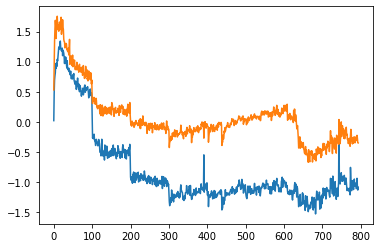

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

logger.setLevel(logging.INFO)

plt.figure()
c = range(len(gen_loss))
plt.plot(c, real_loss)
plt.plot(c, gen_loss)
#plt.savefig('image/rnn-rnn-loss.png',dpi=400)
plt.show()

In [ ]:
print_every = 100
loss_trend = []
logging.info("---------- Pre-training generator ----------")
for i in range(PRE_GEN_ITERS):
    pas = next(batch_gen)
    input_tensor = P.passwordToInputTensor(pas).to(device)
    target_tensor = P.passwordToTargetTensor(pas).to(device)
    output, loss = g.pre_train(input_tensor, target_tensor)
    
    if i % print_every == 0:
        loss_trend.append(loss)
        logging.debug("Iter: "+ str(i)+" Loss: "+str(loss))

In [ ]:
m = nn.LogSoftmax(dim=1)
loss = nn.NLLLoss()
# input is of size N x C = 3 x 5
input = torch.randn(3, 5, requires_grad=True)
# each element in target has to have 0 <= value < C
target = torch.tensor([1, 0, 4])
output = loss(m(input), target)

In [18]:
gr = nn.GRU(5, 6, 1, batch_first = True, dropout = 0).to(device)
inp = torch.ones(2,3,5).to(device)
print(inp.dim())
le = [2,3]
inp = nn.utils.rnn.pack_padded_sequence(inp, le, batch_first=True, enforce_sorted=False)
ii, batch_sizes, sorted_indices, unsorted_indices = inp
output = gr(inp)
batch_sizes, ii.dim()

3


(tensor([2, 2, 1]), 2)

In [11]:
checkpoint = torch.load("./network_checkpoint/gan_checkpoint_2000_no_pre.pt", map_location = device)
g.load_state_dict(checkpoint['gen_state_dict'])
d.load_state_dict(checkpoint['disc_state_dict'])
#disc_loss = checkpoint['disc_loss']
#gen_loss = checkpoint['gen_loss']
#real_loss = checkpoint['real_loss']

<All keys matched successfully>

In [53]:
g.pre_train(p)

In [12]:
print(g.generate_N(p))

['ziajoma!', 'anetttttttttttttttt', '1969855', 'beamfibrage24', 'calfaulabababababab', 'dadtindtzisonigoooo', 'Xmubbbbbbbbbbbbbbbb', 'Jicarl214', '09216188', 'katennlaluguirll', 'ganaiebababyel', '8925222222222222222', 'mrrstan', 'volllllllllllllllll', 'hilljomeybooooooooo', 'abbbbbbbbbbbbbbbbbb', 'ylannae', 'Wooy169', 'brayne', 'rosaamiom']


In [55]:
d.pre_train(p, g)

In [40]:
print(test(d, "     "))

tensor([[2.4465]], device='cuda:0', grad_fn=<AddmmBackward>)


In [22]:
def test(d, password):
    tensor = P.passwordToPretrainTensor(password).float()
    #tensor = torch.cat((torch.zeros(1, 10, CHARMAP_LEN).to(device), tensor), dim = 1)
    tensor = d.embedding(tensor)
    hidden = torch.zeros(d.layers, 1, d.hidden_size).to(device)
    out, _ = d.gru(tensor, hidden)
    loss = d.h2o(out[:,-1,:])
    return loss

In [ ]:
input = torch.zeros(2, 3, 5)
gru = nn.GRU(5, 5, 2, batch_first = True, dropout = 0)
input, _ = gru(input)

In [26]:
input = input.permute(0,2,1)
input

tensor([[[-0.0794, -0.1275, -0.1586],
         [-0.1050, -0.1748, -0.2156],
         [ 0.0148,  0.0036, -0.0150],
         [ 0.1235,  0.1728,  0.1929],
         [ 0.2423,  0.3453,  0.3851]],

        [[-0.0794, -0.1275, -0.1586],
         [-0.1050, -0.1748, -0.2156],
         [ 0.0148,  0.0036, -0.0150],
         [ 0.1235,  0.1728,  0.1929],
         [ 0.2423,  0.3453,  0.3851]]], grad_fn=<PermuteBackward>)

In [21]:
input = torch.ones(2,3,5)
input = input.permute(0,2,1)
cnn(input)

tensor([[[ 0.1703,  0.1703,  0.1703],
         [ 0.6303,  0.6303,  0.6303],
         [-0.3210, -0.3210, -0.3210],
         [-0.9228, -0.9228, -0.9228],
         [ 0.4264,  0.4264,  0.4264]],

        [[ 0.1703,  0.1703,  0.1703],
         [ 0.6303,  0.6303,  0.6303],
         [-0.3210, -0.3210, -0.3210],
         [-0.9228, -0.9228, -0.9228],
         [ 0.4264,  0.4264,  0.4264]]], grad_fn=<SqueezeBackward1>)

In [36]:
input = torch.zeros(2,3,5)
input = input.permute(0,2,1)
cnn(input)

tensor([[[ 0.0070,  0.0070,  0.0070,  0.0070],
         [-0.2416, -0.2416, -0.2416, -0.2416],
         [ 0.1074,  0.1074,  0.1074,  0.1074],
         [ 0.1184,  0.1184,  0.1184,  0.1184],
         [ 0.2493,  0.2493,  0.2493,  0.2493]],

        [[ 0.0070,  0.0070,  0.0070,  0.0070],
         [-0.2416, -0.2416, -0.2416, -0.2416],
         [ 0.1074,  0.1074,  0.1074,  0.1074],
         [ 0.1184,  0.1184,  0.1184,  0.1184],
         [ 0.2493,  0.2493,  0.2493,  0.2493]]], grad_fn=<SqueezeBackward1>)

In [35]:
cnn = nn.Conv1d(5,5,2, padding=1)

In [9]:
./network_checkpoint/gan_checkpoint_2000_no_pre.pt

'./network_checkpoint/gan_checkpoint.pt'